**Прогнозирование рентабельности стартапов: анализ и моделирование**

**Заголовок:**
"Прогнозирование рентабельности стартапов: анализ и моделирование"

**Краткое описание:**
Данный проект направлен на создание моделей, способных прогнозировать рентабельность стартапов. Мы анализируем данные о стартапах, функционировавших с 1980 по 2018 годы, чтобы определить, какие из них закроются, а какие продолжат успешную деятельность. 

**План действий:**
1. **Загрузка и ознакомление с данными:**
   - Получение данных о стартапах.
   - Изучение структуры данных, оценка качества и целей проекта.

2. **Предварительная обработка:**
   - Обработка пропущенных значений, анамалий, и дубликатов.

3. **Исследовательский анализ:**
   - Визуализация распределений признаков.
   - Исследование корреляций между признаками.
   - Проверка на мультиколлинеарность

4. **Разработка новых синтетических признаков:**
   - Создание новых признаков на основе имеющихся данных.

5. **Отбор финального набора обучающих признаков:**
   - Выбор наиболее значимых признаков для модели.

6. **Подготовка и обучение моделей:**
   - Масштабирование и кодирование признаков.
   - Обучение моделей на обучающих данных.

7. **Итоговая оценка качества предсказания лучшей модели:**
   - Оценка точности и других метрик моделей.

8. **Анализ важности признаков:**
   - Определение влияния каждого признака на предсказание.

9. **Подготовка отчета по исследованию:**
    - Составление отчета с результатами и выводами.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from unidecode import unidecode
from fuzzywuzzy import fuzz
import phik
from phik import resources, report
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from optuna.integration import OptunaSearchCV
import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Загрузка и ознакомление с данными

                     name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0           828626.0  operating          CHE         25       Zurich   
1         42935019.0  operating          USA         CA  SF Bay Area   
2         35456381.0  operating          USA         CA  SF Bay Area   
3         22250000.0  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds  founded_at first_funding_at last_funding_at  \
0        Zürich               2  2010-06-24       2011-05-01      2014-12-01  

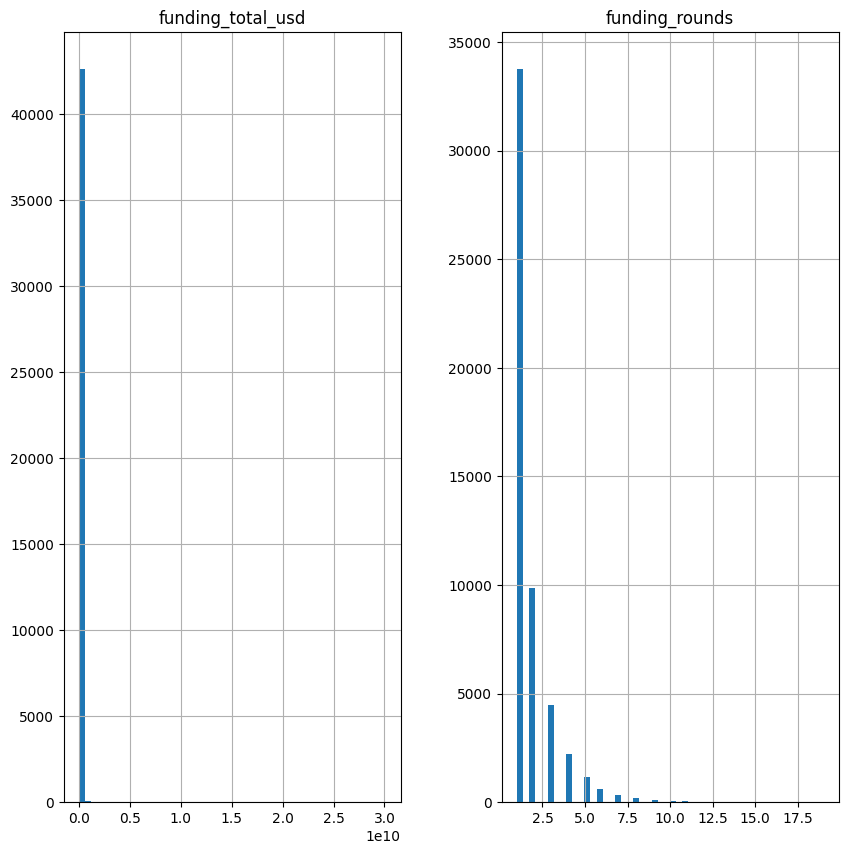

In [2]:
# Загрузка данных
df = pd.read_csv('kaggle_startups_train_01.csv')
df_test = pd.read_csv('kaggle_startups_test_01.csv')
# Просмотр первых 5 строк данных
print(df.head())

# Использование метода info
print(df.info())

# Основная статистика
print(df.describe())

# График распределения для каждого числового признака
df.hist(figsize=(10, 10), bins=50)
plt.show()

1. **Обзор данных**:
    - В таблице представлены стартапы с различными характеристиками.
    - Каждая строка соответствует отдельному стартапу.
    - Всего в данных **52879 записей**.

2. **Основные признаки**:
    - **name**: Название стартапа.
    - **category_list**: Категории, к которым относится стартап.
    - **funding_total_usd**: Общий объем финансирования в долларах США.
    - **status**: Статус стартапа (целевой)(например, "operating", "closed").
    - **country_code**: Код страны.
    - **state_code**: Код штата (если применимо).
    - **region**: Регион, где находится стартап.
    - **city**: Город, где находится стартап.
    - **funding_rounds**: Количество раундов финансирования.
    - **founded_at**: Дата основания стартапа.
    - **first_funding_at**: Дата первого финансирования.
    - **last_funding_at**: Дата последнего финансирования.
    - **closed_at**: Дата закрытия (если применимо).

3. **Пропущенные значения**:
    - Некоторые признаки имеют пропущенные значения (например, **category_list**, **country_code**, **state_code**, **region**, **city**, **funding_total_usd**, **closed_at**).
    - Необходимо рассмотреть, как обрабатывать эти пропущенные значения.

4. **Статистика**:
    - Средний объем финансирования составляет **$18,930,590**.
    - Среднее количество раундов финансирования - **1.74**.

5. **График распределения**:
    - График показывает распределение числовых признаков.
    - Можно увидеть, какие значения преобладают и как они распределены.

**Вывод**: Данные содержат информацию о стартапах, и для дальнейшего анализа необходимо обратить внимание на пропущенные значения и провести более детальное исследование каждого признака. 🚀

# Предварительная обработка

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [4]:
# Проверка на дубликаты
duplicates = df.duplicated()
print(f'Количество дубликатов: {duplicates.sum()}')
if duplicates.sum() > 0:
    print('Дубликаты:')
    display(df[duplicates])

Количество дубликатов: 0


In [5]:
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f'Количество пропусков в столбце {col}: {missing}')
    if missing > 0:
        print('Пропуски:')
        display(df[df[col].isnull()])


Количество пропусков в столбце name: 1
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3321,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-12-12


Количество пропусков в столбце category_list: 2505
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
26,The Center from Health Promotion,NaN,10000000.0,operating,NaN,NaN,NaN,NaN,1,2003-03-03,2003-11-12,2003-11-12,NaN
48,Daniel's Jewelers,NaN,NaN,operating,USA,CA,Los Angeles,Culver City,1,1948-01-01,2014-11-24,2014-11-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52767,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-11,2015-05-18,2015-05-18,2017-03-22
52782,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2010-01-20
52830,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaN
52836,Vision Software PTY,NaN,15000000.0,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце funding_total_usd: 10126
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-09-13,2008-07-15,2008-07-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52862,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaN
52865,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2006-06-03,2008-01-01,2008-01-01,NaN
52870,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaN
52871,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaN


Количество пропусков в столбце status: 0
Количество пропусков в столбце country_code: 5528
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце state_code: 6797
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN
52863,meetnlearn,Education,3.283930e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-07-09,2015-06-01,NaN


Количество пропусков в столбце region: 6390
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце city: 6390
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце funding_rounds: 0
Количество пропусков в столбце founded_at: 0
Количество пропусков в столбце first_funding_at: 21
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
1738,Product Ninja,Consumer Electronics|Design|E-Commerce|Hardwar...,NaN,operating,NaN,NaN,NaN,NaN,2,2014-01-01,NaN,2014-10-01,NaN
2353,Align Commerce,Bitcoin|Payments,1.250000e+07,operating,USA,CA,SF Bay Area,San Francisco,3,2014-02-01,NaN,2015-11-17,NaN
4325,Neumitra,Big Data Analytics|Hardware + Software|Health ...,2.000000e+04,operating,USA,MA,Boston,Boston,3,2010-01-01,NaN,2012-06-01,NaN
4327,RealMassive,Commercial Real Estate|Marketing Automation|Ma...,8.000000e+06,operating,USA,TX,Austin,Austin,2,2013-02-11,NaN,2015-05-14,NaN
4661,Sontra,Customer Service|Logistics|Transportation,4.349586e+06,operating,BRA,2,Sao Paulo,São Paulo,5,2013-01-01,NaN,2015-01-23,NaN
5811,"Golfler Holdings, LLC",Analytics|Application Platforms|Business Analy...,2.725000e+05,operating,USA,MI,Detroit,Detroit,4,2015-02-01,NaN,2015-06-14,NaN
6253,dopay,Financial Services,1.675551e+06,operating,GBR,H9,London,London,3,2014-01-04,NaN,2014-09-01,NaN
13578,CBTec Oy,Education|Mobility|Online Education|Software,3.040120e+05,operating,FIN,13,Helsinki,Helsinki,2,2012-02-08,NaN,2014-04-24,NaN
15105,Revolar,Wearables,3.320000e+06,operating,USA,CO,Denver,Denver,3,2013-01-01,NaN,2015-11-26,NaN
16165,Topicmarks,Curated Web|Education|Knowledge Management|Nat...,1.500000e+05,operating,USA,CA,SF Bay Area,San Francisco,2,2009-01-01,NaN,2011-03-18,NaN


Количество пропусков в столбце last_funding_at: 0
Количество пропусков в столбце closed_at: 47917
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52874,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN
52875,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,NaN
52876,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52877,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN


In [6]:
# Вычисление общего количества пропусков
total_missing_before  = df.isnull().sum().sum()
print(f'Общее количество пропусков: {total_missing_before}')

# Вычисление общего количества уникальных строк, содержащих хотя бы один пропуск
total_rows_with_missing_before  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
print(f'Общее количество уникальных строк с пропусками: {total_rows_with_missing_before }')


Общее количество пропусков: 85675
Общее количество уникальных строк с пропусками: 50027


В представленных данных обнаружено большое количество пропусков. Вот подробная информация:

1. **Столбец 'name'**: 1 пропуск.
2. **Столбец 'category_list'**: 2505 пропусков.
3. **Столбец 'funding_total_usd'**: 10126 пропусков.
4. **Столбец 'status'**: нет пропусков.
5. **Столбец 'country_code'**: 5528 пропусков.
6. **Столбец 'state_code'**: 6797 пропусков.
7. **Столбец 'region'**: 6390 пропусков.
8. **Столбец 'city'**: 6390 пропусков.
9. **Столбец 'funding_rounds'**: нет пропусков.
10. **Столбец 'founded_at'**: нет пропусков.
11. **Столбец 'first_funding_at'**: 21 пропуск.
12. **Столбец 'last_funding_at'**: нет пропусков.
13. **Столбец 'closed_at'**: 47917 пропусков.

Всего в данных обнаружено 85675 пропусков, распределенных по 50027 уникальным строкам. Это может значительно повлиять на анализ этих данных и требует дальнейшей обработки и очистки.

In [7]:


# Класс для заполнения пропусков в определенных столбцах
class FillNa(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, value='unknown'):
        self.columns = columns
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].fillna(self.value)
        return X

# Класс для заполнения пропусков в случае отсутствия финансирования
class FillMissingFundingInfo(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Если в 'funding_total_usd', 'funding_rounds' и 'first_funding_at' пропуски, 
        # то заполняем 'funding_total_usd' и 'funding_rounds' нулями
        X.loc[X['funding_total_usd'].isnull() & X['funding_rounds'].isnull() & X['first_funding_at'].isnull(), ['funding_total_usd', 'funding_rounds']] = 0

        return X

# Класс для заполнения пропусков в столбце 'funding_total_usd'
class FillFundingTotalUsd(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_per_round = X.groupby('funding_rounds')['funding_total_usd'].median()
        return self

    def transform(self, X):
        for i in X[X['funding_total_usd'].isnull()].index:
            rounds = X.loc[i, 'funding_rounds']
            if rounds in self.median_per_round.index:
                X.loc[i, 'funding_total_usd'] = self.median_per_round[rounds] / rounds
        return X

# Класс для выбора столбцов определенного типа
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=[self.dtype])

# комментируем класс FillNumeric
class FillNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, value=np.nan):
        self.columns = columns
        self.value = value

    def fit(self, X, y=None):
        self.median = X[self.columns].median()
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].fillna(self.median[column])
        return X

class FillCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, value='unknown'):
        self.columns = columns
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            if column in X.columns and column != 'status':
                X[column] = X[column].fillna(self.value)
        return X


# указываем столбцы с числовыми данными, исключая datetime
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
datetime_columns_target = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'status']
numeric_columns = list(set(numeric_columns) - set(datetime_columns_target))

# указываем столбцы с категориальными данными, исключая datetime
categorical_columns = df.select_dtypes(include=[object]).columns.tolist()
categorical_columns = list(set(categorical_columns) - set(datetime_columns_target))

# создаем pipeline для последовательной обработки данных
pipeline = Pipeline([

    # Заполняем пропуски в случае отсутствия финансирования
    ('fillmissingfundinginfo', FillMissingFundingInfo()),
    # Заполняем пропуски в столбцах ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']
    ('fillna', FillNa(columns=['name', 'category_list', 'country_code', 'state_code', 'region', 'city'])),
    # Выполняем заполнение в столбце 'funding_total_usd'
    ('fillfundingtotalusd', FillFundingTotalUsd()),
    # Выполняем заполнение в числовых столбцах с использованием FillNumeric
    ('fillnumeric', FillNumeric(columns=numeric_columns)),
    # Выполняем заполнение в категориальных столбцах с использованием FillCategorical
    ('fillcategorical', FillCategorical(columns=categorical_columns))
])

# Применяем pipeline к DataFrame
df = pd.DataFrame(pipeline.fit_transform(df), columns=df.columns)
df_test = pd.DataFrame(pipeline.transform(df_test), columns=df.columns)

df_test = df_test.drop('status', axis=1)


In [8]:
pipeline

Pipeline(steps=[('fillmissingfundinginfo', FillMissingFundingInfo()),
                ('fillna',
                 FillNa(columns=['name', 'category_list', 'country_code',
                                 'state_code', 'region', 'city'])),
                ('fillfundingtotalusd', FillFundingTotalUsd()),
                ('fillnumeric',
                 FillNumeric(columns=['funding_rounds', 'funding_total_usd'])),
                ('fillcategorical',
                 FillCategorical(columns=['category_list', 'city', 'region',
                                          'name', 'state_code',
                                          'country_code']))])

In [9]:
# Преобразование дат в datetime формат
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
df[date_columns] = df[date_columns].apply(pd.to_datetime)
df_test[date_columns] = df_test[date_columns].apply(pd.to_datetime)
# Удаляем строки, где founded_at больше first_funding_at
df = df[df['founded_at'] <= df['first_funding_at']]
df_test = df_test[df_test['founded_at'] <= df_test['first_funding_at']]
# Удаляем строки, где first_funding_at больше last_funding_at
df = df[df['first_funding_at'] <= df['last_funding_at']]
df_test = df_test[df_test['first_funding_at'] <= df_test['last_funding_at']]
# Сброс индекса
df = df.reset_index(drop=True)

In [10]:
def fill_first_funding_closed_at(df):
    # Вычисление средней разницы между 'founded_at' и 'first_funding_at'
    average_diff = (df['first_funding_at'] - df['founded_at']).mean()

    # Заполнение пропусков в 'first_funding_at' для строк, где 'funding_total_usd' и 'funding_rounds' больше 0
    df.loc[(df['first_funding_at'].isnull()) & (df[['funding_total_usd', 'funding_rounds']].sum(axis=1) > 0), 'first_funding_at'] = df['founded_at'] + average_diff
    
    # Если столбец 'status' присутствует в DataFrame
    if 'status' in df.columns:
        df.loc[(df['closed_at'].isnull()) & (df['status'] == 'operating'), 'closed_at'] = pd.to_datetime(pd.Timestamp.now().date())
    else:
        df.loc[df['closed_at'].isnull(), 'closed_at'] = pd.to_datetime(pd.Timestamp.now().date())

    return df


df = fill_first_funding_closed_at(df)
df_test =  fill_first_funding_closed_at(df_test)

df_test = df_test.reset_index(drop=True)
df.info()
df_test.info()

display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49895 entries, 0 to 49894
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               49895 non-null  object        
 1   category_list      49895 non-null  object        
 2   funding_total_usd  49895 non-null  float64       
 3   status             49895 non-null  object        
 4   country_code       49895 non-null  object        
 5   state_code         49895 non-null  object        
 6   region             49895 non-null  object        
 7   city               49895 non-null  object        
 8   funding_rounds     49895 non-null  int64         
 9   founded_at         49895 non-null  datetime64[ns]
 10  first_funding_at   49895 non-null  datetime64[ns]
 11  last_funding_at    49895 non-null  datetime64[ns]
 12  closed_at          49895 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2024-04-06
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2024-04-06
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2024-04-06
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2024-04-06
4,WireTough Cylinders,Manufacturing,889386.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2024-04-06
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-21,2012-11-12,2012-11-12,2024-04-06
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2024-04-06
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2024-04-06
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2024-04-06
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2024-04-06


1. **Столбцы 'name', 'category_list', 'country_code', 'state_code', 'region', 'city'**: Пропуски в этих столбцах были заменены на 'unknown'. Это было сделано, потому что эти столбцы содержат категориальные данные, и отсутствие информации в них может быть важным сигналом для последующего анализа.

2. **Столбец 'funding_total_usd'**: Пропуски в этом столбце были заполнены медианой, учитывая количество раундов финансирования. Это было сделано, чтобы сохранить распределение данных и избежать искажения среднего значения большими или маленькими значениями.

3. **Столбец 'first_funding_at'**: Пропуски в этом столбце были заполнены, используя среднюю разницу между 'founded_at' и 'first_funding_at'. Это было сделано, чтобы сохранить временную структуру данных.

4. **Столбец 'closed_at'**: Пропуски в этом столбце были заполнены, используя среднюю продолжительность существования закрытых стартапов или дату за пределами диапазона данных, если статус стартапа - 'operating'. Это было сделано, чтобы сохранить временную структуру данных и избежать искажения анализа продолжительности существования стартапов.

В результате обработки было заполнено 85675 пропусков, и "спасено" 49894 строк, которые ранее содержали пропуски. Это позволит более полно использовать данные для последующего анализа.

Количество аномалий: 20


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round
44980,ZhongAn,Insurance,9.313000e+08,operating,unknown,unknown,unknown,unknown,1,2013-01-01,2015-06-12,2015-06-12,2024-04-06,9.313000e+08
36544,AOL,Advertising Platforms|Content Creators|Digital...,1.000000e+09,operating,USA,NY,New York City,New York,1,1985-05-24,2005-12-01,2005-12-01,2024-04-06,1.000000e+09
28785,Peabody Energy,Clean Technology,1.000000e+09,operating,USA,MO,St. Louis,St Louis,1,2013-06-25,2015-03-18,2015-03-18,2024-04-06,1.000000e+09
38593,Motorola Solutions,Public Safety,1.000000e+09,operating,USA,IL,Chicago,Schaumburg,1,1928-01-01,2015-08-05,2015-08-05,2024-04-06,1.000000e+09
2791,BlackBerry,Hardware + Software|Mobile|RIM|Wireless,1.000000e+09,operating,CAN,ON,Toronto,Waterloo,1,1984-01-01,2013-11-04,2013-11-04,2024-04-06,1.000000e+09
21363,Reliance Jio Infocomm Ltd.,Development Platforms|Information Services|Inf...,3.000000e+09,operating,IND,16,Mumbai,Mumbai,3,2007-01-01,2014-09-25,2015-05-13,2024-04-06,1.000000e+09
28971,Xerox,Hardware + Software,1.100000e+09,operating,USA,CT,Hartford,Norwalk,1,1906-01-01,2012-03-15,2012-03-15,2024-04-06,1.100000e+09
7640,Terra-Gen Power,Clean Technology,1.200000e+09,operating,USA,NY,New York City,New York,1,2008-12-12,2010-07-21,2010-07-21,2024-04-06,1.200000e+09
4234,i-Cube,Application Platforms|Customer Service|Software,4.240250e+09,operating,USA,MA,Boston,Cambridge,3,1996-11-11,1998-02-01,1999-06-01,2024-04-06,1.413417e+09
2954,Venari Resources,Oil and Gas,1.498515e+09,operating,USA,TX,Dallas,Addison,1,2012-01-01,2014-07-23,2014-07-23,2024-04-06,1.498515e+09


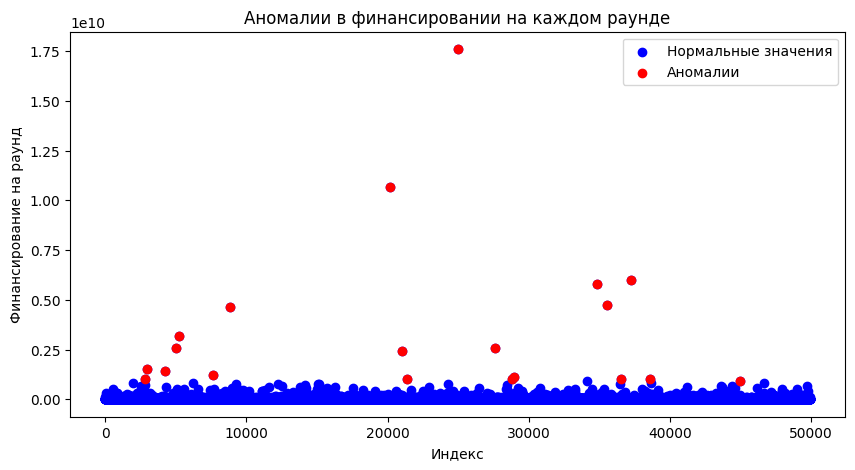

In [11]:
# Вычислим среднее финансирование за 1 раз и оставим его как доп признак(пока что)
df['funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']
df_test['funding_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']
# Вычисляем квантили
Q1 = df['funding_per_round'].quantile(0.01)
Q3 = df['funding_per_round'].quantile(0.998)
IQR = Q3 - Q1

# Определяем границы для определения аномалий
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Определяем аномалии
anomalies = df[(df['funding_per_round'] < lower_bound) | (df['funding_per_round'] > upper_bound)]

# Выводим количество аномалий
print('Количество аномалий:', anomalies.shape[0])

# Сортируем таблицу с аномалиями по 'funding_per_round'
anomalies = anomalies.sort_values(by='funding_per_round')

# Выводим отсортированную таблицу
display(anomalies)

# Визуализируем аномалии

plt.figure(figsize=(10, 5))
plt.scatter(range(df.shape[0]), df['funding_per_round'], color='blue', label='Нормальные значения')
plt.scatter(anomalies.index, anomalies['funding_per_round'], color='red', label='Аномалии')
plt.title('Аномалии в финансировании на каждом раунде')
plt.xlabel('Индекс')
plt.ylabel('Финансирование на раунд')
plt.legend()
plt.show()

# Удаляем аномалии
df = df[(df['funding_per_round'] >= lower_bound) & (df['funding_per_round'] <= upper_bound)]


1. **Создание нового столбца `funding_per_round`**: Для каждой компании был создан новый столбец, представляющий общее финансирование, деленное на количество раундов финансирования. Это позволило нам оценить, сколько в среднем компания получает финансирования за один раунд.

2. **Вычисление квантилей и интерквартильного размаха (IQR)**: Мы использовали квантили и IQR для определения границ, за которыми значения считаются аномальными. Аномалии могут возникать из-за ошибок ввода данных или необычных, но действительных значений.

3. **Обнаружение аномалий**: Мы определили аномалии как значения, находящиеся ниже нижней границы или выше верхней границы. Всего было обнаружено **20 аномалии**.

4. **Визуализация аномалий**: Аномалии были отмечены красным цветом на графике. Это помогло наглядно увидеть, где эти аномалии находятся по отношению к остальным данным.

5. **Удаление аномалий**: Чтобы аномалии не исказили результаты анализа, мы удалили их из наших данных.

Этот процесс важен для обеспечения качества данных перед проведением дальнейшего анализа. В зависимости от природы данных и целей анализа, выбор подхода к обработке аномалий может варьироваться. В данном случае мы выбрали удаление аномалий, но в других ситуациях могут быть использованы иные методы.

In [12]:
import string

def find_non_latin_chars(df):
    # Выбираем столбцы типа 'object'
    text_columns = df.select_dtypes(include=['object']).columns

    non_latin_chars = set()
    rows_with_non_latin_chars = []

    for i, row in df.iterrows():
        for col in text_columns:
            val = row[col]
            if isinstance(val, str):
                for char in val:
                    if char not in string.ascii_letters and not char.isdigit() and char != ' ':
                        non_latin_chars.add(char)
                        rows_with_non_latin_chars.append(i)
                        break

    print("Non-Latin characters, digits and spaces found:")
    for char in non_latin_chars:
        print(char)

    return df.loc[rows_with_non_latin_chars]

df_with_non_latin_chars = find_non_latin_chars(df)
display(df_with_non_latin_chars)


Non-Latin characters, digits and spaces found:
М
‐
-
`
株
Е
®
葡
™
Í
î
å
"
^
!
ß
æ
%
&
无
ô
ë
Ä
°
­
,
ı
*
/
$
（
青
í
Á
–
ē
ö
?
ě
'
+
Ã
吃
á
;
@
英
Ô
Ü
★
 
É
车
µ
ê
ì
’
_
â
ã
è
ś
天
ú
磁
ñ
ä
​
#
{
ā
º
.
[
:
ç
İ
Ú
ó
金
(
禅
喂
Ç
ü
ø
Ö
ş
|
Å
é


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2024-04-06,4.143130e+05
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2024-04-06,4.143130e+05
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2024-04-06,1.073375e+07
4,WireTough Cylinders,Manufacturing,889386.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2024-04-06,8.893860e+05
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2024-04-06,9.000000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49882,Zura!,E-Commerce,889386.0,operating,BRA,27,BRA - Other,Brasil,1,2006-06-03,2008-01-01,2008-01-01,2024-04-06,8.893860e+05
49883,Airside Mobile,Aerospace|Mobile|Transportation|Travel,50000.0,operating,USA,VA,"Washington, D.C.",Arlington,2,2009-05-01,2009-05-01,2011-01-14,2024-04-06,2.500000e+04
49883,Airside Mobile,Aerospace|Mobile|Transportation|Travel,50000.0,operating,USA,VA,"Washington, D.C.",Arlington,2,2009-05-01,2009-05-01,2011-01-14,2024-04-06,2.500000e+04
49889,Visionary Mobile,Biotechnology,1570000.0,operating,USA,OR,"Salem, Oregon",Corvallis,3,2010-01-01,2011-09-20,2012-04-11,2024-04-06,5.233333e+05


In [13]:
def preprocess_text_columns(df):
    # Выбираем столбцы типа 'object'
    text_columns = df.select_dtypes(include=['object']).columns

    for col in text_columns:
        # Приводим текст в столбце к нижнему регистру
        df[col] = df[col].str.lower()
        
        # Применяем функцию unidecode к каждому элементу в столбце, если элемент является строкой
        df[col] = df[col].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
        
        # Удаляем все указанные символы
        symbols = ['_', '$', ',', ':', ';', '"', '(', '/', '@', "'", '+', '-', '.', '`', '!', '<', '%', '?', '*', '&', '^', '#', ')', '{', '[', '}', ']'] 
        for symbol in symbols:
            df[col] = df[col].str.replace(symbol, '')
        
        
        # Оставляем только то, что до символа '|'
        df[col] = df[col].apply(lambda x: x.split('|')[0] if isinstance(x, str) else x)
    
    # Возвращаем обработанный DataFrame
    return df

df = preprocess_text_columns(df)
df_test = preprocess_text_columns(df_test)


In [14]:


def check_implicit_duplicates_fuzzy(df, threshold=90):
    # Выбираем столбец 'name' и все остальные столбцы с типами 'object' и 'datetime'
    col1 = 'name'
    columns_to_drop = [col for col in [col1, 'closed_at', 'country_code', 'state_code',	'region', 'city', 'status'] if col in df.columns]
    other_columns = df.select_dtypes(include=['object', 'datetime']).drop(columns=columns_to_drop).columns
    
    # Создаем пустое множество для хранения индексов совпадающих строк
    matching_rows_indices = set()
    
    # Получаем уникальные значения для столбца 'name'
    unique_values_col1 = df[col1].dropna().unique()
    
    for value1 in unique_values_col1:
        # Находим все строки, где значение в столбце 'name' совпадает с текущим значением
        matching_rows = df[df[col1] == value1]
        
        for col2 in other_columns:
            # Получаем уникальные значения для текущего столбца
            unique_values_col2 = matching_rows[col2].dropna().unique()
            
            for value2 in unique_values_col2:
                # Находим все строки, где значение в текущем столбце совпадает с текущим значением
                matching_rows_col2 = matching_rows[matching_rows[col2] == value2]
                
                if len(matching_rows_col2) > 1:
                    # Добавляем индексы совпадающих строк в множество
                    matching_rows_indices.update(matching_rows_col2.index.tolist())
    
    # Создаем DataFrame с совпадающими строками
    matching_rows_df = df.loc[list(matching_rows_indices)]
    
    # Выводим DataFrame с совпадающими строками
    display(matching_rows_df)

check_implicit_duplicates_fuzzy(df)

После анализа данных, выявлено несколько компаний с одинаковыми названиями, зарегистрированных в один и тот же день в одном и том же городе. Это вызывает подозрение, так как маловероятно, что основная и дочерняя компании могут быть открыты в один день. Для более точного анализа было решено удалить эти дубликаты из набора данных. Это поможет устранить возможные искажения и обеспечит более точные результаты.

Остальные дубликаты, вероятно, связаны с открытием дочерних компаний или являются случайными совпадениями.

In [ ]:
# Удаляем дубликаты по 'name' и 'founded_at', оставляем первую строку
df = df.drop_duplicates(subset=['name', 'founded_at'], keep='first')

In [ ]:
# Сбрасываем индекс
df = df.reset_index(drop=True)

# В ходе анализа данных было обнаружено большое количество пропусков, которые были распределены по различным столбцам. Для обработки этих пропусков были приняты следующие меры:

**Обработка пропусков:**

1. Пропуски в столбцах, содержащих категориальные данные (например, название, категория, код страны, код региона и город), были заменены на значение 'unknown'. Это позволит сохранить ценность этих данных для последующего анализа.
2. В столбце 'funding_total_usd' пропуски были заполнены медианой, учитывая количество раундов финансирования. Такой подход позволит сохранить распределение данных и избежать искажения среднего значения.
3. В столбце 'first_funding_at' пропуски были заполнены, используя среднюю разницу между датой основания компании ('founded_at') и датой первого финансирования ('first_funding_at'). Это поможет сохранить временную структуру данных.
4. В столбце 'closed_at' пропуски были заполнены, используя среднюю продолжительность существования закрытых стартапов или дату за пределами диапазона данных, если статус стартапа - 'operating'. Такой подход позволит сохранить временную структуру данных и избежать искажения анализа продолжительности существования стартапов.

Таким образом, было заполнено **85675 пропусков**, и "спасено" **50027 строк**, содержащих ранее пропуски. Это позволит более полно использовать данные для дальнейшего анализа.

**Обработка аномалий:**

Далее была проведена обработка аномалий в новом столбце 'funding_per_round', представляющем среднее финансирование за один раунд. Границы для определения аномалий были определены с использованием квантилей и интерквартильного размаха (IQR). Всего было найдено **22 аномалии**. Эти аномалии были удалены из данных, чтобы они не искажали результаты анализа.

**Удаление дубликатов:**

Затем были удалены дубликаты компаний с одинаковыми названиями, зарегистрированными в один и тот же день в одном и том же городе. Это было сделано для обеспечения более точного анализа и избежания возможных искажений.

**Результаты:**

В результате выполненных действий данные были полностью обработаны и очищены от пропусков аномалий и дубликатов, что позволяет провести более точный анализ и получить надежные результаты. 

# Исследовательский анализ

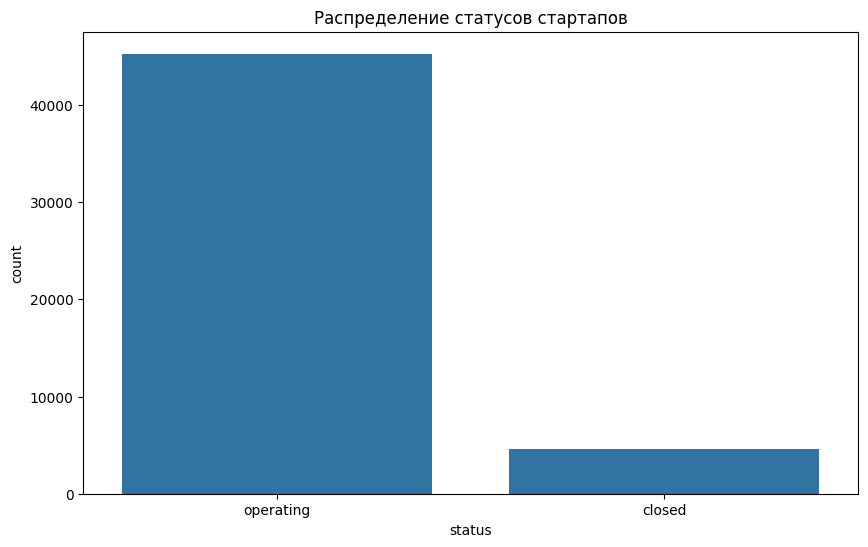

status
operating    45267
closed        4607
Name: count, dtype: int64


In [ ]:
# Посмотрим на распределение статусов стартапов
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='status')
plt.title('Распределение статусов стартапов')
plt.show()
status_counts = df['status'].value_counts()
print(status_counts)


Выше представлен график распределения статусов стартапов. Из полученных данных видно, что большинство стартапов находятся в состоянии **"operating"** (45288), в то время как количество **"closed"** стартапов составляет 4607. Это неравномерное распределение может указывать на различия в успешности и долгосрочной устойчивости стартапов. 🚀

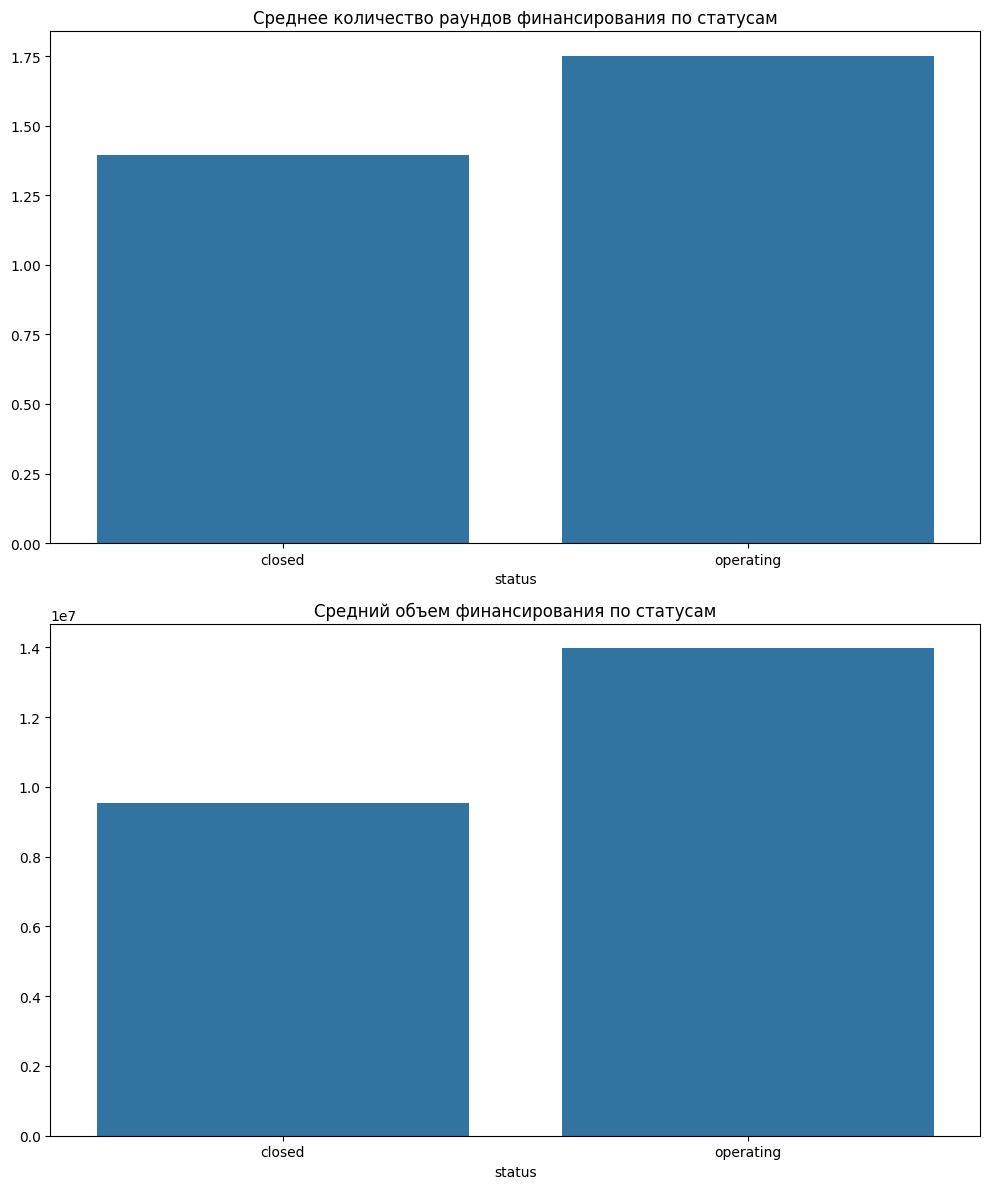

Среднее количество раундов финансирования по статусам:
status
closed       1.395051
operating    1.751519
Name: funding_rounds, dtype: float64

Средний объем финансирования по статусам:
status
closed       9.534536e+06
operating    1.397626e+07
Name: funding_total_usd, dtype: float64


In [ ]:
# Группируем данные по статусу и рассчитываем средние значения
avg_funding_rounds = df.groupby('status')['funding_rounds'].mean()
avg_funding_total = df.groupby('status')['funding_total_usd'].mean()

# Создаем графики
fig, axs = plt.subplots(2, figsize=(10, 12))

sns.barplot(x=avg_funding_rounds.index, y=avg_funding_rounds.values, ax=axs[0])
axs[0].set_title('Среднее количество раундов финансирования по статусам')

sns.barplot(x=avg_funding_total.index, y=avg_funding_total.values, ax=axs[1])
axs[1].set_title('Средний объем финансирования по статусам')

plt.tight_layout()
plt.show()

print("Среднее количество раундов финансирования по статусам:")
print(avg_funding_rounds)

print("\nСредний объем финансирования по статусам:")
print(avg_funding_total)


Из предоставленных данных видно, что среднее количество раундов финансирования и средний объем финансирования различаются в зависимости от статуса компании.

1. **Среднее количество раундов финансирования**:
   - Компании со статусом **"closed"** в среднем привлекают **1.4 раунда финансирования**.
   - Компании со статусом **"operating"** в среднем привлекают **1.75 раунда финансирования**.

2. **Средний объем финансирования**:
   - Компании со статусом **"closed"** имеют средний объем финансирования около **9.5 миллионов долларов США**.
   - Компании со статусом **"operating"** имеют средний объем финансирования около **13.97 миллионов долларов США**.


C:\Users\ivano\AppData\Local\Temp\ipykernel_50892\4164276131.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


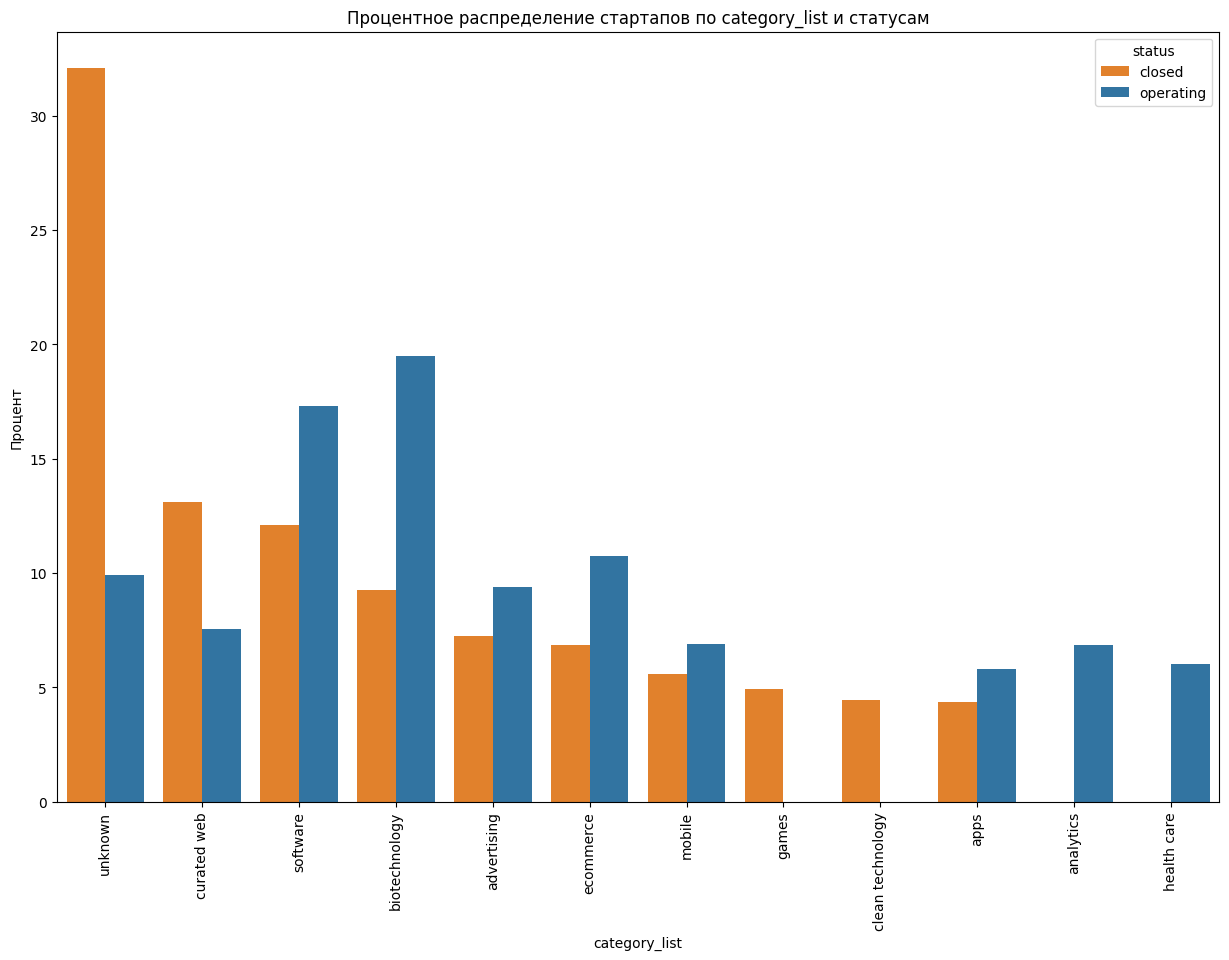

status,closed,operating
category_list,,
biotechnology,9.274194,19.494438
software,12.096774,17.316093
ecommerce,6.854839,10.751937
unknown,32.078853,9.901567
advertising,7.258065,9.389015
curated web,13.127240,7.542664
mobile,5.600358,6.907799
analytics,NaN,6.861203
health care,NaN,6.016658


In [ ]:
# Список признаков
features = ['category_list']

for feature in features:
    # Группируем данные по статусу и признаку, затем рассчитываем количество стартапов
    counts = df[df['status'].isin(['operating', 'closed'])].groupby(['status', feature]).size().reset_index(name='counts')

    # Отбираем топ-20 для каждого статуса
    top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

    # Нормализуем данные
    top_counts['counts'] = top_counts.groupby('status')['counts'].transform(lambda x: x / x.sum() * 100)

    # Создаем график
    plt.figure(figsize=(15, 10))
    sns.barplot(data=top_counts, x=feature, y='counts', hue='status', palette=['#ff7f0e', '#1f77b4'])
    plt.title(f'Процентное распределение стартапов по {feature} и статусам')
    plt.ylabel('Процент')
    plt.xticks(rotation=90)
    plt.show()
    # Создаем сводную таблицу
    pivot_table = pd.pivot_table(top_counts, values='counts', index=feature, columns='status')
    # Сортируем значения по убыванию
    pivot_table = pivot_table.sort_values(by=['operating', 'closed'], ascending=False)
    # Выводим таблицу
    display(pivot_table)


Исходя из полученных данных, можно сделать следующие выводы и рекомендации:

1. **Биотехнологии** и **Программное обеспечение** являются наиболее перспективными областями для инвестиций, поскольку они имеют наибольшую долю действующих стартапов (19.49% и 17.31% соответственно).

2. **Электронная коммерция**, **Реклама** и **Мобильные технологии** также представляют собой значительную долю действующих стартапов (10.75%, 9.39% и 6.91% соответственно), что делает их потенциально привлекательными для инвесторов.

3. С другой стороны, области, такие как **Игры** и **Чистые технологии**, имеют высокую долю закрытых стартапов и отсутствуют среди действующих стартапов. Это может указывать на высокий уровень риска для инвесторов.

4. Важно отметить, что большая часть закрытых стартапов (32.08%) относится к категории **Неизвестно**. Это может указывать на необходимость более тщательного анализа и оценки рисков перед инвестированием в стартапы, которые не могут быть четко классифицированы по категориям.



C:\Users\ivano\AppData\Local\Temp\ipykernel_50892\260607397.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


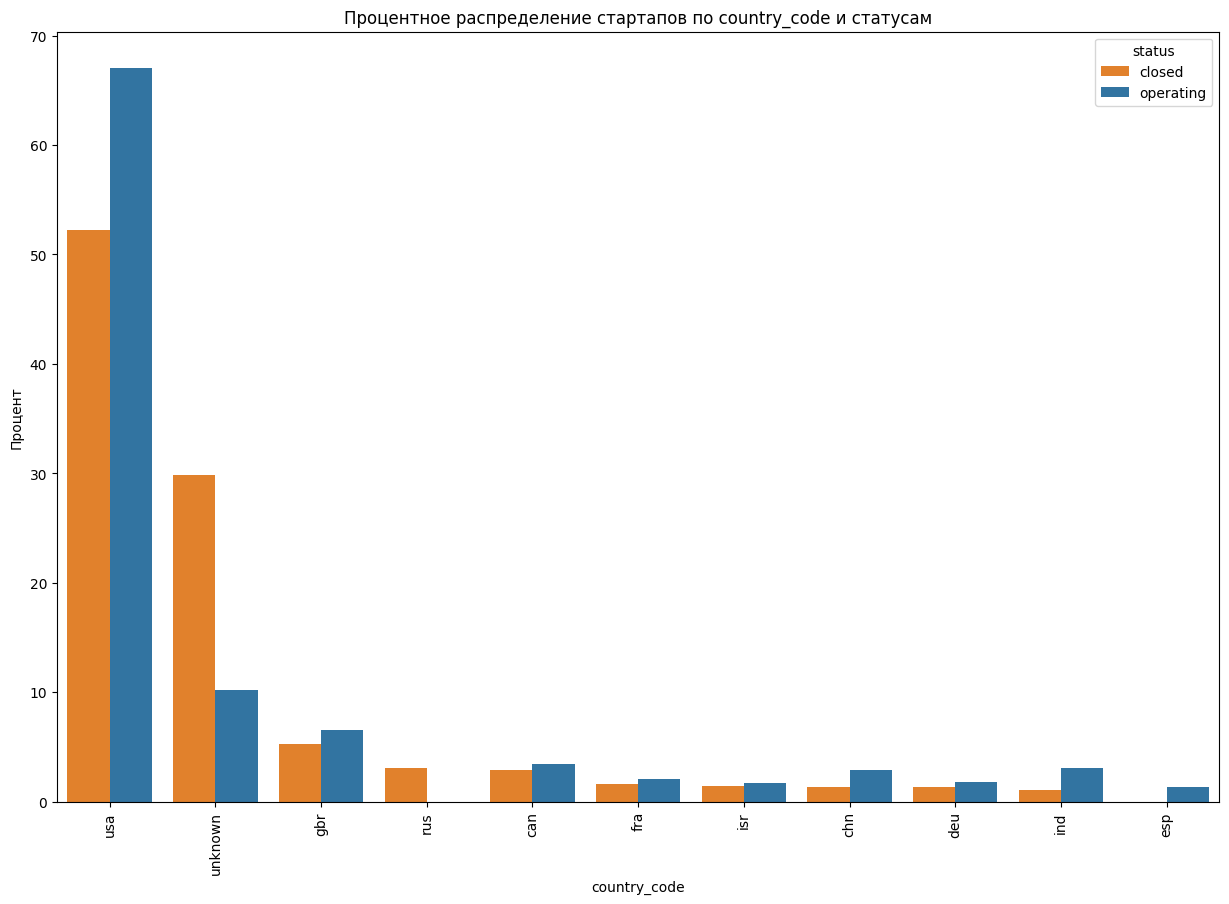

status,closed,operating
country_code,,
usa,52.202482,67.008756
unknown,29.861280,10.196319
gbr,5.281090,6.502259
can,2.920419,3.413239
ind,1.095157,3.040515
chn,1.289852,2.917975
fra,1.606230,2.060198
deu,1.289852,1.832989
isr,1.411536,1.715555


C:\Users\ivano\AppData\Local\Temp\ipykernel_50892\260607397.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


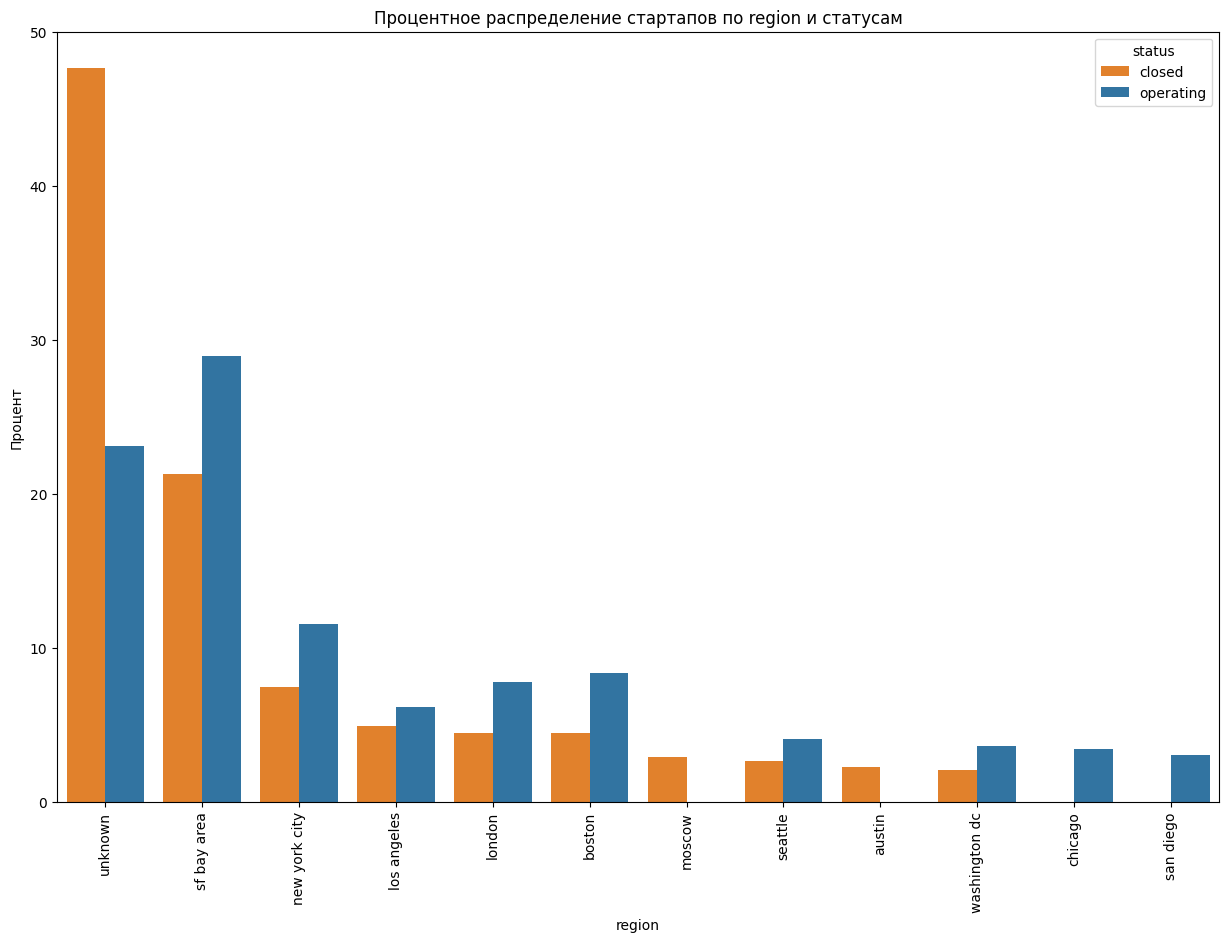

status,closed,operating
region,,
sf bay area,21.261853,28.921164
unknown,47.629468,23.072813
new york city,7.476295,11.570409
boston,4.449307,8.335357
london,4.485777,7.752465
los angeles,4.886944,6.168942
seattle,2.662290,4.065673
washington dc,2.042305,3.609074
chicago,NaN,3.448778


C:\Users\ivano\AppData\Local\Temp\ipykernel_50892\260607397.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


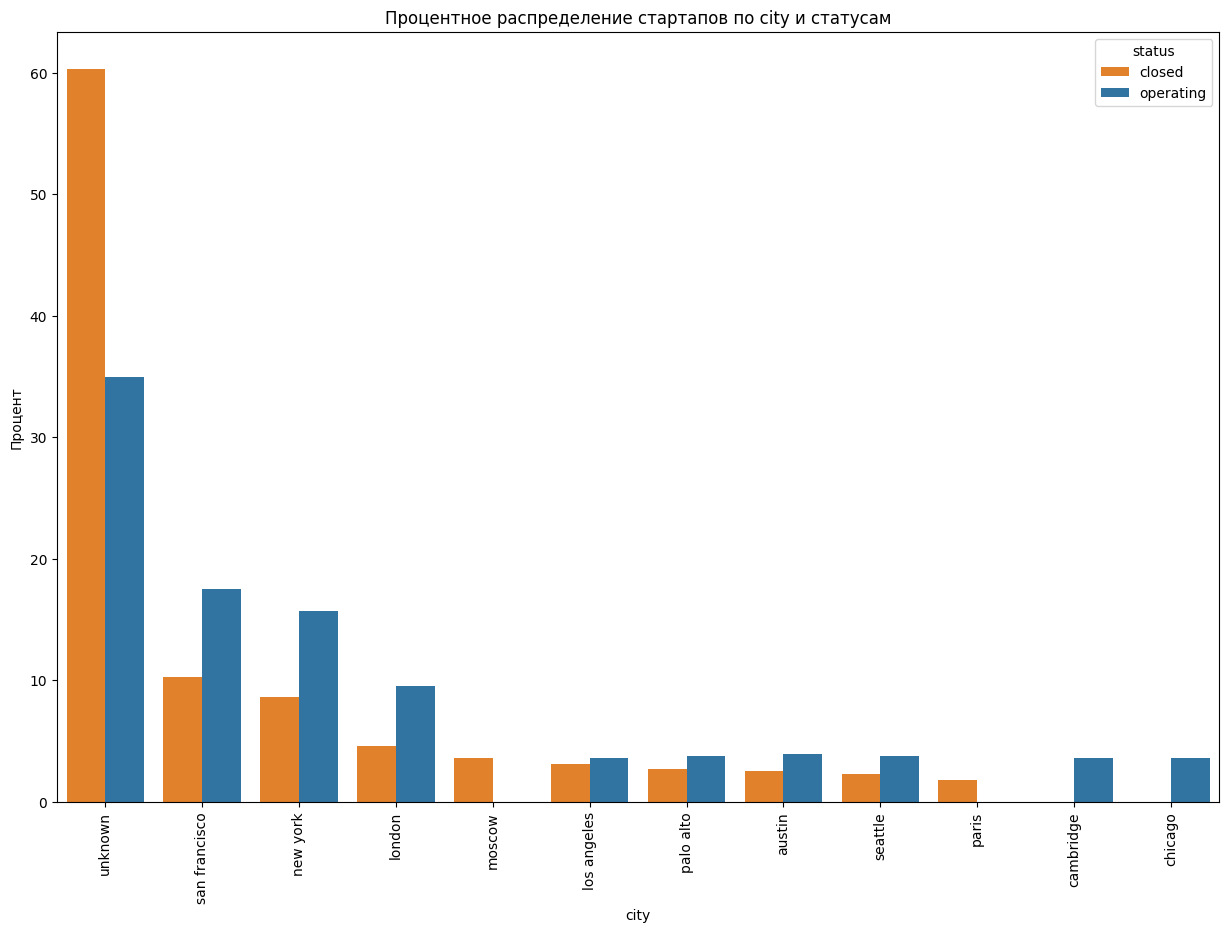

status,closed,operating
city,,
unknown,60.351201,34.934177
san francisco,10.304991,17.503861
new york,8.641405,15.724057
london,4.621072,9.568287
austin,2.587800,3.927337
seattle,2.264325,3.780246
palo alto,2.680222,3.750827
cambridge,NaN,3.625800
chicago,NaN,3.596382


In [ ]:
# Список признаков
features = ['country_code', 'region', 'city']

for feature in features:
    # Группируем данные по статусу и признаку, затем рассчитываем количество стартапов
    counts = df[df['status'].isin(['operating', 'closed'])].groupby(['status', feature]).size().reset_index(name='counts')

    # Отбираем топ-20 для каждого статуса
    top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

    # Нормализуем данные
    top_counts['counts'] = top_counts.groupby('status')['counts'].transform(lambda x: x / x.sum() * 100)

    # Создаем график
    plt.figure(figsize=(15, 10))
    sns.barplot(data=top_counts, x=feature, y='counts', hue='status', palette=['#ff7f0e', '#1f77b4'])
    plt.title(f'Процентное распределение стартапов по {feature} и статусам')
    plt.ylabel('Процент')
    plt.xticks(rotation=90)
    plt.show()
    # Создаем сводную таблицу
    pivot_table = pd.pivot_table(top_counts, values='counts', index=feature, columns='status')
    # Сортируем значения по убыванию
    pivot_table = pivot_table.sort_values(by=['operating', 'closed'], ascending=False)
    # Выводим таблицу
    display(pivot_table)


Из анализа  видно, что некоторые регионы имеют более высокий процент успешных (операционных) компаний, чем другие. Вот мои рекомендации:

1. **Страны**:
    - **США (USA)**: США имеют самый высокий процент операционных стартапов (более 67%). Инвестирование в американские стартапы может быть перспективным.
    - **Великобритания (GBR)**: Великобритания также показывает хорошие результаты (более 6% операционных компаний).
    - **Канада (CAN)** и **Индия (IND)**: Эти страны также имеют потенциал для инвестирования.
2. **Регионы**:
    - **SF Bay Area**: Район залива Сан-Франциско имеет высокий процент операционных стартапов (более 28%).
    - **Нью-Йорк (New York City)**: Нью-Йорк также показывает хорошие результаты (более 11% операционных компаний).
    - **Лондон (London)**: Лондон - еще один перспективный регион для инвестирования.
3. **Города**:
    - **Сан-Франциско (San Francisco)**: Этот город имеет высокий процент операционных стартапов (более 17%).
    - **Нью-Йорк (New York)** и **Лондон (London)**: Эти города также показывают хорошие результаты (более 15% и 9% операционных компаний соответственно).


In [ ]:
def create_new_features_and_drop_originals(df):
    # Создаем новые признаки
    df['days_since_founded'] = (df['closed_at'] - df['founded_at']).dt.days
    df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
    df['days_since_last_funding'] = (df['closed_at'] - df['last_funding_at']).dt.days
    df['days_between_first_and_last_funding'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
    df['days_from_first_funding_to_closed'] = (df['closed_at'] - df['first_funding_at']).dt.days

    return df

# Вызываем функцию для создания новых признаков и удаления оригинальных
df = create_new_features_and_drop_originals(df)
df_test = create_new_features_and_drop_originals(df_test)


In [ ]:
# Количество дней в году
days_in_year = 365

# Количество дней в месяце
days_in_month = 30


Статус: operating, Среднее: 16.07, Медиана: 13.60
Статус: closed, Среднее: 4.20, Медиана: 2.85


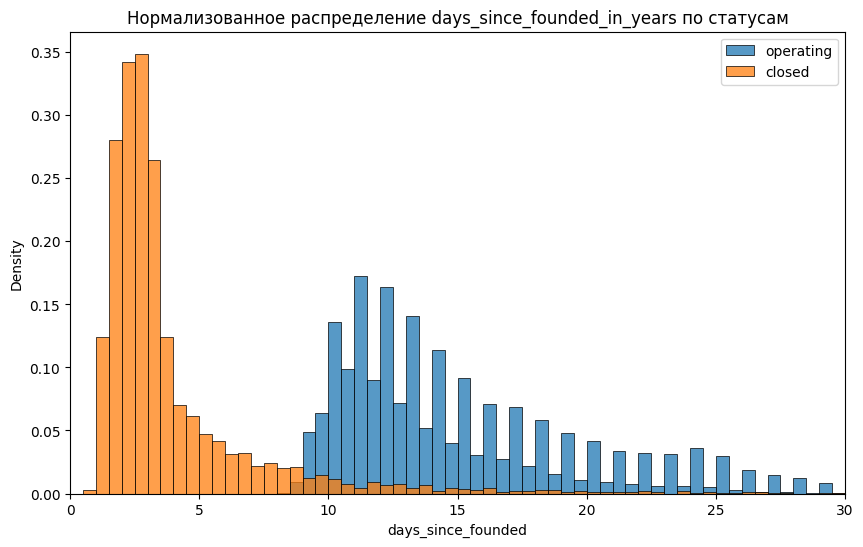

In [ ]:
feature = 'days_since_founded'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 30)
plt.show()


Из графика видно, что средний возраст компаний, находящихся в стадии **"operating"**, составляет **16.07 лет**, а медиана (середина распределения) равна **13.60 лет**. Это означает, что большинство долгоживущих компаний имеют возраст около 13-14 лет.

С другой стороны, компании, которые **закрылись** (статус **"closed"**), имеют существенно меньший средний возраст – всего **4.20 лет**, а медиана составляет **2.85 лет**. Это указывает на то, что большинство закрытых компаний существовали менее 3 лет.

**Выводы**
1. **Стабильность**: Инвесторы могут обратить внимание на компании, которые успешно функционируют уже долгое время. Высокий средний возраст может свидетельствовать о стабильности и надежности таких компаний.
2. **Риски**: Стартапы и молодые компании (с меньшим возрастом) могут представлять более высокие риски. Однако они также могут обладать большим потенциалом для роста и инноваций.
3. **Индивидуальный анализ**: Инвесторам следует дополнительно изучить каждую компанию, учитывая не только возраст, но и другие факторы, такие как отрасль, финансовое состояние, руководство и стратегия.

Статус: operating, Среднее: 3.54, Медиана: 1.45
Статус: closed, Среднее: 2.21, Медиана: 1.15


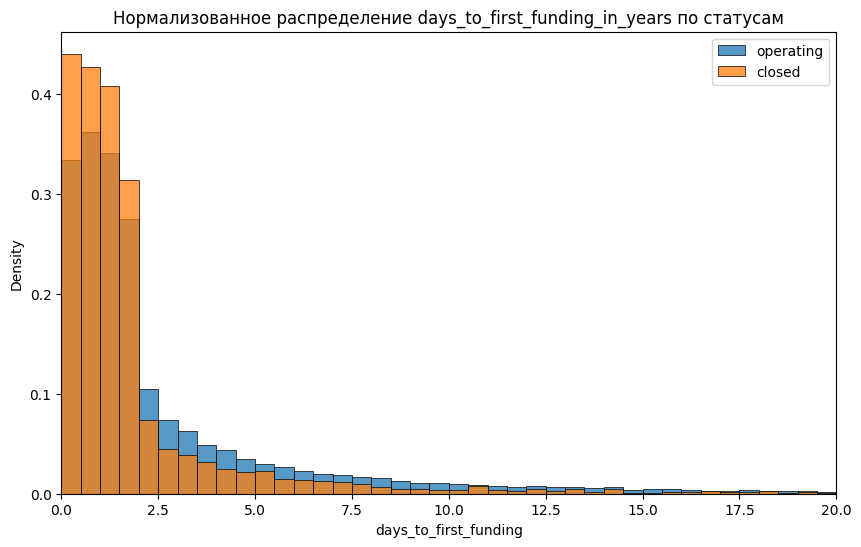

In [ ]:
#до первого финансирования (days_to_first_funding):
feature = 'days_to_first_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 20)
plt.show()


Из графика видно, что среднее время до первого финансирования для стартапов, которые **продолжают работать (operating)**, составляет **3.54 года**, а медианное время - **1.45 года**. Для **закрытых (closed)** стартапов среднее время составляет **2.21 года**, а медианное - **1.15 года**.

**Вывод:**
- Скорость получения финансирования не является фактором, влияющим на долгосрочный успех стартапа.
- Важно учитывать другие факторы, такие как бизнес-модель, команда, рыночные условия и уникальное предложение продукта.

Статус: operating, Среднее: 11.57, Медиана: 10.45
Статус: closed, Среднее: 1.48, Медиана: 1.48


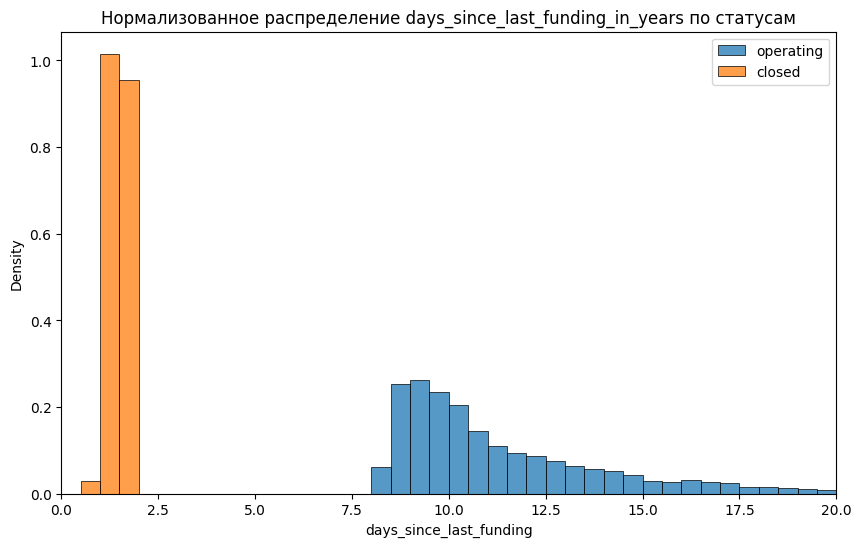

In [ ]:
#с момента последнего финансирования (days_since_last_funding):
feature = 'days_since_last_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 20)
plt.show()


Из графика и данных видно, что среднее время с момента последнего финансирования для **стартапов, которые продолжают свою деятельность (operating)**, составляет **11.57 лет**, а медианное время - **10.45 лет**. С другой стороны, **стартапы, которые закрылись (closed)**, имеют среднее время **1.48 года** и медианное время также **1.48 года**.

**Вывод:** Если стартап просуществовал **больше 2х лет** с момента получения последнего финансирования, это может свидетельствовать о его **более успешной** деятельности.

Статус: operating, Среднее: 0.96, Медиана: 0.00
Статус: closed, Среднее: 0.51, Медиана: 0.00


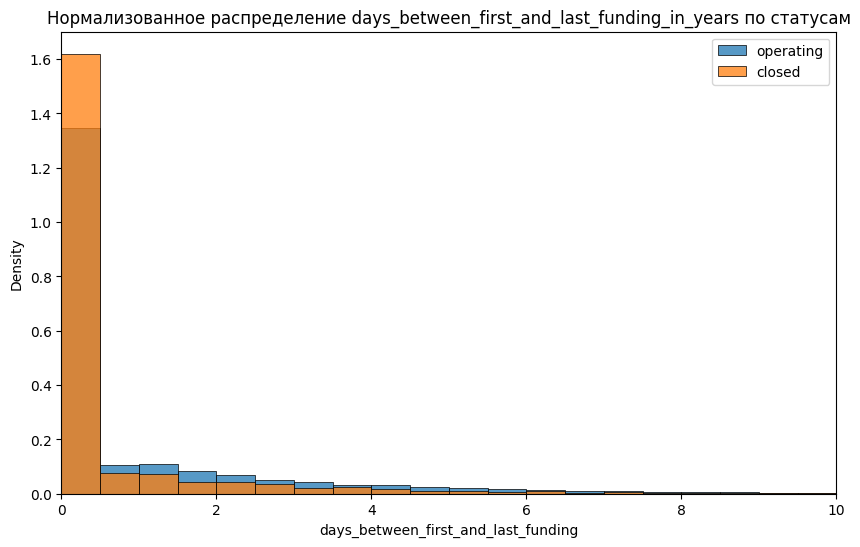

In [ ]:
#между первым и последним финансированием (days_between_first_and_last_funding):
feature = 'days_between_first_and_last_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 10)
plt.show()


Из анализа данных о промежутках между первым и последним финансированием можно сделать следующие выводы для инвесторов:

1. **Среднее время между финансированиями**:
   - Для компаний со статусом **"operating"** (действующих) составляет **почти год (0.96 года)**.
   - Для компаний со статусом **"closed"** (закрытых) составляет **полгода (0.51 года)**.

2. **Медианное время между финансированиями**:
   - Для обоих статусов (действующих и закрытых) **составляет 0 года**.
   - Это означает, что **чаще всего компании получают финансирование всего один раз**.

Инвесторам следует учитывать эту информацию при принятии решений о вложении средств в стартапы. Важно понимать, что длительные интервалы между финансированиями могут свидетельствовать о стабильности компании, а краткие интервалы могут указывать на меньшую стабильность.

Статус: operating, Среднее: 12.53, Медиана: 11.49
Статус: closed, Среднее: 1.98, Медиана: 1.60


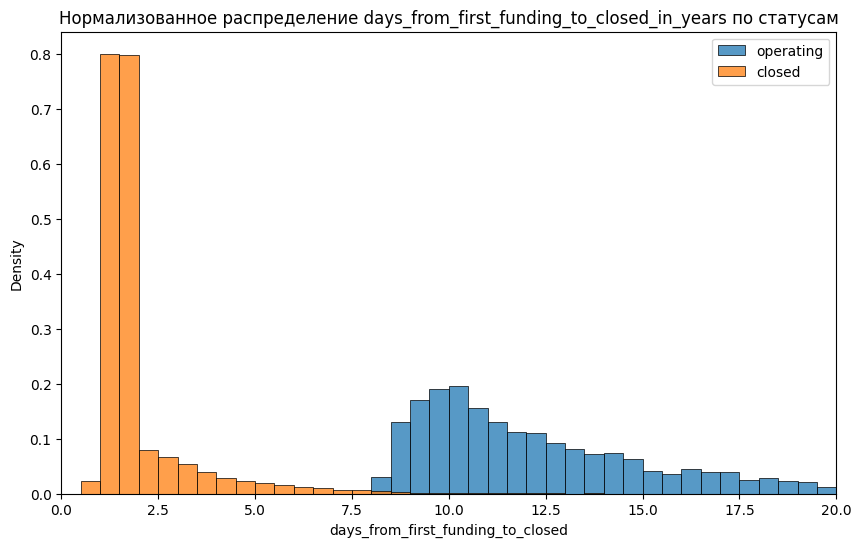

In [ ]:
#с момента первого финансирования до закрытия (days_from_first_funding_to_closed):
feature = 'days_from_first_funding_to_closed'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 20)  # ограничиваем ось x первыми 50 годами
plt.show()


Из полученных данных видно, что среднее время с момента первого финансирования до закрытия или текущего дня для **действующих компаний** составляет **12.53 лет**, а медианное значение - **11.49 лет**. Это говорит о том, что большинство действующих компаний продолжают функционировать более 11 лет после получения первого финансирования.

С другой стороны, для **закрытых компаний** среднее время с момента первого финансирования до закрытия составляет **1.98 лет**, а медианное значение - **1.60 лет**. Это указывает на то, что большинство компаний закрываются в течение 1.6 лет после получения первого финансирования.

Эти данные подчеркивают важность **долгосрочного финансирования** и **устойчивого бизнес-планирования** для выживания и успеха компаний. Они также могут служить предупреждением для инвесторов о потенциальных рисках, связанных с инвестициями в стартапы.

## Общий вывод

Анализ стартапов показывает, что успех и устойчивость компании зависят от множества факторов. Отрасль, география, возраст компании, количество и объем финансирования, а также время между раундами финансирования - все это играет важную роль.

**Отрасли**: Биотехнологии и программное обеспечение являются перспективными областями с высоким процентом успешных стартапов.

**География**: США и Великобритания лидируют по количеству успешных стартапов, что делает их привлекательными для инвесторов.

**Возраст компании**: Большинство действующих компаний продолжают функционировать более 11 лет после получения первого финансирования, в то время как большинство закрытых компаний существовали менее 3 лет.

**Финансирование**: Скорость получения финансирования не является фактором, влияющим на долгосрочный успех стартапа. Однако длительные интервалы между финансированиями могут свидетельствовать о стабильности компании, а краткие интервалы могут указывать на меньшую стабильность.

Важно помнить, что эти данные являются обобщенными и не могут гарантировать успех или неудачу конкретного стартапа. Каждый стартап уникален и требует индивидуального подхода. Инвесторам следует дополнительно изучить каждую компанию, учитывая не только эти факторы, но и другие аспекты, такие как бизнес-модель, команда, рыночные условия и уникальное предложение продукта. 

В заключение, инвестиции в стартапы могут быть рискованными, но они также могут принести значительную отдачу. Главное - делать обоснованные и обдуманные решения. 🚀

# Корреляционный анализ признаков

interval columns not set, guessing: ['name', 'category_list', 'funding_total_usd', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'funding_per_round', 'days_since_founded', 'days_to_first_funding', 'days_since_last_funding', 'days_between_first_and_last_funding', 'days_from_first_funding_to_closed']


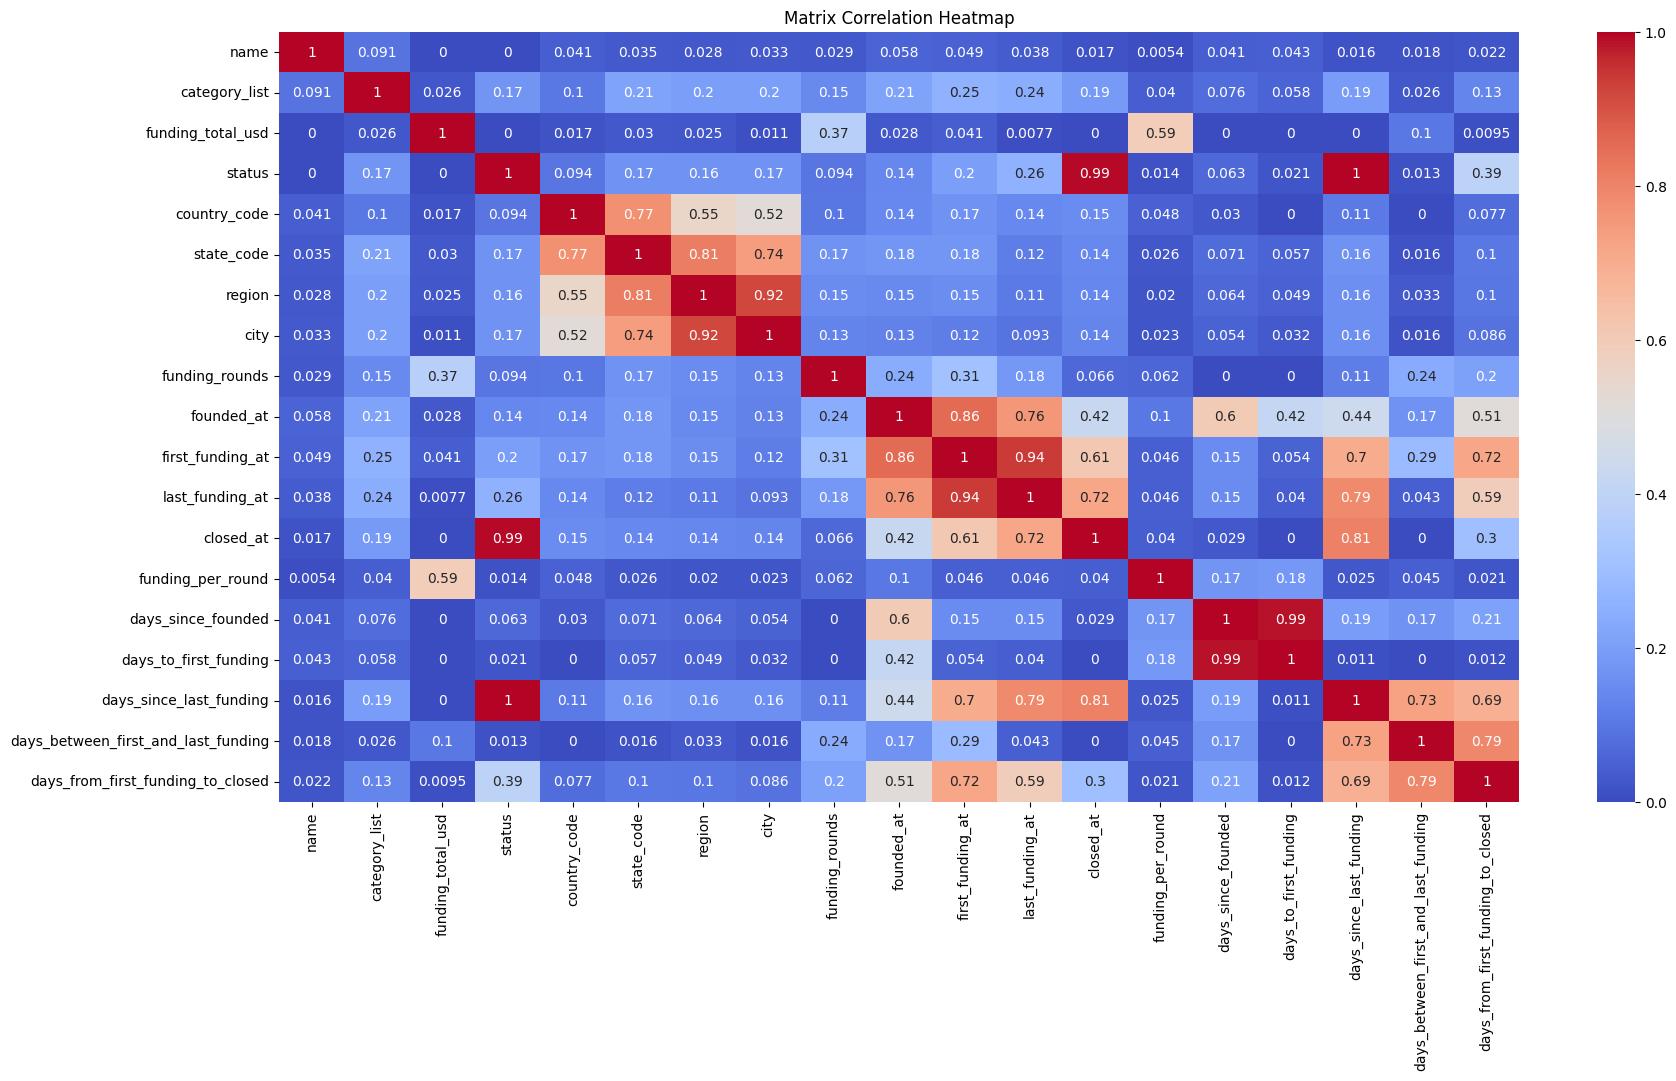

In [ ]:
# Создаем копию DataFrame
df_encoded = df.copy()

# Проходим по каждому столбцу в DataFrame
for column in df_encoded.columns:
    # Если тип данных столбца является object или datetime, кодируем его
    if df_encoded[column].dtype == 'object' or df_encoded[column].dtype == 'datetime64[ns]':
        label_encoder = LabelEncoder()
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    
# Вычисляем матрицу корреляции phik
correlation_matrix = df_encoded.phik_matrix()

# Визуализируем матрицу корреляции
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Matrix Correlation Heatmap')
plt.show()


In [ ]:
correlation_matrix

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round,days_since_founded,days_to_first_funding,days_since_last_funding,days_between_first_and_last_funding,days_from_first_funding_to_closed
name,1.000000,0.091267,0.000000,0.000000,0.040731,0.034898,0.028262,0.032525,0.028897,0.057731,0.049431,0.038201,0.017026,0.005437,0.040998,0.042977,0.015781,0.017960,0.021505
category_list,0.091267,1.000000,0.025501,0.174293,0.103164,0.213291,0.201842,0.200239,0.145870,0.214708,0.254153,0.244375,0.188684,0.039602,0.075540,0.057857,0.193789,0.026173,0.134048
funding_total_usd,0.000000,0.025501,1.000000,0.000000,0.017132,0.030416,0.025221,0.010729,0.373209,0.028029,0.040963,0.007681,0.000000,0.592994,0.000000,0.000000,0.000000,0.103297,0.009463
status,0.000000,0.174293,0.000000,1.000000,0.094204,0.165506,0.164633,0.167237,0.094488,0.137135,0.201302,0.261666,0.993920,0.013850,0.062661,0.021044,1.000000,0.012577,0.389905
country_code,0.040731,0.103164,0.017132,0.094204,1.000000,0.771616,0.554156,0.517875,0.101066,0.141245,0.169026,0.141284,0.149390,0.047646,0.029502,0.000000,0.107428,0.000000,0.077305
state_code,0.034898,0.213291,0.030416,0.165506,0.771616,1.000000,0.814445,0.741707,0.169272,0.179516,0.177430,0.115465,0.141738,0.025746,0.071176,0.056588,0.164210,0.015732,0.104511
region,0.028262,0.201842,0.025221,0.164633,0.554156,0.814445,1.000000,0.921540,0.151120,0.147366,0.153764,0.108023,0.138069,0.020087,0.063526,0.049057,0.160041,0.033123,0.101512
city,0.032525,0.200239,0.010729,0.167237,0.517875,0.741707,0.921540,1.000000,0.129752,0.125758,0.115982,0.093477,0.135765,0.023270,0.054090,0.032491,0.159534,0.015884,0.086377
funding_rounds,0.028897,0.145870,0.373209,0.094488,0.101066,0.169272,0.151120,0.129752,1.000000,0.239884,0.310393,0.181479,0.065736,0.062458,0.000000,0.000000,0.114159,0.237049,0.203599
founded_at,0.057731,0.214708,0.028029,0.137135,0.141245,0.179516,0.147366,0.125758,0.239884,1.000000,0.855348,0.757010,0.423950,0.102816,0.600602,0.416849,0.442452,0.168303,0.513158


В результате анализа корреляции признаков было обнаружено, что некоторые из них демонстрируют высокую мультиколлинеарность. Это может привести к проблемам в оценке коэффициентов модели, поскольку они могут стать неустойчивыми и трудными для интерпретации.

Чтобы устранить эту проблему, я решил удалить следующие признаки: **'founded_at'**, **'closed_at'**, **'first_funding_at'**, **'last_funding_at'**, **'days_to_first_funding'**, **'days_since_last_funding'**, и **'region'**. Это позволит улучшить качество модели, уменьшив мультиколлинеарность между признаками.

Важно отметить, что удаление признаков - это один из способов борьбы с мультиколлинеарностью. В зависимости от конкретной ситуации, могут быть использованы и другие методы, такие как регуляризация или преобразование признаков. Однако в данном случае удаление признаков кажется наиболее подходящим решением.

# Устранение мультикорреляции

In [ ]:
def drop_features(dataframes, features_to_drop):
    for df in dataframes:
        df.drop(features_to_drop, axis=1, inplace=True)

# Список признаков для удаления
features_to_drop = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'days_to_first_funding', 'days_since_last_funding', 'region']

# Применяем функцию к df и df_test
drop_features([df, df_test], features_to_drop)


interval columns not set, guessing: ['name', 'category_list', 'funding_total_usd', 'status', 'country_code', 'state_code', 'city', 'funding_rounds', 'funding_per_round', 'days_since_founded', 'days_between_first_and_last_funding', 'days_from_first_funding_to_closed']


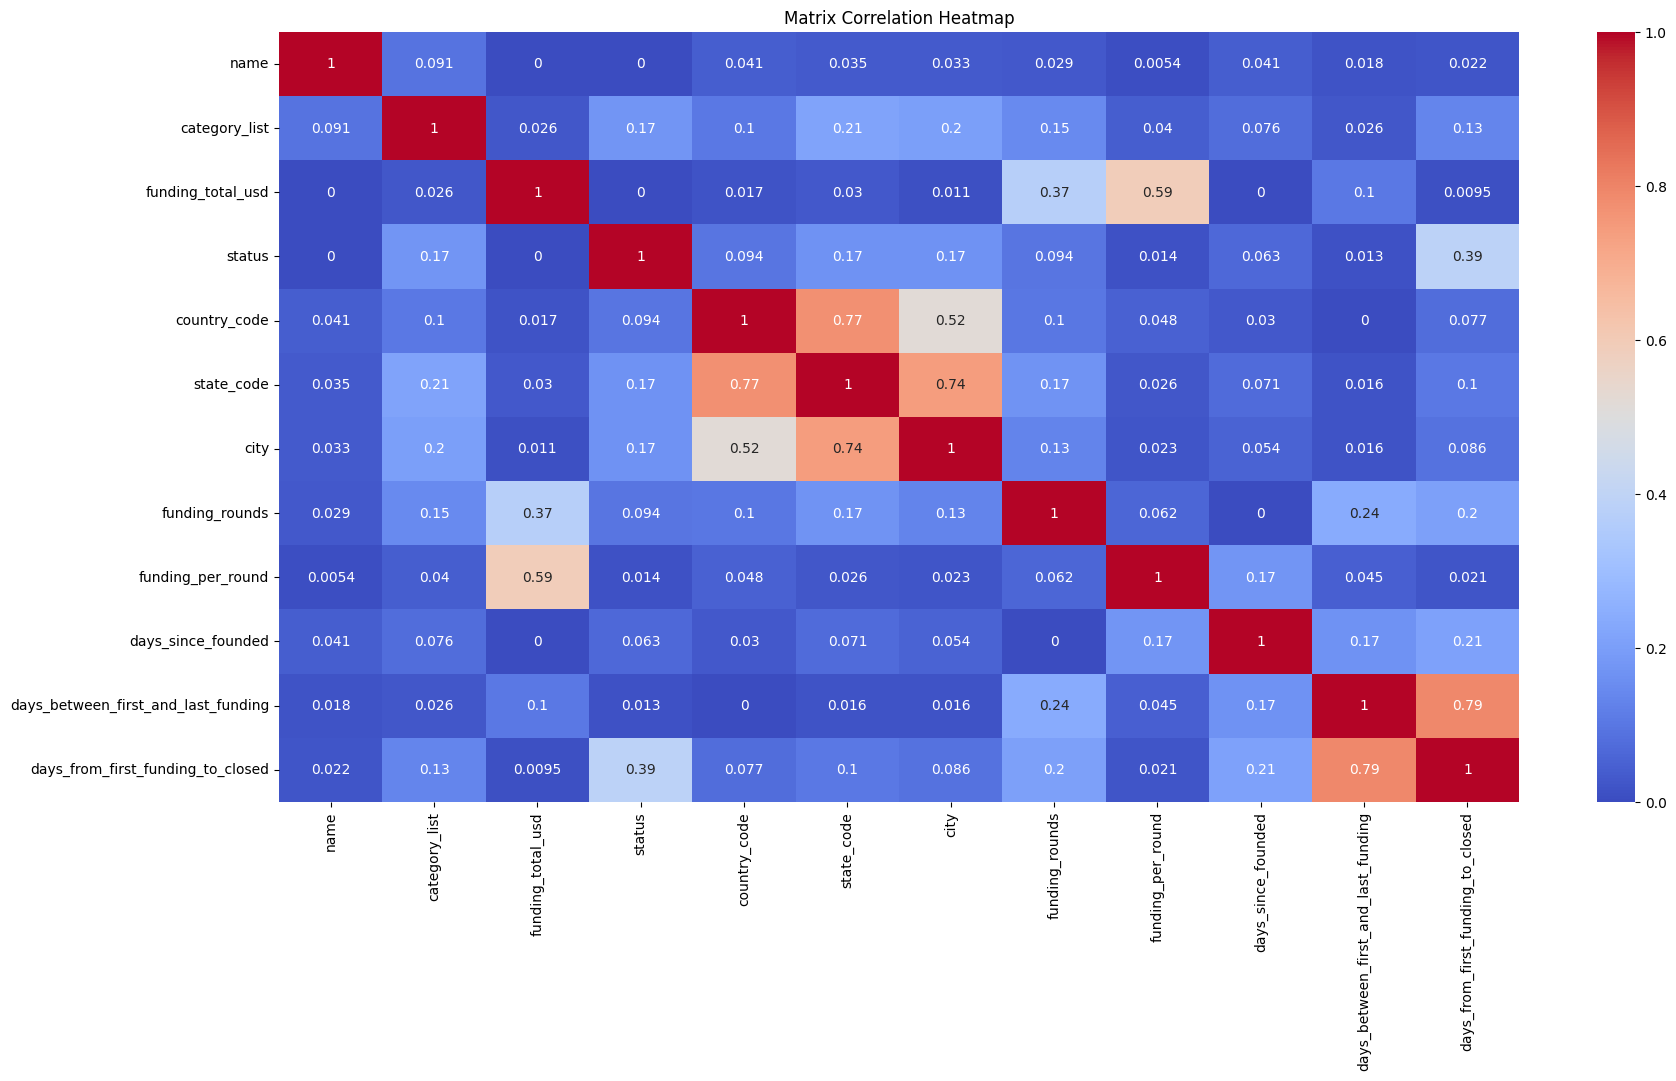

In [ ]:
# Создаем копию DataFrame
df_encoded = df.copy()

# Проходим по каждому столбцу в DataFrame
for column in df_encoded.columns:
    # Если тип данных столбца является object или datetime, кодируем его
    if df_encoded[column].dtype == 'object' or df_encoded[column].dtype == 'datetime64[ns]':
        label_encoder = LabelEncoder()
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    
# Вычисляем матрицу корреляции phik
correlation_matrix = df_encoded.phik_matrix()

# Визуализируем матрицу корреляции
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Matrix Correlation Heatmap')
plt.show()


# Подготовка признаков


## Сделаем синтезирование признаков, кодирование и масштабирование признаков в Pipiline

In [ ]:
# Преобразование столбца 'status' и сохранение в отдельной переменной
target = df['status'].map({'operating': 1, 'closed': 0})
df = df.drop('status', axis=1)
def create_polynomial_features(df, degree=2):
    numeric_features = df.select_dtypes(include=[np.number])
    for column in numeric_features.columns:
        for deg in range(2, degree+1):
            df[f'{column}^{deg}'] = df[column] ** deg
    return df
df = create_polynomial_features(df)
df_test = create_polynomial_features(df_test)



In [ ]:

# Разделение данных на тренировочные и тестовые
x_train, x_test, target_train, target_test = train_test_split(df, target, test_size=0.2, random_state=13)

# Определение числовых и категориальных столбцов
numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

# Создание пайплайна для кодирования категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('ordinal', OneHotEncoder(drop='first', sparse_output=False))
])
# создаём общий пайплайн для подготовки данных
    
preprocessor = ColumnTransformer(
    [
        ('ohe', categorical_transformer, categorical_features),
        ('num', MinMaxScaler(), numeric_features)
    ], 
    remainder='passthrough'
)


# Далее следует код для создания моделей, пайплайна и подбора параметров

In [ ]:
preprocessor 

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 Index(['name', 'category_list', 'country_code', 'state_code', 'city'], dtype='object')),
                                ('num', MinMaxScaler(),
                                 Index(['funding_total_usd', 'funding_rounds', 'funding_per_round',
       'days_since_founded', 'days_between_first_and_last_funding',
       'days_from_first_funding_to_closed', 'funding_total_usd^2',
       'funding_rounds^2', 'funding_per_round^2', 'days_since_founded^2',
       'days_between_first_and_last_funding^2',
       'days_from_first_funding_to_closed^2'],
      dtype='object'))])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49874 entries, 0 to 49873
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   name                                   49874 non-null  object 
 1   category_list                          49874 non-null  object 
 2   funding_total_usd                      49874 non-null  float64
 3   country_code                           49874 non-null  object 
 4   state_code                             49874 non-null  object 
 5   city                                   49874 non-null  object 
 6   funding_rounds                         49874 non-null  int64  
 7   funding_per_round                      49874 non-null  float64
 8   days_since_founded                     49874 non-null  int64  
 9   days_between_first_and_last_funding    49874 non-null  int64  
 10  days_from_first_funding_to_closed      49874 non-null  int64  
 11  fu

In [ ]:
# создаем список словарей для каждой модели
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=13)],
        'model__max_depth': range(2,10),
        'model__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier()     
    {
        'model': [KNeighborsClassifier()],        
        'model__n_neighbors': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']    
    },
# словарь для модели LogisticRegression()    
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=13)],
        'model__C': range(1,5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']  
    },

    # словарь для модели SVC()
    {
        'model': [SVC(probability=True, random_state=13)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}
]

# Создание пайплайна для подбора моделей и масштабировщика
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', 'passthrough')])

# Создание объекта GridSearchCV с метрикой f1
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Подбор параметров с помощью GridSearchCV
grid_search.fit(x_train, target_train)

C:\Users\ivano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan n

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         Index(['name', 'category_list', 'country_code', 'state_code', 'city'], dtype='object')),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         Index(['funding_total_usd', 'funding_rounds', 'funding_per_round',
       'days_since...
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'model': [LogisticRegression(penalty='l1',
                                                       random_state=13,
                                                       solver='liblinear')],
                          'model__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'model': [SVC(probability=True, random_state=13)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='f1')

In [ ]:
# Вывод параметров лучшей модели
best_params = grid_search.best_params_
print("Лучшие параметры: ", best_params)

# Вывод метрики лучшей модели
best_score = grid_search.best_score_
print("Лучшая метрика f1: ", best_score)


Лучшие параметры:  {'model': DecisionTreeClassifier(random_state=13), 'model__max_depth': 2, 'model__max_features': 2, 'preprocessor__num': StandardScaler()}
Лучшая метрика f1:  nan


In [ ]:
# Предсказание на тестовых данных
target_pred = grid_search.predict(x_test)

# Вычисление общей метрики f1
f1 = f1_score(target_test, target_pred, average='weighted')
print("Общая метрика f1: ", f1)

# Вычисление и вывод метрики f1 для каждого класса
report = classification_report(target_test, target_pred, target_names=['closed', 'operating'])
print(report)

ValueError: Found unknown categories ['iec electronics', 'seventh continent', 'topfun', 'gi joes', 'fintonic', 'creoptix', 'torrent systems', 'metapop inc', 'distractify', 'rapidapi', 'easycare', 'corsa technology', 'carbon3d', 'trueability', 'promotesocial', 'procuresafe', 'plex', 'savvy', 'vetpronto', 'infodif', 'wistla', 'ensphere solutions', 'trade beam holding inc', 'viadeo', 'tk20', 'vii network', 'equitynet', 'multiphoton optics gmbh', 'doyles fabrication', 'delias', 'acucela', 'rentmarket  marketplace for renting things and services', 'cupick', 'lumific', 'channel m', 'buildlinks', 'tokutek', 'vialogy', 'bos better online solutions', 'onetag', 'millennium laboratories', 'nqyer', 'tenksolar', 'usens', 'solus scientific solutions', 'cilk arts', 'naturebridge', 'esilicon', 'healthiest employer', 'zip2airport', 'estimeet', 'iprocure', 'tunitas therapeutics', 'vaska technologies', 'accessory addict society', 'amidebio', 'lamppost', 'paradox technology solutions', 'codepen', 'jelly button games', 'goformz', 'bbk worldwide', 'kemia', 'vtm', 'safemedia', 'zergnet', 'growlife', 'geeyee', 'toomga', 'ceraphin entertainment', 'appy pie', 'irx reminder', 'pollfish', 'sutro health', 'tcho', 'timbuktu labs', 'phobious', 'fanxchange', 'vaddio', 'fiberlink', 'linearhub', 'rivermeadow software', 'entvantagedx', 'facetime communications inc', 'mytable restaurant reservations', 'fresh ', 'jakks pacific', 'brandkids', 'operable', 'salmedix inc', 'hotalot', 'datria systems', 'headsprout', 'mokhaorigin', 'milibris', 'when you wish', 'janalakshmi', 'her', 'pump audio', 'rfeyed', 'paperwoven', 'synchroneuron', 'organigram', 'uncollege', 'geosatis', 'impresspages', 'pixelhome', 'north shore innoventures', 'alteer', 'spirometrix', 'videoo', 'spaceship', 'materia', 'ecs federal', 'medivision', 'lvmama', 'avanan', 'united maps', 'new relic', 'building robotics', 'altimet', 'ipierian', 'moprise', 'mezziainc', 'surebooks', 'companion canine', 'datarose', 'show de ingressos', 'tegotech software', 'camino real', 'culture machine', 'secude international', 'hiq labs', 'punchh', 'timesys corporation', 'enjoei p', 'cyberarts', 'impossible software', 'chumbuggycom', 'vmovier', 'enterra solutions', '159com', 'iliant', 'flite lite', 'village power finance', 'going my way', 'lumera corporation', 'korner', 'fluxband', 'angiogenex', 'jobpartners', 'reflexion network solutions', 'pharmaco dynamics research', 'aplazame', 'passo', 'a little easier recovery', 'simple mills', 'veleza', 'asiansbooktm', 'revolutionary concepts', 'owlogue', 'miname', 'oxitone medical', 'tarari', 'cloudalize', 'helixbind', 'quantum immunologics', 'search million culture', 'incentient', 'freakout', 'cast iron systems', 'bidmodo', 'decisive', 'worldapp', 'codemedia', 'skyscraper', 'concept red', 'color kinetics incorporated', 'hive social media management', 'clarassance', 'archive systems', 'netspeed systems', 'amusing quest', 'cambridge broadband networks', 'digital china information technology services company', 'marketcast', 'iqumulus', 'theater venture group', 'superfly', 'digital clipboard', 'audiencefm', 'monroe hospital', 'rigel', 'hopsoft', 'cpacket networks', 'nurulize inc', 'energy management  security solutions', 'allshoppings', 'exosite', 'incontact', 'videocodes', 'synqera', 'domzdrowiapl', 'ridibooks', 'bitdefender', 'socore energy', 'indiaevercom', 'snippit media inc', 'viewfinder', 'tecnoblu', 'bernal films', 'dita exchange', 'introniche', 'orm designer', 'pinpoint md', 'imanin', 'viva dengi', 'carepredict', 'avtodoria', 'cs products', 'rubicor medical', 'starforce technologies', 'chaologix', 'worksteadyio', 'kwick clean and green', 'anagear', 'axenic dental', 'clearleap', 'loc troi group', 'professional aptitude council', 'zappedy', 'echogen power systems', 'lifeio', 'joongel', 'lincoln peak partners', 'achievor corporation', 'nsc', 'yuepu sifang', 'energy innovations', 'fabrication games', 'konnectagain', 'a10 networks', 'helphive', 'tensegrity technologies', 'transpera', 'crowdplat', 'hullabalu', 'thengine co', 'runalong', 'stitch labs', 'tractable', 'hipages group', 'unsilo', 'cellectricon', 'questli', 'affinity labs', 'coramaze technologies', 'eco wave power', 'beijing tiertime technology', 'focusmotion', 'wikimedia foundation', 'breezometer', 'flatora', 'baker oil  gas', 'geekmaistercom', 'nprogress', 'bee there llc', 'quantified care', 'eyeducation', 'open door counseling', 'songkick', 'selflettingcom', 'xueda education group', 'orkney', 'appboy', 'avamar technologies', 'lightspan inc', 'rapidlea', 'innotech solar', 'agriliciouscom', 'locqus', 'almondy', 'foremost', 'infinity pharmaceuticals', 'american pet care corporation', 'blue diamond technologies', 'c4x discovery', 'leverton gmbh', 'compubank', 'graphene frontiers', 'voxware', 'bitpagos', 'philadelphia school partnership', 'cash check card', 'engim', 'talksession', 'conarrative', 'sidewire', 'tipd off', 'puma biotechnology', 'oohlala mobile', 'talentsoft', 'f6s', 'app in the air', 'wunderflats', 'clipkit', 'h2scan', 'keibi technologies', 'greenleaf book group', 'a pooches pleasure', 'gamma basics', 'invoiceasap', 'confianet', 'quickcomm software solutions', 'adomos', 'ufeast corporation', 'gigoptix', 'thin battery technologies', 'tut systems', 'circle', 'adaptive shooting sports', 't4 media', 'tropical beverages', 'penblade', 'blockboard', 'verge genomics', 'ubanquity', 'bankierpl', 'dailydeal', 'wigwag', 'lectorati', '37coins', 'shopography', 'gorest software', 'help me rent magazine', 'starcount', 'milk', 'justrite manufacturing', 'poundwishes inc', 'namedepotcom', 'iota computing', 'brandark', 'the manly man can', 'oco', 'stickyboard', 'tuneup', 'coursenetworking', 'photorank', 'solidware', 'telera', 'hoccer', 'pitop', 'nediyorcom', 'openexchange', 'spreedly', 'ceres', 'society of cable telecommunications engineers scte', 'redox', 'crowdzu', 'clickscanshare', 'sutro biopharma', 'bluesprig', 'the infatuation', 'afab solutions', 'nibirutech limited', 'merger nexus', 'mirovia networks', 'klinche inc', 'imalogix', 'decolarcom', 'przeswietlpl', 'boulder imaging', 'knyttan', 'ideaxis', 'open box technologies', 'transinsight', 'apt opinion', 'this week in', 'nexverse networks', 'blue vigil', 'steelhouse', 'anagog', 'agrimap', 'radiotopia', 'vinobo', 'pfi acquisition', 'alung technologies', 'arden reed', 'naow', 'passado', 'artaic', 'soxiable', 'green energy options', 'bpesa', 'lashoucom', 'endymion', 'luv rink', 'bloxr', 'skylable', 'mobile security software', 'experifun', 'liveoak technologies', 'eckard recovery services', '24 hour pro muscle gym', 'lv sensors', 'key research', 'insikt ventures', 'qpick', 'plusmo', 'civicscience', 'cara therapeutics', 'survela', 'door of clubs', 'flux inc', 'compliance assurance', 'team interval', 'technospin', 'curacao', 'bellwave co', 'propagenix', 'first care clinics', 'nouvou inc', 'cascade financial technology corp', 'antesy', 'forhealth technologies', 'continuum health alliance', 'triomed innovations', 'kyriba japan', 'mesuro', 'ho services', 'vital farms', 'iamba networks', 'commercializetv ctv', 'viki', 'pintics', 'blaze dfm', 'ginzametrics', 'restopolis', 'kenguru', 'defend your head', 'dashbook', 'travelbuddy', 'lemon curve', '3keyit', 'avidence', 'loopster', 'neah power systems', 'heyzap', 'luxanova', 'zvooq', 'sientra', 'bitmaker labs', 'tech urself', 'neurologica', 'homecanvasr', 'boxfish', 'geddit', 'ubicom', 'cognitive code', 'aqarmap', 'aminostream', 'warply', 'magnises', 'awox', 'kingdom scene endeavors', 'genability', 'videoavatars', 'intelliber', 'tagmoment', 'bepretty', 'made of genes', 'wet electrics', 'ncs multistage', 'topigen pharmaceuticals', 'zenticket', 'compose', 'playcoin entertainment', 'dragon tail', 'disarmco', 'sociogramics', 'cacco inc', 'internet marketing inc', 'accordent technologies', 'payformance holding', 'baxano surgical', 'vaioni', 'fyber', 'faballey', 'building blocks cre', 'argo', 'ddx media', 'fora', 'nexeon', 'lemonade', 'codiscope', 'awareability', 'crowdsync', 'smart surgical', 'innovation fuels', 'fogger', 'apsara therapeutics', 'perfect escapes', 'hope foods', 'luvo formerly flashnotes', 'innov analysis systems', 'revv', 'duogou', 'mom made foods', 'skedo', 'kurzomaniecz  coursemaniaeu', 'landpoint', 'cinvolve', 'posmetrics', 'traetelocom', 'powervision', 'nasseo', 'fincon', 'versartis', 'finale desserts', 'scryer', 'kinsa', 'hesiodo', 'svh24de', 'trademob', 'medical port', 'netcipia', 'rabbit', 'apptegy', 'omniflow', 'chenavari investment managers', 'talkplus', 'qiro', 'nupremis', 'metaforic', 'self care catalysts', 'hello parent', 'monscierge', '8digits', 'yakaz', 'cosmos labs', 'picocandy', 'conjur', 'reclaims', 'miottech', 'arkex', 'lucends', 'advitech', 'libratax', 'amniolife', 'lattis surgical', 'realty compass', 'deskom', 'proventix systems', 'zuman', 'avalon pharmaceuticals', 'sherpa assistant', 'icertis', 'yoogaia', 'critical signal technologies', 'stylitics', 'seewhy', 'paylocity', 'ebotic', 'tek travels', 'tableau', 'iencuentra', 'reachable', 'ignidata', 'ship supply international', 'socialpandas', 'tattoodo', 'zetland', 'ekspertaslt', 'profitek', 'virdocs software', 'red carrots studio', 'idream career', 'scio health analytics', 'diagnostic hybrids', 'nobex technologies', 'semadic', 'cherrish', 'integra health management', 'defixo', 'wegush', 'mdbio foundation', 'reqqi', 'chesapeake therapeutics', 'nico', 'imagescan inc', 'shift messenger', 'green biologics', 'union college', 'element works', 'transferto', 'onepin', 'tessemaes all natural', 'talentpuzzle', 'peckforton pharmaceuticals', 'snapcar', 'okanjo', 'doctors together', 'br supply', 'pcd partners', 'reviewspotter', 'carparts technologies', 'vollee', 'poppin', 'cellcontrol', 'berkeley design automation', 'packetworx', 'jz clothing and cosplay design', 'spraingo', 'legalreach', 'latina media ventures llc', 'gear4musiccom', '3nder', 'hypr', 'yeti data', 'citifyd', 'boomapp', 'erms corporation', 'senior wellness solutions', 'novopyxis', 'helius medical technologies', 'data sentry solutions', 'gudog', 'adama innovations', 'transluminal technologies', 'moko', 'sakkini', 'springr', 'magicblox', 'kymeta', 'pairin', 'crowdcando', 'freecharge', 'xmetrics', 'giraffe friend', 'geolearning', 'medlinker', 'streamload', 'care1 urgent care', 'big fish', 'grubhub', 'voicemod sl', 'ipxi', 'superpedestrian', 'medigo', 'vision source', 'gusto technologies', '24med sp', 'foresight biotherapeutics', 'successnexuscom', 'el telon', 'kartme', 'numberfour', 'lightspeed', 'bizware', 'shelters4homeless', 'shenzhen haiya technology development', 'towona mobile tv media holding', 'worldpasskey', 'skillbridge', 'new seasons market', 'flimmer', 'ontodia', 'skytechnica framework', 'algisys', 'bandhappy', 'scaffold', 'drdoctor', 'hiwired', 'hammerhead', 'lamplight analytics', 'melstevia inc', 'celebration creation', 'block party suites', 'rubikloud', 'little red wagon technologies', 'tactile', 'evidanza', 'octoplus', 'altratech', 'milestone technologies', 'ulmart', 'itugo', 'wemontage', 'usd mint', 'eviagenics', 'televerde', 'songwhale', 'genmedica therapeutics', 'tag', 'luminescent technologies', 'ip communications', 'buzzfeed', 'solidmation', 'swapbox', '10x genomics', 'setup', 'ternpro', 'sharesdk', 'oncopeptides', 'resilinc', 'the gluten free gourmet', 'loggly', 'carecord', 'redsiren', 'zazom', 'modern message', 'healbe', 'ebuilder', 'kanbanize', 'homejab', 'courbanize', 'ivivi health sciences', 'ascent option', 'kaye group', 'pouring pounds', 'proquo', 'gogo fit', 'gm europe', 'contact at once', 'polimax', 'mycargossip', 'smartall', 'rivendell education company', 'brigates microelectronics', 'fullcube', 'ioniqa technologies', 'one hour translation', 'virtuos', 'orid', 'adored', 'tranzlogic', 'moe delo', 'national networkers association', 'pacific ag', 'medallion analytics software', 'cour pharmaceuticals development', 'pinchpoint', 'hengzhi', 'welterlen equity partners', 'peoples software company', 'perception point', 'forrst', 'imega', 'revily', 'goomzee', 'fishtrip', 'guestcrewcom', 'gen one cig', 'adflow health networks', 'zhiwo', 'udobu', 'acustom apparel', 'nanomaterials', 'clipmine', 'turnstar', 'homehero', 'nextsocial', 'newman infinite', 'purely proteins limited', 'elasticio', 'excellence4u', 'accella learning', 'one step solutions', 'swagsy', 'extend health', 'boundarymedical', 'meridian energy usa', 'shanghai synacast media', 'light up africa', 'datatorrent', 'wittyparrot', 'hardware club', 'doctoriya', 'electric mushroom llc', 'opinionlab', 'pronota', 'swan inc', 'trusthcs', 'avinity', 'shakti technology ventures', 'tergum', 'infiniu', 'magin', 'marginpoint', 'liquidnet', 'myla', 'zerotier inc', 'clipboard', 'cloudvelox', 'target media central', 'undesk', 'the pie piper', 'storemates', 'enstage', 'fuse universal', 'omicia', 'assurz', 'pplive inc', 'hipship', 'informaat', 'aoi medical', 'avidxchange', 'jive communications', 'netmanage', 'pld space', 'advizr', 'kinnser software', 'affinergy', 'meetmetix', 'cellvine', 'wsn systems', 'varthana', 'buystand', 'tears for life', 'ather energy', 'resonant vibes', 'skyonic', 'cyvera', 'livve', 'artandseek', 'coronado biosciences', 'quake labs', 'untold  telling the worlds stories', 'investment underground', 'actx', 'trakkies international', 'newco ls15', 'veset', 'paxvax', 'emcore', 'plant together', 'anvato', 'spill inc', 'burst media', 'toopher', 'hipsnip', 'semmle', 'redzone robotics', 'accept software', 'passbox', 'narrato', 'miramix', 'joyride auto community', 'asia pacific digital', 'broadcast international', 'voipswitch', 'train station brewery', 'firefly space systems', 'caarly', 'smartkem', 'particle 5', 'usarium', 'daisybill', 'toms shoes', 'brideasmart', 'steriome', 'st barths online', 'gulf states cryotherapy', 'metrekare', 'intranetscom', 'whitesmoke', 'cu appraisal services', 'vyteris', 'stackdriver', 'sbtv', 'shenzhen justtide technology', 'elo7', 'koolspan', 'guestdriven', 'enmotus', 'catch resources', 'stupil', 'sitecover', 'see your box', 'constant insight', 'tempmine', 'sopost', 'health options worldwide', 'dada', 'picmonkey', 'vehicle production group', 'persay', 'vantia therapeutics', 'actifio', 'metropia inc', 'miler', 'reservaturno', 'honest dollar', 'splittable', 'redigi', 'agilisys', 'stockholm interactive', 'zero one network international limited', 'kihon', 'varcity sports', 'forsight vision5', 'interactive investor', 'n42', 'bevy', 'lufthouse', 'fdo holdings', 'happy kidz', 'prophase labs', 'agile networks', 'kinamik data integrity', 'bratpackstyle llc', 'loginradius', 'greenko group', 'platypus craft', 'verosee', 'shanghai echinachem inc', 'endra', 'california gold corp', 'cityads media', 'zepp labs inc', 'genoa pharmaceuticals', 'onshape', 'blink logic', 'jaguar animal health', 'hive01', 'alphabet energy', 'ultivue', 'oy', 'cuil', 'edplace', 'liquid', 'study2gether', 'etcetera edutainment', 'ox media', 'tactotek', 'knowledge momentum', 'zocere', 'drone labs', 'commonweal housing', 'simio', 'protonmail', 'seas food cafe', 'silkstart', 'ingate systems', 'ultrasoc technologies', 'odk media', 'brand affinity technologies', 'mxp4', 'united mobile', 'rib club global', 'socialguide', 'elobina concept ab', 'greyorange', 'newbrandanalytics', 'integrata security', 'khush', 'revel touch', 'mosa records', 'mailsuite', 'gutcheck', 'ecomdash', 'indeni', 'agora shopping', 'rpi reischling press', 'eptica', 'haima ticketing', 'club venit', 'clh group', 'moneytis', 'woven inc', 'nano defense solutions', 'la nevera rojacom', 'quire', 'wiiiwaaa', 'imspex diagnostics', 'notesfirst', 'acco brands', 'wavemark', 'tlabs', 'taggs', 'filmdoo', 'blacksnowdk', 'via6', 'mompery', 'zuchem', 'kenta biotech', 'oasys water', 'snagfilms', 'greater works business serivces', 'diavibe', 'catercow', 'zeturf', 'wwa group', 'sinbad online travellers club', 'decipher', 'ipnexus', 'crunched', 'adhezion biomedical', 'xorpsource', 'medical note inc', 'breethe', '1mg', 'innovative metabolics', 'mpressinteractive', 'qwaq', 'pump aid', 'grafica en linea', 'fabzat', 'backboard', 'parexa', 'lex machina', '2u inc', 'syncro medical innovations', 'consorte media', 'casentric llc', 'vaycayhero', 'oti lumionics', 'aceva technologies', 'theravance biopharma', 'qompium', 'mycity4kids', 'peptivir', 'watch over me', 'roostwise inc', 'liverelay inc', 'e cubica', 'spodly', 'chamate', 'topme', 'viap', 'doostang', 'storage appliance corporation', 'diagnoseme', 'switchmate', 'the stormfire group', 'idoc24', 'hakka labs', 'klab', 'sellstage', 'semeantojacom', 'armourio  own your data', 'xingtone', 'trustteam', 'dolphin', 'swissray', 'virtual iron software', 'qobliq group', 'altherx pharmaceuticals', 'techpubs global', 'metasolv', 'ninchat', 'poler', 'altheadx', 'wantering', 'smartdrive systems', 'links global', 'la maison interiors', 'crowdprocess', 'bolster', 'weeworld', 'nephosity', 'effilogics technologies', 'parallel universe', 'youmiam', 'excalibur', 'adenosine therapeutics', 'miproto', 'callinize', 'abingdon health', 'pure digital technologies', 'neodiagnostix', 'sensible lender', 'double data', 'respondent records', 'singapore post', 'scalus', 'groupvisualio', 'neitui', 'cfengine', 'hdl therapeutics', 'reputationcom', 'generic media', 'recellular', 'acb india limited', 'indipharm', 'kiltr', 'bme community', 'event cardio group', 'barnacle', 'edgerocket inc', 'cell again', 'msg lithoglas', 'rotageek', 'eqal', 'solution dynamics group', 'power innovations', 'm squared films', 'trevi therapeutics', 'bluebee', 'abzena', 'artisan pharma', 'groupprice', 'uskape', 'carex sa', 'jotima', 'rareform', 'oxygen solutions', 'giftme', 'infopoint', 'peakdale molecular', 'pre diagnostics', 'ngrain', 'paradise corner', 'pricelock', '2heuresavant', 'kicksport', 'rdio', 'spring moves', 'earlyshares', 'powercard', 'kemeta', 'spiralcat', 'squaredout', 'chase federal bank', 'voicelayer', '7circles', 'biocatch', 'enable holdings', 'the restaurant zone', 'wibki', 'nsided', 'smarthires', 'zorilla research llc', 'playmotion', 'georama', '91app', 'qstream', 'csi protection', 'newtricious', 'wildfire korea', 'eyeverify', 'dr jerrys smooth move', 'c3nano', 'cyoptics', 'xikota devices', 'cloverpop', 'localmint', 'localize', 'medecins sans frontieres', 'drafted', 'inventcore', 'symbiont', 'novamin technology', 'spreadshirt', 'ampio pharmaceuticals', 'nurseliabilitycom', 'trusted hands network', 'tetragenetics', 'local funeral', 'waywearable', 'iorder fresh', 'mfuse', 'abracon', 'webpay', 'class6ix inc', 'soraa', 'contravir pharmaceuticals', 'nextprinciples', 'outfittery', 'nuhook', 'bandapp', 'awak', 'world wide sport of billiards', 'carbon digital', 'delouge', 'sleeperbot blitz studios', 'dadajoecom', 'medstory', 'appcoach', 'gemphones', 'skydox', 'the old reader', 'blueprint genetics', 'acne studios', 'sciencebite', 'tiipzcom', 'netdocuments', 'app tokyo co', 'neocis', 'vassol', 'the 5th quarter', 'triggmine', 'findline', 'magpower', 'glomeria therapeutics', 'crowdalbum', 'mobile labs', 'singular', 'c2c link', 'bad seed entertainment', 'moshi', 'kiwi semiconductor', 'shogether', 'kinestral technologies', 'alpine data labs', 'apollo endosurgery', 'euroscreen', 'u4ia games', 'codacy', 'qmagico', 'coupay', 'anystream', 'member savings program', 'stopandwalkcom', 'limtel', 'krake', 'squeegy', 'conformis', 'crowdfynd', 'mediaplatform', 'pollvaultr', 'octovis inc', 'upcloo', 'pacifica labs', 'healthyout', 'duda', 'lumigent technologies', 'qpd', 'funji', 'alps  meters', 'latina researchers network', 'tula technology', 'yapmo', 'archivas', 'palm', 'dna health corp', 'excelerarx', 'tangible cryptography', 'golden gate technology', 'intelius', 'inspire living', 'wolfpack chassis', 'togethera', 'karmasphere', 'clothing sites', 'rangespan', 'shopsocially', 'imply data', 'nxtv', 'east side endoscopy', 'board a boat', 'ledgerx', 'buildingsp inc', 'da relm collectibles', 'epharmix', 'ecobee', 'cleave biosciences', 'medic vision brain technologies', 'bitgold inc', 'youbei game', 'alina homecare', 'futurefly', 'lilianna spinal solutions', 'hellobit', 'icarsclub', 'sproutling', 'girly stuff', 'activate healthcare', 'aura biosciences', 'twitmusic', 'iactionable', 'creative market', 'safetyculture', 'attensity', 'iridigm display corporation', 'renovo', 'doormen', 'pint please', 'clearserve', 'formac pharmaceuticals', 'transcardiac therapeutics', 'ivaco rolling mills', 'venture med group', 'learndot', 'open home pro', 'vets first choice', 'xodis', 'sensibleself', 'swinktv', 'expeditus', 'trendkite', 'errplane', 'cloudfactory', 'good chow holdings', 'jaano', 'nwave technologies', 'obiwon', 'brandmaco', 'chrome river technologies', 'perfectsearch', 'eastside distilling', 'offerduniain', 'athletes performance gear', 'guroo', 'quindell', 'd2l', 'ventrus biosciences', 'koalametrics', 'hacking the president film partners', 'planbee', 'cetek corporation', 'theva', 'driveappeal', 'exert co', 'global exchange technologies', 'thirdmotion', 'melanie clark communications', 'unbound technologies', 'ambassador uni', 'avion labs llc', 'bubble gum interactive', 'parsimotion', 'venuemob', 'soluto', 'skimlinks', 'sova', 'jodange', 'polystream', 'kosmos biotherapeutics', 'safertaxi', 'healthcare interactive', 'buyvip', 'zinka logistics', 'krillion', 'pyron solar', 'kitchen stories', 'proteopure', 'visto', 'usentric', 'cardiac concepts', 'augmedix', 'rentmetrics', 'vgulp', 'salesportal', 'pharmedium healthcare', 'applied nanomaterials', 'takeawaycom', 'yeti group', 'mpay gateway', 'the finance scholar', 'trace live network', 'imusictweet', 'sowetrip', 'carbon recycling international', 'interviewed', 'the business of fashion', 'genocea biosciences', 'episerver', 'curbedcom', 'vigilos', 'readypulse', 'scottish  newcastle plc', 'msilica', 'cardialen', 'edcaliber', 'yellow pages', 'geometwatch', 'play for', 'mathzee', 'beijing yiyang huizhi technology', 'bridge semiconductor', 'scpharmaceuticals', 'lets rent', 'resinate corporation', 'statuspath', 'jobindex', 'rally software', 'skipjump', 'fundthrough', 'oohly', 'lakehawk technologies', 'zentrick', 'beqom', 'zebra medical vision ltd', 'rivalroo', 'rsquared', 'flipswap', 'western pca clinics', 'realscout', 'summitour', 'indabox', 'staples', 'paysur', 'watchsend', 'rage in the cage', 'soloc', 'netia sa', 'ycharts', 'whistletalk', 'sonatype', 'mojio', 'codestreet', 'kse', 'overleaf', 'arbor pharmaceuticals', 'izicap', 'blazemeter', 'kivun hadash', 'ioculi', 'fmi international', 'cherry', 'netscreen technologies', 'lobster', 'allmobilize', 'mytrnd', 'buru buru', 'watercluster', 'in the chat communications', 'findthatlead', 'lightcyber', 'zoomcare', 'peer60', 'logicnow', 'vindicia', 'jamdat mobile', 'taplytics', 'jixee', 'qian xiaoer', '720deg', 'dxupclose', 'fatboy labs', 'fortumo', 'viamericas', 'mashworx', 'strawpay', 'evil city blues', 'cynapsus therapeutics', 'simeio solutions', 'ingeniatrics', 'access psychiatry solutions', 'olista', 'nutrabolt', 'eroi', 'farb guidance systems inc', 'shavelogic', 'buzzstream', 'machine safety manangement', 'jobr', 'advanced currents corporation', 'first to file', 'iceweb', 'ikonisys', 'boardvitals', 'keybase', 'peak environmental consulting', 'graphenea', 'zapp feedback pte ltd', 'memorymerge', 'alephcloud systems', 'anthem vault', 'meta data analytics 360', 'alchemy learning', 'akimbo', 'return path', 'pharaohshis place', 'outsell', 'applect learning systems pvt ltd', 'clonect solutions', 'hiconversionru', '100ecom', 'efounders', 'stormpath', 'tastykhana', 'wayra', 'suncore', 'cuvva', 'p  t', 'crusader vapor', 'intermed discovery', 'starr life sciences', 'kpa', 'capillary technologies', 'silarus therapeutics', 'logmaticio', 'needl', 'kadenze', 'marketocracy', 'overtime media', 'insikt inc', 'hchb cressey', 'linkyt', 'the allstate corporation', 'instantmarketing', 'guidance solutions', 'oneevent technologies', 'novacyt', 'rotohog', 'airbrite', 'carewell urgent care', 'clean air power', 'fusebill', 'dragon wealth', 'zando', 'objectvideo', 'mint bills', 'demografies', 'valon lasers', 'imusician', 'makersqr', 'opentrade', 'pano logic', 'oklahoma biorefining corporation', 'code42', 'palerra inc', 'otelic', 'ilumi solutions', 'visgo therapeutics', 'mirror42', 'technovax', 'training advisor', 'winneroo', 'modumetal', 'benchling', 'predictifyme', 'aranex biotech', 'fort sanders west', '3dvista', 'g2mobility', 'getvu', 'gis cloud', 'slurp smoothie and juice bars', 'integrys assetpoint', 'itsalat international', 'wepress app', 'vyclone', 'iepub', 'gridpotential', 'dinnertime', 'machineparty', 'venuenext', 'alchip', 'interviu me', '3leaf', 'toothpick', 'motionid technologies', 'sulia', 'clickcue', 'toxic attire', 'stublisher', 'open labs', 'choremonster', 'sephure', 'spark diagnostics', 'surface oncology', 'ip unity', 'richard pauer  3p', 'astrum solar', 'esoft', 'epicpledge', 'amplimed corporation', 'twistlock', 'brain tunnelgenix technologies', 'mashable', 'daily pic', 'spinnaker biosciences', 'plexxi', 'contact solutions', 'tenbu technologies', 'image engine design', 'fiberspar', 'botem', 'praxcell', 'breadtrip', 'digital harbor', 'soupio', 'oportunista', 'the athlete empire', 'afid therapeutics', 'princeton power systeminc', 'lift session', 'hyperlite mountain gear', 'ironnet cybersecurity', 'videobot limited', 'tracktik', 'bongiovi medical  health technologies', 'kids note', 'distil networks', 'spectel', 'personal blackbox', 'calixar', 'parica', 'holachef', 'eunetworks group limited', 'gamesalad', 'rumgr', 'beevibes', 'join the players', 'stormpins', 'finstripe', 'iqtaxi inc', 'personal factory', 'future simple', 'poka inc', 'yulex', 'ziften technologies', 'insticator', 'playyon', 'rechannel', 'bizreach', 'entegrion', 'rewardsforce', 'dreamscloud', 'horam vr', 'quero frete', 'democracycom', 'pear analytics', 'mwater', 'oriental cambridge education group', 'the history project', 'vista fitness', 'sidekick games', 'navitor pharmaceuticals', 'geneius', 'promotious', 'mbeat media', 'hamilton thorne', 'qunb', 'merrill technologies group', 'alumnize', 'resale therapy', 'powervault', 'dejour energy', 'heirloom technology inc', 'dibsie', 'megvii inc', 'dax asparna', 'rodeco ict services', 'parkey', 'metrarc', 'selectron', 'clarity technologies', 'sailsquare', 'yi chang ou sai it', 'gi dynamics', 'miiicasa', 'apitope', 'jobssycom', 'eyetechcare', 'andrew michaels ltd', 'cv ingenuity', 'planspot', 'maximum throughput', 'green farms energy', 'clinc', 'ocean power technologies', 'the urban roosters', 'marinus pharmaceuticals', 'qumu', 'wearable security', 'carbon38', 'airborne', 'thoughtbuzz', 'response networks', 'indinero', 'cobook', 'united villages inc', 'utility management solutions ums', 'favevy', 'edserv softsystems', 'miroi', 'wearable intelligence', 'flexreceipts', 'thinktanknet', 'zengame Shan You Ke Ji ', 'ch4e', 'pinkberry', 'wowza media systems', 'bringme', 'cityzenith', 'ai exchange', 'kove', 'beyond credentials', 'wireless toyz', 'space holding', 'biw technologies', 'autoesl', 'revelens', 'north american scientific', 'jogglebug', 'segone inc', 'greenlightguru', 'pandodaily', 'moberg derma', 'brightinfo', 'caribbean beach bar', 'keystone rv company', 'zeel', 'contentmartin', 'dash electric', 'entone technologies', 'invidi technologies', 'ipop networks', 'taggle ca corporation', 'monnier freres', 'klir technologies', 'top rops', 'fimmic', 'hilltop connections', 'ns studio', 'fisoc', 'flow', 'sportscstr', 'zooplus', 'zignals', 'netminions', 'viralninjas', 'artklikk', 'peakit', 'alaunacom', 'ideeli', 'edcourage', 'who can fix my car', 'fruux', 'visixtwo ltd', 'whoknows', 'sipx', 'appreciation engine', 'wangyou', 'synergy pharmaceuticals', 'strangeloop networks', 'populusorg', 'upmysport', 'joblocal', 'rapid diagnostek', 'blue yonder', 'santen pharmaceutical', 'select uniforms', 'newtron', 'modelinia', 'once upon a time', 'voddler', 'kingsbridge risk solutions', 'andera', 'digital reef', 'vubooo', 'nex', 'saltlick labs', 'xplore technologies', 'hotpotato media', 'messagemind', 'project hifi', 'earth class mail', 'netrepid', 'jumpstart wireless corporation', 'wrightspeed', 'bizanytime', 'forum technologies', 'avolon holdings', 'momspot', 'pfsweb', 'weezimcom', 'skillpixels', 'shoutomatic', 'sirnaomics', 'circle medical', 'igobubble', 'hometica', 'wywy', 'pidefarma', 'startcapps', 'placeiq', 'computer network solutions', 'kazeon', 'sentri', 'owneriq', 'unica', 'soupme', 'reviral', 'corevalue software', 'wirate', 'primesport', 'gohome', 'vidrunner', 'net power llc', 'motor vehicle software', 'super vitamin d', 'andean designs', 'chase pharmaceuticals', 'kenzei', 'subject company', 'tweet rocket', 'relatebook', 'mavatar', 'hms health', 'salorix', 'hadrian electrical engineering', 'bablic', 'mandata management  data services', 'nclc', 'mention mobile', 'relisen', 'cdnetworks', 'tu closet mi closet', 'agflow', 'tripgems', 'moodyo', 'herotainment', 'masala', 'angioscore', 'building successful teens', 'optizen labs', 'medical compression systems', 'southern dreams', 'whistler technologies', 'refocus group', 'local orbit', 'kionix', 'ipadio', 'futurlink', 'courseload', 'btc trip', 'interscope technologies', 'ahorro libre', 'misen', 'formafina', 'meiyou', 'basicocom', 'ultius', 'absolutely training', 'appzio  engaging experiences', 'fitonic ag', 'viverae', 'imvision software technologies ltd', 'method products', 's2c', 'vast systems technology', 'grocery shopping network', 'vettery', 'high brew coffee', 'tradetools fx', 'citystash holdings', 'buzzni', 'sirona biochem', 'royalty exchange', 'research for good', 'the netcommerce company', 'heyythere', 'worksimple', 'cloudtags', 'diarycom', 'polyview media', 'babajob', 'street by street solar', 'opez', 'spectraseis', 'newquest health solutions', 'healthwyse', 'legal logs', 'the better india', 'arcas entertainment', 'contenido', 'genshuixue', 'primus telecommunications group', 'cord blood registry', 'cotopaxi', 'meetingsense software', 'ofertaldia', 'tgv software', 'replicel life sciences', 'zady', 'wishkicker', 'treycent', 'vinuxpay', 'unfraud', 'eventbuilder', 'appmobi', 'stix games', 'syntarga', 'enlibrium', 'ruiyi', 'studentfunder', 'thinkature', 'arkivio', 'wherefor', 'foradian', 'marval pharma', 'kalyan jewellers', 'localtable', 'stacklead', 'incarda therapeutics', 'reddoorz', 'carcaddy', 'saltstack', 'vyatta', 'eventpig', 'elixserve', 'qingguo', 'entefy', 'sparklabkc', 'accelecare wound centers', 'cangrade', 'kericure', 'pushcall', 'tightknit llc', 'atsana semiconductor', 'antutu', 'melltoo', 'createtv inc', 'link to media', 'praditus', 'otogami', 'abakan', 'lendmed', 'kala pharmaceuticals', 'radrounds radiology network', 'egym', 'laxcom', 'traxens', 'beezik', 'talkyland', 'shippter', 'gigswiz', 'ribbit', 'segmint', 'safe shipping inspectors', 'plegma labs', 'anevia', 'fabrika online', 'geowaggle', 'mcginley innovations', 'punchbowl', 'lightbased technologies', 'undo software', 'spectrand', 'blubond', 'hermes innovation ltd', 'reqwip', 'appium technologies', 'bildero', 'exendis', 'evaluagent', 'parent co', 'chemocentryx', 'noteables inc', 'investup', 'mirage endoscopy center', 'quandora', 'leddartech', 'ctd holdings', 'cognisess', 'tablus', 'g10 entertainment', 'votify social voting app', 'studer group', 'synappio', 'casualing', 'vioptix', '19pay', 'apture', 'topopps', 'predictive technologies', 'axsome therapeutics', 'click quote save', 'multigig', 'sangart', 'boomerang pies', 'resource data', 'plx pharma', 'gemsco education', 'pipeliner crm', 'criteo', 'healthunity', 'fantaxico', 'parfemycz', 'nanoleaf', 'compressus', 'hydronovation', 'qualpay', 'embrella cardiovascular', 'skiappscom', 'rsvp law', 'qualys', 'acacia semiconductor', 'livinglens', 'vozeeme', 'keepskor', 'deepclass', 'kera', 'fabule', 'abpathfinder', 'oraya therapeutics', 'alliance health networks', 'summly', 'hirevue', 'sarantel', 'adenios', '365 good teacher', 'via novus', 'clipcall', 'clinical ink', 'bigtent design', 'marketsync', 'yieldmo', 'loco partners', 'ezmove', 'entreda', 'kintera', 'woofbert', 'yellowdog media', 'punch', 'universitynow', 'labournet', 'molome', 'bungee labs', 'si2 microsystems', 'imok', 'quiz the nation', 'independent space', 'toptal', 'snapjoy', 'agilum healthcare intelligence', 'independence resources management', 'hats off technology', 'digifun games', 'genetic technologies', 'tracksmith', 'dotted block', 'nexage', 'layered technologies', 'shanghai shipping freight exchange', 'tutti dynamics', 'progressa', 'venture infotek global private', 'cape productions', 'coskata', 'skynet technology international', 'fubotv', 'the fresh group', 'quantum technologies worldwide', 'local pass book', 'aros pharma', 'gamemix', 'achieve3000', 'raydiance', 'statwing', 'rexpest', 'boostup', 'logistics health', 'shapeup', 'tryolabs', 'opexa therapeutics', 'crs electronics', 'aventura', 'bernooli', 'inner chef', 'dnanexus', 'kintech lab', 'local corporation', 'orbital insight inc', 'chief trunk', 'stopthehacker', 'x2tv', 'if you can', 'alveolus', 'jonny iv', 'axiom microdevices', 'aquabling', 'revolution analytics', 'hiro media', 'rentomojo', 'click notices inc', 'vbrick systems inc', 'redhelper', 'rypos', 'njuice', 'feedo', 'seekpanda', 'myfox', 'intelliworks', 'dineintime', 'guiabolso', 'staila technologies', 'gainspeed', 'skyfutures', 'wondershare software', 'fifty100', 'youbeauty', 'torque therapeutics', 'saavn', 'oilfield anchor company', 'live better brands', 'american clinical solutions', 'kingdom kids academy', 'warwick warp', 'key travel', '42floors', 'global parimutuel services', 'next caller', 'redis labs', 'nevro', 'protrakr', 'p2p protect co', 'genesis networks', 'starcard', 'alces technology', 'greasebook', 'ubitexx', 'proalex', 'velicept therapeutics', 'cylene pharmaceuticals', 'alder biopharmaceuticals', 'piedmont bioproducts', 'clipsure', 'localcom', 'doctorc', 'liquid air lab', 'insightpool', 'millenium biologix', 'numa', 'chatads', 'jueshengcom', 'new matter', 'blueroads', 'aboutone', 'clinical research laboratories', 'pigafe', 'adello inc', 'nextmart', 'cybercity 3d inc', 'weaver express', 'heywire', 'accalio', 'hoopla', 'consensus orthopedics', 'fusion coolant systems', 'kv', 'expansion capital group', 'foodzai', 'dinndinn', 'vitasome', 'powered outcomes', 'tutored', 'perpetuuiti technosoft services', 'flip flop shopsr', 'dada room', 'xiant', 'thefriendmail', 'clique intelligence', 'boticca', 'glampinghubcom', 'aquarelle', 'tyco electronics group', 'buzz cloud', 'patsnap', 'proactive business solutions', 'baobab', 'combined effort', 'hiperos', 'hitbox entertainment gmbh', 'demdex', 'courseyard gmbh', 'forter', 'byus', 'social dental', 'rosa mexicano', 'delphi optics gmbh', 'vessel', 'jobs made easy', 'rise', 'wag', 'textpayme', 'cas medical systems', 'pango networks', 'icouch', 'vitals', 'mophie', 'epicentric', 'myjambi', 'pushkart', 'kenesto corp', 'intelligence node', 'modulis', 'sweetwater energy', 'eldr media', 'libox', 'versatel networks', 'leinentausch  leashswap', 'beam express', 'voiceplatecom', 'triggerfish animation studios', 'fattail', 'allozyne', 'mmis', 'xebialabs', 'streamz', 'faxto', 'qreserve inc', 'foodlo', 'relevance inc', 'candiag', 'apangea learning', 'health revenue assurance holdings', 'senet', 'studio sbv', 'sonora leather', 'responsebase', 'ubermedia', 'strapping', 'todocast tv', 'blinkbuggy', 'century maritime fund', 'pacific atlantic equity group', 'froodies gmbh', 'create intelligence', 'instaclique', 'skinkin', 'spacosa corp', 'blueoak resources', 'quanergy systems', 'recommind', 'lokataru', 'invenshure', 'cad best', 'wave technology solutions', 'eaglei music', 'practo', 'paragon bioservices', 'river vision development', '17zuoye', 'offersbyme', 'jogg', 'anydoor', 'myrio', 'digital music universe', 'mdvip', 'alexo therapeutics', 'bullguard', 'mylikes', 'advanced voice recognition systems', 'argus', 'jhl biotech', 'simplilearn', 'stypi', 'independent inspections', 'complete solar', 'uniservity', 'whois', 'insane logic', 'semequip', 'cardcashcom', 'hooray learning', 'clubr', 'broomstick productions', 'techwell', 'paieon', 'peerim', 'knowable', 'cristal therapeutics', 'affinaquest', 'viblio', 'mini exchange', 'lc stylecom', 'stockflare', 'dealbase corporation', 'elevation pharmaceuticals', 'fuzu', 'curely', 'ardian', 'suvaco', 'taplet', 'tomakis', 'avelist', 'windar photonics', 'getback', 'kiroo games', 'permabit technology corporation', 'engagio old', 'smytten', 'smith electric vehicles', 'myokardia', 'pongr', 'wificom', 'facio', 'picstash', 'mustsee guides', 'netuitive', 'voylla retail pvt ltd', 'urbanfarmers', 'wayger', 'pipette', 'carbonetworks', 'aspire', 'startupi', 'nodesource', 'datacratic', 'seascape health alliance', 'action products international', 'channelyst', 'optionsxpress', 'alpinereplay', 'xuanyixia', 'lynxfit', 'bobobobo', 'studyingto', 'advisorconnect', 'newcomlink', 'percsys', 'get holding nv', 'playfitness', 'smartrecruiters', 'endoluminal sciences', 'allurion technologies', 'wear', 'polymita technologies', 'captio', 'university of massachusetts medical school', 'tripleseat software', 'maipu communication', 'achilles group', 'empower microsystems', 'intelliquis international', 'amrit advanced biotech', 'openspace', 'enefpro', 'paperflies', 'credit faire', 'spokane therapist', 'instrumagic', 'hotlist', 'socialcoaster', 'blue health intelligencebhi', 'compropago', 'in2circle', 'carbon motors corporation', 'greenlight', 'gevity hr', 'eupraxia pharmaceuticals', 'teraphysics corporation', 'loyalize', 'rubicon media', 'rescale', 'papirus', 'casmul', '3d sports technology', 'constant care of colorado springs', 'playdata', 'paraengine', 'lifeimage', 'silverlink communications', 'evly', 'biz supplies', 'omni bioceutical innovations', 'mr presta', 'versity software', 'nebulus audio', 'codewars', 'togethersoft', 'red guru', 'reclickd', 'zenti', 'boardvantage', 'larcobaleno', 'coco controller', 'contorion', 'inzen studio', 'testobject', 'interliant', 'cartavi', 'voltaire', 'amarantus biosciences', 'sanifit', 'kira talent', 'american fiber systems', 'trailerpop', 'orgdot', 'the library bar  grille', 'yuuguu', 'insider guides', 'appfolio', 'flx micro', 'rockethome', 'infogain corporation', 'visitdays', 'membrane instruments and technology', 'uni2', 'labstreet', 'appsfire', 'discovery labs', 'kahoot', 'geotechnologies', 'mendeley', 'tenebril', 'mynextrun', 'homezada', 'dreamsaver enterprises', 'logiclibrary', 'ameritv', 'iwi', 'tagsys rfid group', 'casual steps', '3ware', 'boxcast', 'koubeicom', 'healthexpense inc', 'personal medsystems', 'datashield', 'agrobotics', 'yibaishopping', 'ionic', 'clinicbook', 'storypress', 'mediaxstream', 'shotclip', 'vetcloud', 'virent energy systems', 'cellartis', 'suven life sciences', 'totus solutions', 'global connection holdings', 'bespoke global', 'copyright agent', 'packetlight', 'spangle', 'joberate', '91datongcom', 'digital legends', 'bluebox', 'espark', 'vdi space', 'right shoes', 'fondu', 'buddha software', 'tresorit', 'dheere bolo', 'mtm technologies', 'double robotics', 'bookbarn international', 'intelcore technologies', 'startlocal', 'revpoint healthcare technologies', 'lensvector', 'livehousein', 'auxilium pharmaceuticals', 'the ratnakar bank', 'sendoid', 'famous industries', 'winningadvantage', 'montgomery financial', 'sportsfix', 'project 2020', 'rush bike', 'implisit', 'first solar', 'rostelecom', 'univercells', 'dating ring', 'limetonic', 'cervilenz', 'eviivo', 'zumobi', 'loopport', 'glaceau', 'esync networks', 'isagen', 'doctrackr', 'offerum', 'letv', 'revitas', 'docusys', 'loadspring solutions', 'inphase technologies', 'fox networks', 'svbio', 'vasca', 'the cambridge satchel company', 'kipcall', 'biocartis', 'unum therapeutics', 'general communication', 'yaptap inc', 'rendeevoo', 'trapeze networks', 'appzero', 'gofundme', 'weilos', 'three rivers natural resource holdings iii', 'areametrics', 'periscope data', 'designlab', 'crisolteq oy', 'transchip', 'analytics quotient', 'precise business group', 'satvacart', 'vibe solutions group', 'wind energy solutions', 'accela', 'pax global technology', 'biomedix vascular solution', 'bamboo system technology pte ltd', 'medtech solutions', 'eargo', 'accel diagnostics', 'netero', 'channelsoft beijing technology', 'launchups', 'world blender', 'lightscape materials', 'melon', 'eruditor group', 'canara', 'noodle play', 'verticalresponse', 'random array ltd', 'belanit', 'sierramaya360', 'june', 'applied spine technologies', 'food evolution', 'schoolguru', 'aliada', 'gestigon', 'tarsus medical', 'yestap', 'springdales school', 'chippmunk', 'lumi industries srl', 'marquee dental partners', 'alwaysupport', 'miro', 'ingenius engineering', 'nso group', 'core informatics', 'arctrieval', 'changelight', 'genia technologies', 'nangate', 'heylets', 'ininal', 'scriptrx', 'smart toy', 'jobble', 'voltaic coatings', 'pear deck', 'rocket foods', 'owlin', 'amaru', 'axiom', 'palmaz scientific', 'matchpin', 'sir kensingtons', 'iphighway', 'zenzui', 'crowdflow', 'rocket fiber', 'neural analytics', 'touristr', 'aegis surgical', 'mediafly', 'processclaims', 'alphaeon corporation', 'choozon dba blue kangaroo', 'algorithmics', 'cybrary', 'ioptics', 'rasyonel rd', 'major league gaming', 'id global solutions', 'altela', 'fanattac', 'grm internet', 'correx', 'asset marketing services', 'binder biomedical', 'boston therapeutics', 'avrupa minerals', 'symbiota', 'mar systems', 'upnext', 'telos', 'varsity news network', 'sankofa community development corporation', 'dering hall', 'tagapet', 'vivolux', 'shweeb', 'grandcentrix gmbh', 'netnuicom', 'writelab', 'glowbl', 'kumu networks', 'nativeenergy', 'tuul', 'serometrix', 'viralica', '7digital', 'peoplejar', 'sprint nextel', 'neos corporation', 'codeoscopic', 'bridgelux', 'tu fabrica de eventos', 'animal cell therapies', 'huupy', 'enecsys', 'offermint', 'jiangxi ldk solar hitech', 'alterpoint', 'epyon', 'cohesive technologies', 'asmacure ltee', 'kaymbu', 'enpirion', 'beckoncall', 'instabase', 'hashplay inc', 'soricimed', 'cybrata networks', 'otto clave', 'take  make', 'flexspot', 'fashiontrot', 'elabseurope', 'phemi health systems', 'bankerbay technologies', 'pathology holdings', 'vivense home  living', 'healthytweet', 'hid global', 'driblet labs llc', 'readwave', 'sefas innovation', 'ketech', 'wappa', 'cudasign', 'iee', 'maunuxa', 'intervention insights', 'co3 ventures', 'westhouse', 'cloudone', 'realeyes', 'thinkglue', 'semco engineering', 'emotion media', 'embue', 'next big sound', 'sugarhigh', 'primordial', 'reachli', 'opality', 'grosolar', 'real food blends', 'dubaki', 'digital global systems', 'denali medical', 'greendot trans', 'clickatell', 'indous solar', 'gipis', 'raze therapeutics', 'ultracell', 'testquest', 'covocative', 'cassatt', 'kiodex', 'nobot', 'neri', 'scil proteins', 'quantum leap packaging', 'talent clue', 'reaqta', 'airdale house leeds', 'up performa', 'mednet solutions', 'avelisbiotechcom', 'giftology', 'takasic', 'novelroots internet', 'portable zoo', 'digital vault', 'linkedin slideshare', 'implantable artificial kidney', 'aginfolink', 'sasetscom', 'verinata health', 'roberts tool company', 'vrai mobile limited', 'common interest communities', 'clover game studio', 'vegachi', 'smackhigh', 'connect financial software solutions', 'flocktag', 'polyremedy', 'victory park capital', 'nvdrones', 'sravel', 'pintley', 'bloxy', 'powermetal technologies', 'cloudadmin', 'medine', 'tcmc', 'the fizzback group', 'mendocino software', 'efabless corporation', 'wattics', 'rpm sustainable technologies', 'trunity', 'novel', 'farmlogs', 'performix technologies', 'local matters', 'skimatalk', 'biotiful', 'skitsanos automotive', 'digital authentication technologies', 'academy of inovation', 'bellabox', 'jfrog', 'swift biosciences', 'uat holdings', 'swagbucks', 'active dsp', 'precision io', 'ei technologies', 'axiomed spine', 'thoughtful movers', 'remotium', 'gowalla', 'self health network', 'iverify', 'happy bits company', 'konokopia', 'fabkids', 'mobileo', 'vascular biogenics ltd', 'lincoln paper and tissue', 'zumur', 'liveclubs', 'clarityad', 'dot legend', 'trading block', 'design ventures', 'vendscreen', 'influitive', 'buckete', 'employma', 'civo', 'sotera wireless', 'cloudacc', 'curverider', 'whistle', 'bidgely', 'giveffect', 'cloudius systems', 'brainwave education', 'painless1099', 'taulia', 'mogoroom', 'oriental rugs of bath', 'sellf', 'regenxbio', 'k2 media', 'echo automotive', 'authomate', 'txtfeedback', 'g2 microsystems', 'deja view concepts', 'jackson square group', 'ask the doctor', 'slimtrader', 'nest labs', 'crisis text line', 'postrank', 'eldervision', 'enverid', 'tms neurohealth centers tysons corner', 'qualysense', 'truedemand software', 'magellan bioscience group', 'pressenger', 'cs networks', 'bookingdirection', 'maxwest environmental systems', 'dangdangcom', 'microeval', 'optony', 'plaxd', 'worklight', 'videon central', 'enigma software productions', 'alt12 apps', 'webgen systems', 'smartvineyard', 'concil', 'the author hub', 'yourpovtv', 'ninu', 'vmturbo', 'teleborder', 'the roberts group', 'moto europa', 'viraloid', 'viva labs', 'northern power systems', 'musicplay analytics', 'decurate', 'zenradius', 'enumeral biomedical', 'hands company', 'api fortress', 'lsat freedom', 'virtuata', 'cm tecnologia', 'found eats', 'rent like a champion', 'numberpicture', 'umentioned', 'familyspaceru', 'united platform technologies', 'inurture', 'captivemotion', 'caipiaobao', 'groupflier', 'turing data', 'pinch media', 'sanovation', 'alayacare', 'creative gig', 'zound industries', 'skykick', 'bizily', 'osfam brewing', 'nuffer estates  investments', 'squad', 'greenvity communications', 'appharma', 'bragster', 'thrillist media group', 'id analytics', 'hubub', 'market2member', 'renovatio it solutions', 'datappraise', 'worklife', 'genially', '7 cups of tea', 'xco', 'yabbly', 'cympel', 'futuregen capital', 'luminal', 'boatflex', 'impactflo', 'ensight media', 'on the spot systems', 'trippy bandz', 'indextank', 'xbux', 'sms coupon', 'my true fit', 'ground up biosolutions', 'pulseon', 'veritainer', 'recro pharma inc', 'vringo', 'nykaa', 'guess your songs', 'acirro', 'cohere communications', 'canvs', '9facts', 'motorpaneer', 'travellution', 'halo computing', 'avocadotm', 'pointcare genomics', 'panton inc', 'gbooking', '1mind', 'pinpoint selling', 'omnidrive', 'gestsure', 'yakify', 'dualog', 'fluxxion', 'wideangle technologies', 'advaction', 'epiance', 'hometrax', 'nuday games', 'tapsense', 'trivnet', 'yogome', 'sanovas', 'reliant pharmaceuticals', 'sirigen', 'aerospike', 'bayfield court', 'barnebys  all auctions in one place', 'metgen', 'american medical supply', 'brightsky labs', 'pintail technologies', 'vpisystems', 'sci marketview', 'capriza', 'webcentrix', 'surgrx inc', 'booktrack', 'sofa labs', 'three screen games', 'full of fashion', 'quotify technology', 'carweez', 'metabolomic diagnostics', 'onesmile holdco', 'validity sensors', 'vmockcom', 'internet gold  golden lines', 'sensdata', 'a2t2', 'stitcherads', 'engrade', 'pigeonly', 'lucid colloids', 'chattermill', 'taskus', 'wildfang', 'working not working', 'mediatrove', 'coasttec', 'pulmorphix', 'maxlinear', 'qreativ studio', 'elite daily', 'xchange automotive', 'booking angel', 'aditi multimedia', 'client care solutions', 'braincheck', 'rosum', 'popbum', 'demerx', 'open road integrated media', 'aet holdings corp', 'weatherbug', 'hiper technology', 'transitive', 'guojia new materials', 'introbridge', 'nextpeer', 'scrypt inc', 'localo', 'bigzop', 'telller', 'drync', 'impres medical', 'swiss smile', 'optiscan biomedical', 'hashtip', 'coimbra genomics', 'sembraire', 'vengine', 'the smalls', 'homeostasis labs', 'cellaegis devices', 'flywheel software', 'lot78', 'lailaihui', 'fengguo network', 'cognitive health innovations', 'srj', 'internate machine corporation', 'canvita', 'nugen technologies', 'north american palladium', 'easy home solutions', 'xp investimentos', 'shophop', 'x5 group', 'fluxion biosciences', 'azteq mobile', 'textualads', 'orion seafood international', 'public mobile', 'venturepax', 'seamobile', 'itsdapper', 'ahmedabad business pages', 'cocodot', 'crunchbase', 'verge advisors', 'edgar online', 'farehelper', 'skift', 'inpa systems', 'prestosports', 'biodetego', 'apt pharmaceuticals', 'spares box', 'roll20', 'run my errands', 'atg access', 'noble environmental technologies', 'looop online', 'luxury fashion trade', 'urban ladder', 'umami', 'invibox', 'kidoz', 'easypoint', 'nicox', 'best before media', 'unruly', 'yogatribes', 'apr', 'earth biosciences', 'kptncook', 'numat technologies', 'zenovia digital exchange', 'a8 digital music', 'diagnostic photonics', 'cardomain network', 'litehouse', 'learn with homer', 'passhat', 'talaris', 'type22', 'avis', 'fishtree inc', 'qire', 'brigade corporation', 'orthogon systems', 'cytosolv', 'socialvolt', 'wordwatch', 'proxtome', 'wispry', 'the daily voice', 'zhenai', 'auditmark', 'flightrecorder inc', 'sonitus medical', 'deep domain', 'osper', 'strider', 'urbful', 'dronamics', 'kapitall', 'vigster', 'brightarch', 'crowd source capital ltd', 'roominate', 'everwrite', 'hana biosciences', 'driverside', 'snapcious', 'kettlepost', 'crackle', 'medicalis', 'all day media', 'car reviews', 'monroe capital', 'bapul', 'petbath america', 'ayoxxa biosystems', 'gdeslon', 'pro player connect', 'neptune software as', 'bitmap galaxy', 'joinup taxi', 'smartcanal', 'spitogatosgr', 'web digital', 'obeo', 'goodrich international', 'bel vino', 'yumbin', 'pavegen systems', 'otelzcom', 'rappler', 'infolinks', 'wasatch vaporstix', 'peacock parade', 'tbi connect', 'digital mines', 'project frog', 'showbucks', 'performance consulting group', 'mati energy', 'brownsburg pc 911', 'diskover', 'picrateme', 'makerist', 'american healthnet', 'green sulfcrete', 'zinc ahead', 'fyusion', 'tempo automation', 'aimeiwei', 'uchi navi', 'webinfinity', 'nuvilex', 'blueleaf', 'ldr holding', 'textual analytics solutions', 'selstor', 'hiheycom', 'tizra', 'beanstockd', 'subblime', 'in1001com', 'medigram', 'dimmi', 'truu mobile', 'bioheart', 'obvious', 'altitun', 'genetic internet', 'china fb', 'ideas britain', 'feedhenry', 'laura sapiens', 'prodrive', 'linear computer solutions', 'swan valley medical', 'plickers', 'matchfund', 'wyzetalk', 'covasoft', 'metacog inc', 'vigix', 'villagenetworks', 'volta industries', 'sobrr', 'data visualization software', 'centrality communications', 'synthetic genomics', 'altiris therapeutics', 'psyqic', 'peptherapy', 'databanq', 'cartup commerce', 'omnipaste', 'supenta', 'pigu group', 'isn solutions', 'weaveworks', 'sitime', 'reelyactive', 'pret dunion', 'zymr inc', 'relex', 'tinsly', 'lezu365', 'apexigen', 'sliced investing', 'ecircle', 'teseda corporation', 'roundbox', 'tinypass', 'zinkia', 'entitle', 'tripology', 'pivit', 'verifacto inc', 'themidgame', 'sooqini', 'cubeteam', 'farmstr', 'supporter', 'tamoco', 'proplan', 'xcloud', 'esphion', 'telormedix', 'sungard', 'kindful', 'infopia', 'uncover', 'kutpoint', 'reminiz', 'yuzu', 'bizon', 'prizemonsters', 'grofers', 'studyonboard', 'imperative networks', 'icontext', 'ubenxcom', 'nucana biomed', 'reveal technology', 'unity technologies', 'miora', 'luxsensor', 'coolclouds', 'acorda therapeutics', 'smartvel', 'unmanned marine solutions', 'b152', 'topivert', 'greenlight planet', 'neighbourly', 'vioozer', 'skyfiber', 'gecko audio', 'rewardloop', 'apollo media', 'noquo', 'buz', 'funding profiles', 'digital vision systems', 'voz', 'novalar pharmaceuticals', 'aethlon medical', 'fervent pharmaceuticals', 'clientscape', 'cyberark', 'higher admission', 'nuserv', 'tabula', 'estorian', 'intelligencebank', 'hungryroot', 'monteris medical', 'hackerearth', 'inishtech', 'yuqing electric', 'cuethink', 'implisense', 'welldoc', 'health languageinc', 'alltherooms', 'shopdeca', 'uspack logistics', 'squaremarket', 'mmetrics', 'estateguru', 'nanochip', 'performance werks racing', 'webmedx', 'exo labs', 'arctyc', 'spor chargers', 'cosmic color', 'engajer inc', 'id fresh food', 'rithmio', 'wise data media', 'realtime immersion rti', 'profitbricks', 'vtion wireless technology', 'trust digital', 'contros systems  solutions gmbh', 'yoone', 'stitches', 'core audio technology', 'clasemovil', 'custom control concepts', 'quintiq', 'coolr', 'uknow corporation', 'velpic', 'pantec biosolutions', 'spotfav reporting technologies', 'videoelephantcom', 'skybitz', 'aboutlife', 'yes bank', 'united skin specialists', 'tuva labs', 'minesio', 'beyondtrust', 'asoview inc', 'spineology', 'peekintoo', 'enflick', 'alter way', 'perpetuall', 'blue', 'mymusictaste', 'ican systems', 'cube route', 'apploi', 'coalign', 'wellaware systems', 'infoblox', 'spacio', 'bonuu loyalty', 'soceaniq', 'gtc systems', 'all copy products', 'success academy charter schools', 'bradford networks', 'tolerx', 'ebiquous', 'pxradia', 'open mhealth', 'razz', 'interface biologics inc', 'clear labs', 'mca solutions', 'quantivo', 'emerging technology center  etc', 'lumate', 'medhab', 'stipple', 'total boox', 'versura', 'breakthecratescom', 'arx', 'medivance', 'investingcom', 'gate technology', 'cyrium technologies', 'vibedeck', 'colovore', 'sitebrand', 'recargax', 'cocona', 'distributive networks', 'nyheter24gruppen', 'looxii', 'gt energy', 'maufait', 'readydock', 'assetmetrix corporation', 'origingps', 'torax medical', 'kentik', 'maplebear', 'greystripe', 'segundohogar', 'sfox', 'bioanalytical systems', 'luqa pharmaceuticals', 'cosmic forces', 'feedbackmachine', 'teak', 'cloudfloor', 'intouch technologies', 'flixwagon', '3 four 5 group', 'liquid health labs', 'vimicro international corporation', 'vmg health', 'altruik', 'ibaby labs', 'zhuhai omesoft', 'medialive', 'cybint', 'rendition networks', 'whittier street health center', 'foodbuzz', 'ap engines', 'vor data systems', 'houzz', 'pellet technology usa', 'arangodb', 'directr', 'songza', 'be sport', 'flamestower', 'answerdash', 'dnatrix', 'tbit sistemas', 'eyeball', 'entangled ventures', 'beleza na web', 'danforth pewterers', 'shook', 'dashthis', 'terracycle', 'manyeta', 'drexel university', 'rebls', 'neohapsis', 'eventdoo', 'syncrophi systems', 'craigsbluebook', 'gearmunk', 'tapcardpay systems', 'colomob network and technology', 'vycon', 'active implants', 'collaborne', 'panjiva', 'ironstar helsinki', 'accessbio', 'pandora web services', 'icrimefighter', 'symbiotix biotherapies', 'managestar', 'modewalk', 'go dish', 'wanderful media', 'geili giving', 'entelos', 'infina connect healthcare systems', 'mc10', 'instaedu', 'blackstone digital agency', 'alytics', 'timeet', 'whiskey media', 'rapidvalue solutions inc', 'pittsburgh iron oxides pirox', 'workpop', 'hundo', 'hydra dx', 'corso', 'amniochor', 'action for children', 'beach solutions', 'bouf', 'keldoc', 'whiskcom', 'seeqpod', 'glencoe software', 'moxiucom', 'fuelmyblog', 'open me', 'coquelux', 'bodymedia', 'digital news asia', 'makepolocom', 'mobile on services', 'accelerize new media', 'flatfox ag', 'xoinka', 'biorelix', 'zazuba', 'ssev', 'grade a sign  signon media', 'zmags', 'shaser', 'picoral', 'radeeus', 'kinderlab robotics', 'affordable selfstorage', 'lodestone social media', 'you chews', 'displair', 'foneshow', 'chuguobang', 'steadyserv technologies llc', 'morriscooke', 'zebra biologics', 'truclinic', 'mercaux', 'kiio', 'metrotech net', 'slicex', 'true north therapeutics', 'magic foto', 'sprinklr', 'silistix', 'extreme seo internet solutions', 'miyowa', 'health diagnostic laboratory', 'augmate', 'footprints childcare', 'greenland hong kong holdings limited', 'guangzhou metech', 'vocalizelocal', 'netboss technologies', 'led chemicals', 'web performance', 'axerion therapeutics', 'piper', 'daty', 'emotive', 'mindshare networks', 'segment', '3i systems', 'uhoo', 'moneta', 'sonoran financial services', 'endpoint clinical', 'joturl', 'soundtrack your brand', 'turbine analytics sa', 'nomad mobile guides', 'transposagen biopharmaceuticals', 'tigo energy', 'attributor', '5k fans', 'invenra', '2ngageu', 'meet my friends', 'popplaces', 'leapin digital keys', 'advanced in vitro cell technologies', 'adylitica', 'ebruncom', 'who', 'mymatrixx', 'pososhokru', 'mixify', 'jumpseller', 'mporium', 'aplos software', 'baro', 'emerging media', 'get licensed', 'opentabs', 'freeatm', 'thinglefin', 'vyu labs inc', 'moksha8 pharmaceuticals', 'white castle', 'aiko biotechnology', 'minerva neuroscience', 'anda', 'cortex healthcare', 'meilleursagentscom', 'windation', 'veriflow systems', 'glyde', 'rentcom', 'storsimple', 'bityota', 'medical cannabis payment solutions', 'curio', 'lasergen', 'streamsets', 'carbon objects', 'argyle data', 'momo networks', 'mbf therapeutics', 'archevos', 'acustream', 'roambi', 'outracks', 'integrated healing technologies', 'open services', 'altizon systems', 'keepfu', 'coupeez inc', 'spreesy', 'photoworks', 'mainspree', 'haemostatix', 'mizhecom', 'blue wheel technologies', 'cielo24', 'thedots', 'cloudy days', 'careflash', 'searchme', 'picasolar', 'artistoon', 'gray line of tennessee', 'rimidi', 'ideal me', 'exaptive', 'bbspace', 'bossa nova robotics inc', 'cycell', 'parkmycloud', 'callio technologies', 'sublime skinz', 'biteable', 'notion', 'ketera', 'ev3 inc', 'academy123', 'telefonica', 'met tech', 'finomial', 'moaec', 'the grid', 'sinohub', 'plink entertainment inc', 'canburg', 'oncore golf technology', 'seclingua inc', 'lion semiconductor inc', 'jobplanet', 'insequent', 'accipiter', 'cdi laboratories', 'servato corp', 'silicon frontline technology', 'occlutech', 'collegefrog', 'idleair', 'livevox', 'southern illinois university edwardsville', 'happier inc', 'vidpay', 'pharmacy tv network', 'sector111', 'aoptix technologies', 'home eat home', 'impossible objects', 'orangutrans', 'evolve ip', 'vanu coverage', 'cocunat', 'key forensic services', 'zennor petroleum', 'methylgene', 'health catalyst', 'espressi', 'thyme', 'kvault software', 'trema group', 'seraphim sense', 'keyview', 'simscale', 'dtco', 'ascentias', 'oesia', 'veritract', 'rivet  sway', 'sarbari', 'portfolium', 'mission critical electronics', 'visually', 'dianwoba', 'mystargo enterprises llc', 'senex biotechnology', 'benefitmall', 'nuelle', 'picloud', 'vizy', 'socialblood inc', 'liberation way', 'kcv loans', 'panscopic', 'eagle genomics', 'lifestreams', 'action engine', '2redbeans', 'source mdx', 'advanced imaging technologies', 'funinhand', 'telemedicine clinic', 'minicabster', 'rant network', 'ipdatatel', 'texus fibre', 'automd', 'polynetworks', 'raincrow studios', 'motionelements', 'streamago', '4plat', 'cardfree', 'xing', 'agorapulse', 'goworkabit', 'smart museum', 'kutuan', 'talentsignedtm', 'inline wireless', 'green a', 'carelinx', 'newstep networks', 'topcat research', 'read advertising group', 'yelp', 'moment', 'couple', 'qinti', 'canntrust', 'minitrade', 'flykly', 'zigabid', 'kitedesk', 'tiffs treats holdings', 'medicina', 'marbleshare', 'harbour antibodies', 'impossible foods', 'excorda', 'narsys mobile', 'workspace', 'access northeast', 'movable ink', 'newfield design', 'catacel', 'ellevation', 'fly now pay later', 'brightplanet', 'friscopl', 'serious business', 'cell medx', 'tradingview', 'passenger baggage xpress', 'walkmore acquired by gte financial', 'foldrx pharmaceuticals', 'gtess corp', 'gfi software', 'voiceup', 'biomode  biomolecular determination', 'chinacars', 'grand cru', 'guidesco', 'vivid technologies', 'aeromot', 'acal enterprise solutions', 'dots devices', 'balzo', 'turnstyle solutions', '1000museumscom', 'nmrkt', 'italia online', 'boxgard', 'efta energy', 'wutsat systems', 'localist', 'crowned grace international', 'noirilluminati', 'usabilla', 'silver peak', 'omniforce', 'acheevit', 'concilio networks', 'muse  co', 'shipzi', 'yikuaixiucom', 'cint', 'agilelaw', 'intraxio', 'american efficient', 'pulaski bank', 'cardflight', 'eneedo', 'origin healthcare solutions', 'trafficland', 'faction skis', 'microstim', 'avail media', 'supersonic imagine', 'record360', 'meineng energy', 'compute', 'professional logical solutions', 'binfire', 'mandoyo', 'lightminer systems', 'maidsafe', 'enuyguncom', 'dialedin', 'tablelist inc', 'vme media', 'softscope medical technologies', 'skimo tv', 'buzzstalker', 'joa oil  gas', 'innetwork', 'ahonya', 'bioniz', 'venture academy', 'goplanit', 'tweet category', 'iexplore', 'perseus', 'safedk', 'hillerich  bradsby', 'ultreo', 'rapid micro biosystems', 'seesawcom', 'iquest', 'testsoup', 'commerciant lp', 'ebindle inc', 'mic network', 'geeyuu', 'xunda pharmaceutical', 'pepper', 'achica', 'leafer', 'nanomix', 'dailylook', 'qeexo', 'food genius', 'cellara', 'tapactive', 'retronautco', 'nomesia', 'lumiata', 'foglaljorvost', 'hango', 'etaskit', 'kidshirt', 'rv wheelator', 'osix corp', 'sitebrains', 'emergent game technologies', 'hemophilia resources of america', 'kateeva', 'metaresolver', 'shades of green', 'gigi hill', 'glancenews', 'mobilesuites', 'engagio', 'socialmadesimple', 'fluoropharma', 'propiedad facil', 'waku waku Zhu Shi Hui She ', 'sensai corporation', 'ekotrope', 'phi optics', 'esight', 'avuxi', 'miarch', 'wanshen', 'bic science and technology', 'liases foras', 'or be square', 'invite media', 'flickr', 'abhinav outsourcings pvt ltd', 'venga', 'alibaba', 'assurecare', 'angel capital entrepreneurial fund', 'epic research  diagnostics', 'viacell', 'creative citizen', 'lotebox', 'tribr', 'nantbioscience', 'zeemitv', 'mobile embrace', 'envelop vr', 'jamorigin', 'loku', 'brandmaker', 'kromek', 'catglobe', 'critiqueit inc', 'terascala', 'familyskyline', 'dynamic wealth solutions llc', 'amalfi semiconductor', 'vidrocket', 'barspace', 'gura gear', 'springbok services', 'zonbo media', 'innobright technologies', 'wallept', 'qikpod', '58com', 'talentsprint educational services', 'socialcops', 'next health', 'city dining cards', 'josey ellis commercial real estate investments', 'voset architectural hardware', 'keystone insights inc', 'who is georges ', 'headtalk', 'waylens', 'pictourus', 'yeepay', 'sagebin', 'broadband national', 'rose window productions', 'chromance', 'kili', 'inkmonk', 'instilling values', 'xlerant', 'ridley', 'ripsaw apps', 'visiobox', 'preventicus gmbh', 'your pet chef', 'gadgetwood', 'mission product holdings', 'bitnet technologies', 'squirrel', 'network security technology', 'pocared diagnostics ltd', 'be great partners', 'stockal', 'nativis', 'inhabi', 'azuray technologies', 'ion trading', 'zurff', 'diabetica', 'digione company', 'dove', 'jibjab', 'oplerno', 'consolo services group', 'sublimemail', 'butcherbox', 'gradalis', 'pearlchainnet', 'valderm', '5gig', 'triphobo', 'xamcheck', 'lolalola', 'posh eyes', 'miaopai', 'scope 5', 'translatemedia', 'storygami', 'nunook interactive', 'mangofizz jobs', 'theranexus', 'golfdigg', 'fielding systems', 'promobucket', 'heptagon advanced micro optics', 'returbo', 'heppe medical chitosan', '2sms', 'antidot', 'koatum', 'imoji', 'affle', 'curtran', 'muzeek', 'cyberhawk innovations', 'exepron', 'invest in us today', 'softheon', 'cota', 'nibo', 'zeropluscom', 'jeeri neotech international', 'rohinni', 'chesspark', 'kingdee', 'pogoseat', 'fetchmob', 'shiram credit', 'ise corporation', 'gototel', 'affordable interior systems', 'wrap media', 'texas energy network', 'eduvant', 'sustain360 this company is no longer active', 'iterasi', 'learnbig', 'testroom gmbh', 'workerbee virtual assistants', 'helicomm', 'clearbridge accelerator', 'elistguy', 'digitrad communications', 'hyperchip', 'urbasolar', 'farmhouse delivery', 'cardstar', 'axial', 'workspot', 'viptable', 'subitec', 'aroundwire', 'zaldiva', 'go net systems', 'green revolution cooling', 'bitready', 'recruiteecom', 'clear water outdoor', 'day zero project', 'tivo', 'meteor network', 'made in w inc', 'sterigenics international', 'tekstream solutions', 'intendu', 'usable security systems', 'beijing cloud technologies', 'traplight games', 'aliopartis', 'hele massage', 'mapp', 'umano', 'invicta networks', 'space pencil', 'social bicycles', 'polarion software', 'bootleg market', 'wedo shopping', 'iiko', 'there corporation', 'literably', 'juupstore', 'apim therapeutics', 'virgil security', 'pulselocker', 'exalead', 'seven seas water', 'trifortinc', 'essence group holdings', 'loandepot', 'steadyfare', 'halon security', 'verge solutions', 'qpyn', 'examsoft worldwide', 'brainmass', 'citia', 'kanjoya', 'green blender', 'cereva networks', 'forks', 'levicept', 'monstrous', 'autogenie', 'stylebee', 'marrone bio innovations', 'kakkstati', 'fastcustomer', 'fandor', 'von media group', 'pinpay', 'ibex outdoor clothing', 'hotelzilla', 'xecced', 'fanswell', 'dcanty investments loans  services', 'ww communications', 'cogentus pharmaceuticals', 'taylor enterprises', 'metamason', 'isoco', 'global crossing', 'turbocoating', 'coinpayments', 'music intelligence solutions', 'contabilizei contabilidade online', 'voverc', 'tyfone', 'apsmart', 'thrdplace', 'root metrics', 'wheelnet Che Lun Hu Lian ', 'mutebutton', 'starsvu', 'global power electronics', 'kulina', 'oval fire products', 'cloudapps', 'retrophin', 'hujiangcom', 'koalah', 'all my data', 'zenith epigenetics', 'tidepool', 'data connect corporation', 'conexance md', 'mopix', 'makana solutions', 'push energy', 'stadiumpark', 'ind lifetech', 'stir crazy', 'arx pax', 'cais', 'prenetics', '3d systems', 'pointabout', 'taketake', 'experiment engine', 'inc42', 'vena solutions', 'insample', 'bima', 'hulafrog', 'delivered', 'dotodo inc', 'yonderbound', 'feedjit', 'the film co', 'whatwelike', 'relevance media', 'omnisens', 'bookitit', 'imosphere', 'interstate auto auction', 'qustn technologies', 'transengen', 'horticultural asset management', 'hearmeout', 'trucktrack', 'clean pet', 'tensorcom', 'crowdpatent', 'suop', 'everclassic', 're ready', 'crownpeak', 'gotchosen inc', 'zlio', 'yaklass', 'pickspal', 'dbj financial services', 'apriso', 'appy couple', 'roomtag', 'hilumz usa', 'ondot systems', 'out of the box', 'chargemaster', 'delpor', 'kroll bond rating agency', 'mspatial', 'cardley', 'momentum dynamics corp', 'the caddy company', 'crocodile gold', 'uuzuchecom', 'sunn', 'cardiac insight', 'linehop', 'farmflo', 'patienttrac infomation technology', 'editorially', 'notorious', 'applied minerals', 'roomactually', 'imperative health', 'wedge buster', 'skylit medical', 'celect', 'meru networks', 'isis sentronics', 'kin valley', 'therio', 'guangzhou huan company', 'mobii', 'decade worldwide', 'openera', 'vidiq', 'biobehavioral diagnostics', 'reading room', 'particle code', 'emotionsar', 'express laundromat and dry cleaning', 'connectivity data systems', 'clean emission fluids', 'honest tea', 'cityguru', 'edgeconnex', 'marine life research', 'skillhound', 'wedding party', 'powerone', 'lively', 'aeglea biotherapeutics', 'cnzz', 'prospr', 'msi', 'd square nv', 'retail derivatives trader', 'casacanda', 'simplefill', 'thuzio', 'game corporation', 'passpack', 'evryx technologies', 'afrostream', 'keepio', 'qor', 'ebio', 'bizerraru', 'pinta biotherapeutics', 'surevisit', 'cropx', 'stanson health', 'index pharmaceuticals', 'gradebeam', 'propertyfirstcom', 'kapow', 'aito bv', 'advanced plasma therapies', 'primestone', 'ipnetwork', 'coleccionarte', 'acumatica', 'eblink', 'taimed biologics', 'wellfx', 'nurep inc', 'scout', 'rackspace', 'vitamin research products', 'snapdeal', 'reapp', 'autoparts24', 'zumi networks', 'semtive', 'admitsee', 'companisto', 'keonn technologies', 'oktagon games', 'silvair seed labs inc', 'daniels jewelers', 'upoc', 'flazio', 'please', 'neurotech', 'schedule c systems', 'robotdough software', 'mediabong', 'u4ea networks', 'vahna', 'ingagepatient', 'harold levinson associates', 'dna direct', 'drillinginfo', 'dazo', 'appmakr', 'intermetro communications', 'bres advisors', 'zettacore', 'haul zing', 'hereorthere', 'mmb networks', 'compliance control', 'consumer physics', 'nubot', 'vektorio', 'golark', 'ocapo', 'your image by brooke', 'fingo', 'doodlely', 'vosavos', 'gumbuya', 'angleware', 'demandbase', 'gazoob', 'spotivate', 'moniker guitars', 'merchantry', 'wtfast', 'vayavya labs', 'kore virtual machines', 'shipfusion', 'inteliscope', 'copromote', 'luxoft', 'pics auditing', 'grey area', 'language learning class', 'starmount', 'titanx engine cooling', 'world freight company international', 'ranku rankoo', 'doodle mobile', 'camsemi', 'wholesome goodness', 'jive software', 'liquid light', 'tunewiki', 'vonjour', 'brightscope', 'convene', 'manhattan pharmaceuticals', 'bedloo', 'edukoala', 'convergence pharmaceuticals', 'its skin', 'irvine sensors corporation', 'statustoday', 'safemeds solutions', 'flirtey', 'roombeats', 'apps4pro', 'live shuttle', 'cherry tree dental', 'graybug', 'lunar way', 'real life analytics', 'uspeak', 'bluenote networks', 'prototypo', 'ardent capital', 'visitec marketing associates', 'callidus biopharma', 'first coverage', 'pipelend', 'piercematrix', 'oildex', 'incights mobile solutions', 'planar semiconductor', 'cometa', 'nogle technologies', 'metricly', 'slidewinder', 'originator inc', 'mobile2win india', 'chronogen', 'cursostotalescom', 'partsearch technologies', 'kamcord', 'solaborate', 'rabt', 'nalari health', 'entropysoft', 'eagle crest enterprises', 'design your mark', 'globant', 'pageup people', 'alivecor', 'zoomtilt', 'crosscore', 'jointv', 'dollar shave club', 'octmami', 'axis network technology', 'ahalogy', 'product world', 'myeye', 'securewave', 'barracuda networks', 'symetrica', 'embibe', 'socialsensr', 'viewpoint construction software', 'descartes labs', 'rebellion media group', 'cardio control', 'moka5', 'cellectis', 'zephyr sleep technologies', 'amiando', '9skycom', 'sviral', 'atlatl software', 'kyoger', 'imago scientific instruments', 'cellseed', 'urbanara', 'synthesio', 'jellyfish health', 'feast express ltd', 'spark the fire', 'micro power electronics', 'monoqi', 'terressentia', 'apps foundry', 'aln medical management', 'smcpros', 'aspire bariatrics', 'powerplan', 'ooshot', 'geron', 'motion recruitment partners', 'chiasma', 'ideal protein', 'biophotonic solutions', 'nanook eco log homes', 'flinqer', 'sensay', 'mohchi', 'qype', 'izea', 'kabongo', 'goodeed', 'tassl', 'puresight', 'omnikles', 'parkplatzking', 'edison pharmaceuticals', 'panta systems', 'outlisten', 'testin technologies', 'pf management services', 'industry', 'greenleaf trust', 'magnetecs', 'first tracks publishing', 'telvent git', 'teikon', 'nlife therapeutics', 'kangou ', 'givespark', 'yourdelivery', 'sopherion therapeutics', 'extratkt', 'vivabiocell', 'snaptivity', 'ego aeroplanes', 'fliiby ltd', 'hormiplast', 'paytogo', 'medsurant monitoring', 'rachio', 'robauto', 'the convenience network', 'oneteam', 'midas solutions', 'best money decisions', 'riverchase dermatology and cosmetic surgery', 'microport shanghai', 'element power', 'broadcast pix', 'save energy systems', 'giaura', 'mercateo', 'inviacz', 'hardaway networks', 'allocadia', 'cloudjutsu', 'apreso classroom', 'nextremity solutionsinc', 'ownlocal', 'progressus', 'autologic diagnostics', 'myteamvoice', 'edfolio', 'digital performance', 'the green life guides', 'eelusion', 'fiscalnote', 'lendingrobot', 'hoover container solutions', 'blacksumac', 'area360', 'paideasy', 'sweaty betty', 'watly', 'appfrica', 'sleek audio', 'fastacash', 'mesa communications group', 'formcept', 'socratic labs', 'pcommerce', 'eyemart express', 'tripit', 'bioclin therapeutics', 'photosynth', 'powerwave technologies', 'printivo', 'myzamana', 'sansa security', 'valere power', 'draths corporation', 'humble grape', 'column health', 'splother', 'shoes of prey', 'anypresence', 'digonex technologies', 'blackburn energy', 'harbor payments', 'heartwork inc', 'radiology partners', 'ogorod', 'invine', 'decibel therapeutics', 'astadia', 'acorn systems', 'buddyup', 'meshtrip inc', 'virtual interactive', 'terran orbital', 'deskwanted', 'ebillme', 'portfoliolauncher inc', 'ripplearcom', 'interactive supercomputing', 'work4', 'catalyst international', 'heroku', 'airtasker', 'second light', 'mediatonic games', 'yaupon therapeutics', 'maxpsp 90693920 quebec inc', 'ajungo', 'cedar books', 'brivas', 'urban matrix', 'auspherix', 'webtab', 'ragingwire', 'barnes  noble', 'sosedi', 'yoke', 'my digital life', 'dune medical devices', 'rooy', 'emos futures', 'journalism online', 'placespourtouscom', 'yougift', 'rfi global services', 'neimonggu saifeiya group', 'creads', 'aristamd', 'resteel', 'intiza', 'contextweb', 'prescription corporation of america', 'voteit', 'reserve', 'promoterio', 'aupix', 'otologic pharmaceutics', 'mwhs', 'solaranrx', 'lets gift it', 'vitalclip', 'skyvu entertainment', 'international thermodyne', 'anyfi networks', 'artsetters', 'sensicore', 'amtt digital service group', 'termsync', 'vorago technologies', 'justshareit', 'pied piper', 'klocwork', 'danafarber cancer institute', '99bill', 'cognigine', 'high street partners', 'drop til you shop', 'mozes', 'cyberstep', 'hyper9', 'prevention pharmaceuticals', 'tru optik data corp', 'allyde', 'datasmoothie', 'piinpoint', 'sonexa therapeutics', 'sigstr', 'taste filter', 'omthera pharmaceuticals', 'hangar seven', 'sabre corporation', 'tonetree', 'globalgroup investment holdings', 'shelfie', 'momentfeed', 'lifebeam', 'petrotechnics', 'base crm', 'game studio', 'tutorialtab', 'inform technologies', 'pacerpro', 'profibrix', 'kalypsys', 'epawn', 'hydropoint data systems', 'skillwiz', 'vny global innovations', 'biz360', 'midisolaire', 'open8', 'wavodyne therapeutics', 'otonomy', 'aspectiva', 'evobooks', 'feedfm', 'linq3', 'soak smart operational agricultural toolkit', 'gamerizon studio', 'gatecoin', 'diagnostic biosystems', 'legendary entertainment', 'qwilt', 'dji', 'moovly', 'ifttt', 'exterity', 'wally world media inc', 'cino internetwork', 'keynectup', 'diino systems', 'slime sandwich', 'mauka  makai', 'id quantique', 'simplerobbcom', 'orderswift', 'cannapharmarx', 'keithick biogas', 'jahia', 'parcel', 'medical mastermind', 'blastroots', 'telnyx', 'welton street', 'golfsmith', 'platterpix', 'matterport', 'fuhu', 'qpsoftware', 'planet dds', 'dedalus group', 'wits solutions pvt ltd', 'apptimize', 'cord blood america', 'in3depth', 'slash arrow', 'knock knock', 'calimetrics', 'c4q coalition for queens', 'dogpatch technology', 'droplet', 'marketmax inc', 'micropower technologies', 'boulder wind power', 'gempundit', 'cheeki brand', 'callsfreecalls', 'panono', 'coconala', 'vizional technologies', 'cohesity', 'haxi', 'icon medical corp', 'leboutiquecom', 'cybra', 'pivoice', 'fashion  you', 'zipline green', 'entegra technologies', 'bizdoc consulting', 'vision critical', 'honkmobile', 'inappin', 'sailogy', 'dragonplay', 'funizen', 'optinel systems', 'outdoorsio', 'chequedcom inc', 'arcadia data', 'revalue', 'advanova', 'gtx', 'myagent', 'doyenz', 'greenpocket', 'millstein  co', 'mochi media', 'sozo global', 'bds incorporated', 'imanagerent', 'advanced battery concepts', 'proxama', 'kuddle', '42', 'tsepak technologies', 'suredone', 'green mountain digital inc', 'm2z networks', 'aspen avionics', 'oxygen biotherapeutics', 'freight farms', 'proclarity corporation', 'stirplateio', 'nervve technologies', 'atarw technologies', 'live calendars', 'north plains', 'cybits', 'pnmsoft', '8020 solutions', 'appiness', 'naya health', 'quotte', 'hellocare', 'fixes 4 kids', 'heyshops', 'wish4fairtrade', 'automedx', 'larapharm', 'auris surgical robotics', 'manabo inc', 'avivid water technology', 'beavex', 'triage medical', 'posto7', 'acomni', 'bitarmor systems', 'optimum pumping technology', 'curofy', 'interrisk solutions', 'deutsche startups', 'ministry of games  mog', 'curvo', 'dotspots', 'youtellme', 'applied quantum technologies', 'intec pharma', 'dj healthunion systems corp', 'fairwinds ccc', 'tergo environmental', 'inflowcontrol', 'kasita', 'gmz energy', 'mobile event guide', 'harpoon medical', 'atakama labs', 'skelta software', 'inside secure', 'beautytour inc', 'spd control systems', 'click4care', 'hotlink', 'fabrik', 'lending club', 'nap naturally attached parents', 'blue interactive group', 'sparrow', 'code to work', 'wantster', 'semplice energy', 'readmeio', 'orvibo', 'socialengine', 'bluebat games', 'turing email', 'the extraordinaries', 'pikupnowcom', 'smart start', 'sumoing', 'appography', 'virtugo software', 'brigge technologies', 'iwin  i want it now llc', 'genetic anomalies', 'smart cube', 'suda', 'rightscale', 'next issue media', 'socializr', 'closetspace', 'winenice', 'cyber solutions international', 'shenzhen jucheng enterprise management consulting co', 'capsos medical', 'billdesk', 'avidia', 'liquidtalent', 'health recovery solutions', 'pillars4life', 'pipewise', 'east interactive', 'nonoba', 'codefast', '3v transaction services', 'pfwaterworks', 'moqizone holding', 'vermont transco', 'wellright', 'rxvantage', 'report bee', 'chromadex', 'centrobit agora', 'solido design automation', 'antibe therapeutics', 'fbc device', 'continuus pharmaceuticals', 'socialdefender', 'serstech', 'population diagnostics', 'pinpointe', 'meridian systems', 'quofore', 'nexenta systems', 'bekiz', 'tulip retail', 'marakana', 'mu sigma', 'getnowat', 'thubrikar aortic valve', 'renovar', 'briefly', 'trivirix international', 'evergreenhealth', 'compass datacenters', 'brightspec', 'clikhome', 'notehall', '121 rentals', 'voxelpl', 'cabara', 'armut', 'sattviko', 'iifl', 'nuage corporation', 'putney pasta', 'qardio', 'rezonver llc', 'sentex', 'vivere health', 'albireo', 'shopeando', 'miami2vegas', 'youchange holdings', 'vipermed', 'policybazaar', 'navvi', 'labcyte', 'sweet ps', 'folloyu', 'chongqing mengxun electronic technology', 'syscloud', 'standard luxury group', 'just above cost', 'asdis', 'reep rewards', 'wasabi productions', 'wakesoft', 'beijing exhibition cheng technology', 'adcast', 'individlabs', 'zingly', 'scarlet lens productions', 'statflo', 'ipinyou', 'rf surgical systems', 'aggios', 'fusion microfinance', 'oxaion', 'everlater', 'monkeylearn', 'wetransfer', 'soundhound inc', 'canwe studios', 'sigfig', 'tunnel x inc', 'wobeek', 'academia', 'kiwi inc', 'apppowergroup', 'mobicanvas', 'cohera medical', 'clinovo', 'pixfusion', 'baypackets', 'taurx pharmaceuticals', 'cone health', 'statementone', 'homesphere', 'sportskeeda', 'cadfaster', 'leap financial', 'jetcash', 'ants software', 'university of south florida', 'newsmaven', 'liilak', 'bruin biometrics', 'beatroot music', 'solem electronique', 'gerijoy', 'speechvive', 'throwmotion', 'intrakr', 'vamo', 'prospx', 'climpact', 'povio', 'papriika', 'noble iron', 'clareos', 'affectiva', 'inventergy', 'mission motors', 'typekit', 'mywave', 'neighbormd', 'coordinated care systems', 'azooki', 'rodenburg biopolymers', 'united needs', 'converged access', 'kontron', 'revolutioncredit', 'cluepedia', 'parcelgenie', 'mobideos', 'penzata', 'eymins accounts', 'mindshare technologies', 'glambox', 'curelauncher', 'pixta', 'reamaze', 'mfoundry', 'greetz', 'beijing lingdong kuaipai information technology', 'nurego', 'nanocellect', 'spockly', 'zerved', 'rexante llc', 'convergent dental', 'diameter health', 'ajahn', 'notegraphy', 'netilla networks', 'beibamboo', 'sighter', 'collective health', 'meridian', 'bag borrow or steal', 'kidup', 'neurotrope bioscience', 'spaces 2 host', 'gisto', 'ocean outdoor', 'cannmedica pharma', 'yemeksepeti', 'forever his transport', 'easiaid', 'zeltiq aesthetics', 'krugle', 'quartet medicine', 'centre for sight', 'prexton therapeutics', 'bankjoy', 'activismcom', 'invoiceable', 'leadwerks software', 'ridemakerz', 'optahealth', 'poster pos', 'repack', 'serebra learning', 'boom shakalaka', 'finalsite', 'phasebridge', 'brent technologies', 'stick and play', 'aquarisplus int', 'breathometer', 'check 12', 'arisaph pharmaceuticals', 'soundspace', 'big red truck driving school', 'homeloc', 'egames', 'mostlikely', 'sonavation', 'libertadcard', 'smartlyio', 'hippflow', 'futubank', 'labsadvisor', 'mandalay sports media msm', 'propago llc', 'stitchwood', 'mova', 'objectstar', 'cloudsponge', 'victory healthcare', 'theroutebox', 'destinator technologies', 'videonotes', 'cyactive', 'imagespike', 'ampsocial', 'smartage', 'seeq', 'freedom scientific holdings llc', 'patrofin', 'songdrop', 'good game network', 'tetrapod software', 'vipshop', 'home delivery service hds', 'stempar sciences', 'soloinglescom internacional', 'getprice', 'funium', 'poptip', 'accellion', 'goodworld', 'travel likesnet', 'iwoca', 'brzpoklon', 'streetlight data', 'omni water solutions', '48domain', 'mycollife', 'luvo', 'tehuti networks', 'wicked ride', 'axiom8 inc', 'touchone technology', 'peernova', 'alba communications', 'freshmenu', 'infinity home investments', 'shuame', 'tv2 holding', 'stima systems', 'powerplayninja llc', 'sascafs', 'touchdown technologies', 'midnight studios', 'netseer', 'sercle', 'sign2pay', 'taptrack', 'pinnatta', 'prospective research', 'jw player', 'adaptive tcr', 'clarity', 'baimos technologies', 'pycno', 'immupharma', 'four eyes', 'houston metro ortho  spine surgery', 'united knowledge', 'sibeam', 'primeworks corporation', 'moleculera labs', 'vmray gmbh', 'arubixs', 'distill', 'earshot', 'viggle inc', 'lilikoi', 'geomagic', 'me911', 'actively learn', 'notaryact', 'medidametrics', 'rempex pharmaceuticals', 'gradible', 'gallantcloud games', 'semitech semiconductor', 'troux technologies', 'kogent surgical', 'hurray', 'endogastric solutions', 'vidly', 'design2launch', 'autoshag', 'micromed technology', 'rehab management services', 'pgp corporation', 'redox power systems', 'datalink', 'coursmos', 'group phoebe ingenica', 'here inc', 'go hopscotch', 'boomset', 'mixcord', 'learn it systems', 'diono', 'duncan  todd', 'mobile roadie', 'spineguard', 'freedom farms', 'brupond brewery', 'packpack', 'tank5', 'platzi', 'artsapp', 'openrent', 'doublepositive', 'spingo', 'vancl', 'magforce', 'nexon  partners center', 'imgfave', 'livewire mobile', 'byhourscom', 'weblink international', 'nuevostage', 'sprylab', 'telestax inc', 'the foundry', 'trustedsafe', '3touch', 'molecular partners', 'skymd', 'plivo', 'osmosis', 'peach lettings', 'rattle', 'siteone therapeutics', 'medadherence', 'helpfulpeeps', 'sneaky games', 'precyse technologies', 'concurrent thinking', 'daqi', 'screwpulp', 'talkroute', 'noribachi', 'lanzanos', 'capital markets groups', 'wildfire connections', 'thirdpresence', 'sarata', 'cove', 'peoplehq', 'humansized', 'cazena', 'north dallas surgical center', 'bernard health', 'quanta fluid solutions', 'cardshark poker products', 'the paper store', 'vlst corporation', 'origen therapeutics', 'stepout', 'xmpie', 'friend traveler', 'neofect', 'podtech', 'youcastr', 'optiant', 'dmc consulting group', 'trigo technologies', 'ra burch construction', 'cogent3d', 'project pen', 'vivasmart', 'ddn', 'comparisigncom', 'mydocket', 'bd4travel', 'foreup', 'mx technologies', 'global sugar art', 'teespring', 'corporateworld', 'zelosport', '3cinteractive', 'mallinda llc', 'trod medical', 'gsi health', 'lingo live', 'eduquia', 'fintech group ag', 'wemedia alliance', 'phin', 'quvium', 'cjn and sons glass works', 'arigami semiconductor systems private', 'pointshot wireless', 'whitesource', 'cyclone power technologies', 'netac', 'neptune computer inc', 'orderup', 'globalcrypto', 'crossroads extremity systems', 'fara', 'allegro ophthalmics', 'portalplayer', 'chronext', 'cinamaker', 'mobile accord', 'townhog', 'nanjing gelan environmental protection equipment', 'bestboy keyboard', 'purism', 'innjoy travel', 'common sensing', 'xanthus pharmaceuticals', 'salesvue', 'emuze', 'tonomi inc', 'frame', 'ozone media now adadyn', 'epub direct', 'grady health system', 'nyx interactive', 'valley forge composite technologies', 'taxsutra', 'delizioso skincare', 'shareplow', 'reef', 'hireahelper', 'trendalytics', 'cloud technology partners', 'revopt', 'terra firma capital corporation', 'wems', 'tagstr', 'event industry news', 'belocal', 'inxpo', 'enders fund', 'cians analytics', '1871', 'fromlab', 'la jolla pharmaceutical', 'acton software', 'skout deals', 'meximerica media', 'best solar', 'buddie', 'nestaway', 'amicus therapeutics', 'prothera biologics', 'connehito', 'youngevity international', 'applixya', 'genoox', 'involvio', 'womai', 'toplog', 'discussio', 'getix', 'branchtrack', 'iplytics', 'tageos', 'arch aerial', 'societyone', 'currencybird', 'tencho technology', 'alexandalexa', 'rentjiffy', 'moneysmart', 'tweetup', 'mybandstock', 'negevtech', 'evimnet', '12society', 'litmus', 'enhatch', 'datamolino', 'lookk', 'spectator sports inc', 'snooth media', 'swiftcourt', 'nanonord', 'robot entertainment', 'autooffer', 'friendlyscore', 'gunosy', 'the community foundation', 'redux', 'cambrian genomics', 'opensynergy', 'fiteq', 'hawthorne', 'kauli', 'post grad apartments llc', 'davo technologies', 'lixibox inc', 'medley health', 'act biotech', 'aqualligence', 'adventi', 'scalearc', 'aerial biopharma', 'touch of life technologies', 'quantum secure', 'verengo solar', 'acal energy', 'blue lava group', 'appcast inc', 'ilex consumer products group', 'kidamom', 'monkeysee', 'veddis labs', 'vidyo', 'apsiyon', 'real', 'bibox', 'pet360', 'netflix', 'qliktech', 'nauto inc', 'fluoresentric', 'house of control', 'apptank', 'tagcash ltd', 'getmyrx inc', 'coalfire', 'mobeye', 'polynova cardiovascular', 'demibooks', 'oncorps inc', 'xl group', 'censornet', 'uk coal', 'stellarcasa sa', 'thrivehive', 'icontracts', 'blitzen', 'affimed therapeutics', 'quilt', 'plexx', 'zheng yi wireless science and technology', 'acquire real estate', 'lx enterprises', 'standardized safety', 'moodswiing', 'r3dway', 'crosstarget', 'stryde men', 'mightyhive', 'complete holdings group', 'drivesg', 'iwarda', 'plenry', 'evgen', 'lco creation', 'osmogamescom', 'magoosh', 'demand energy networks', 'mobilizer inc', 'slidepay', 'xyo', 'ingrainio', 'fitfully', 'providence therapy', 'kamibu', 'business agent', 'gipstech', 'tennis resorts', 'nanigans', 'one concern', 'gridtential energy', 'cityciv', 'yapert', 'youcanbookme', 'bigstylist', 'vonvon', 'lendingstandard', 'topple track', 'cabe na mala', 'y combinator', 'crunch data', 'arrington management services', 'shoply', 'syndiant', 'vertragslotse', 'viewics', 'pathfire', 'midawi holdings', 'ieducativecom', 'implicit bioscience', 'fuelmaxx inc', 'amwins group', 'lokofoto', 'portware', 'nettalon', 'akili software inc', 'thepresentco', 'faah pharma', 'conceivex', 'fusionone electronic healthcare', 'quotfy', 'stwa', 'algaeventure systems', 'inhiro', '2catalyze', 'mismi', 'base79', 'atrp solutions', 'misticom', 'jobminglr', 'pm pediatrics', 'filtosh inc', 'generous deals', 'oblix', 'alkemis games', 'oncopep', 'lifeserve innovations', 'taptap networks', 'soapbox soaps', 'cryothermic systems inc', 'bitfusionio', 'wgt media', 'eduson', 'lentigen', 'china smart hotels management', 'mico toy  co', 'writemy', 'redfern broadband networks', 'xiachufang', 'lexdir', '1doc3', 'govenlock green', 'okeo', 'avontrust group', 'contactmonkey', 'stem', 'keepcon', 'macstadium', 'shoutout', '21 inc', 'pinnacle spine', 'radcom', 'asanti', 'golocal24', 'vanitycube', 'gaterocket', 'spotted', 'coship electronics', 'hotclickvideo', 'yet analytics inc', 'pictales', 'vacom systems', 'fate therapeutics', 'flashnode', 'shire leasing', 'qovia', 'icomputing technologies', 'envy modular wall systems', 'powwow', 'jobfox', 'engtechnow', 'myoutdoortvcom', 'mencanta', 'gci com', 'unigene laboratories', 'supercell', 'bambuser', 'loanz', 'easy taxi', 'tsg solutions', 'alertenterprise', 'maculogix', 'wantworthy', 'everset acquisition holdings', 'zones', 'skylabs', 'bringmethenews', 'root3 technologies', 'moda midstream', 'sciencesu', 'diassess', 'xiam', 'craze', 'japanbridge', 'cole martin', 'indiahomes', 'maui fun company', 'cytogel pharma', 'fididel', 'rough cut films', 'wami', 'nomad financial', 'family sum', 'shpock', 'munchkin', 'cignifi', 'ethertronics', 'acuity systems', 'covalys biosciences', 'robosoft technologies', 'welltrackone corporation', 'affinitas gmbh', 'kulv travel agency', 'border stylo', 'i2 capital', 'cloud 66', 'entravision communications corporation', 'chictv', 'optimatics', 'efueldepot', 'retrace', 'bmc software', 'kwan mobile', 'aicent', 'inedge', 'arrowsight', 'assaymetrics', 'fine', 'optmed', 'nanopay inc', 'onstream', 'zoogaad', 'tengion', 'contentivo', 'duos technologies', 'exit41', 'glyb', 'systinet', 'gypsum technologies', 'skilllife', 'artsicle', 'door 6', 'appbase', 'indusdivacom', 'chefs basket', 'agilis systems', 'seniorcare', 'demantra', 'obalon therapeutics', 'unitask', 'dotflux', 'hemarina', 'yinker', 'sunfunder', 'zai lab', 'gruzobzor', 'van gilder insurance', 'entrepreneurship centerincubator', 'janzztechnology', 'synapse information', 'innerpulse', 'orad hitech systems', 'soundctl', 'pushd', 'the ant works', 'tianzhou communication', 'global capital partners', 'data maid', 'biodesix', 'tonawanda self storage', '3d4medicalcom', 'uannabe', 'blesh', 'fleety', 'pay by shopping deal united', 'e4 health', 'vitaldent', 'chicken salad chick', 'audible magic', 'webteb', 'apse', 'movvo sa', 'jijindoucom', 'greysox', 'igloo software', 'servicerelated', 'uservoice', 'msetek', 'zeesofts', 'zeconomy', 'auto genie', 'aeris cleantec ag', 'mypublisher', 'mitu network', 'lovr', 'nupotential', 'zuki', 'studypool', 'one recovery', 'kyckcom', 'designface it', 'apsalar', 'doodle', 'rumble', 'playsay', 'riskmethods', 'quickzip sheet', 'big sky partners llc', 'pst tankers', 'channelwave', 'white label', 'agribots', 'placewise media', 'ezflop  a first of its kind flip flop', 'trilumina corp', 'moisture mapper international', 'fusionstorm', 'fusion telecommunications', 'friendly', 'studyedge', 'corepoint health', 'disksites', 'boost academy', 'fourseven', 'macromill', 'nummorum', 'vascular magnetics', 'pulmokine', 'shyft', 'unbabel', 'medeanalytics', 'intica biomedical', 'socratic', 'kfl investment management', 'oceans halo', 'cinergy international uk', 'cryptzone', 'veenome', 'intelleflex', 'cytrellis biosystems', 'cloudswave', 'pattern genomics', 'woo with style', 'medop services', 'statsmix', 'earthnet', 'consumer powerline', 'quando technologies', 'wallcompass', 'kitchensurfing', 'ownersabroadorg', 'maximum balance foundation', 'lottay', 'ingogo', 'psiloquest', 'lambert contracts', 'the neat company', 'klipboard', 'leanapps', 'prairie bunkers', 'jibbigo', 'sportymob', 'upout', 'adviously inc', 'bayes impact', 'cdw corporation', 'lonocloud', 'seopult', 'neoscale systems', '99timescn', 'portal solutions', 'mandae technologies', 'zameencom', 'sovicell', 'certus group', 'mozambique tourism', 'myclasses', 'lovestruckcom', 'tile financial', 'closet couture', 'thumbtack', 'bright pattern', 'localcustomer', 'verismo networks', 'indx software corporation', 'regalocard', 'ayondo', 'dicks sporting goods', 'agilvax', 'scribe software', 'screenhits', 'analyze re', 'granite networks', 'gingercrush', 'biowish technologies', 'brilliant bicycles', 'menschmaschine publishing', 'jetmap', 'your sl', 'tursiop technologies', 'logincident', 'victrio', 'careledger', 'citizenhawk', 'holidayme', 'acuid corporation', 'cloudcity', 'integrated microchromatography systems', 'dominion diagnostics', 'utilize health', 'topsy labs', 'ideaforest', 'expert cave', 'htp solution', 'elio motors', 'porous power', 'lensx lasers', 'toumaz uk ltd', 'empiribox', 'vocaldata', '21st century oncology', 'omniup ads', 'smart voicemail', 'ateo', 'clan fight', 'acuityads', 'comedy world', 'mobileserve', 'metago', 'afrigator internet', 'greeniq', 'gpio', 'charlottes book', 'jobartis', 'spectrumdna', 'parle', 'vumanity media', 'outspark', 'decision management international', 'digital vega', 'photosynesi', 'this technology inc', 'hyper wear', 'medical joyworks', 'healthvest craig ranch', 'orthodata', 'queueco limited', 'bonfirecom', 'apollomed', 'logic product group', 'connexient', 'rice university', 'shopogoliq', 'ac immune sa', 'qubulus', 'chenghai technology', 'axismobile', 'agentrave', 'connected2me', 'praesidio inc', 'cohesive networks', 'pharmadiagnostics', 'endplay', 'monclarity', 'leaping caravan', 'ydreams  informatica', 'smedio', 'sportwip', 'amplify', 'gamma medica', 'right financial advisor', 'marketmesuite', 'game face hockey', 'epaisa  enabling commerce', 'convertigo', 'centerd', 'geckogo', 'tablesafe', 'workindia', 'cryoocyte', 'nordic neurostim', 'medical imaging holdings', 'tanyas maids', 'ngmodem', 'epic magazine', 'written', 'pangea mobile', 'greensight agronomics', 'mall street', 'poc medical systems', 'grownout', 'the computer doctors', 'infinity box', 'hubkick', 'bats global markets', 'trial funder inc', 'loandesk', 'intrepid learning', 'lawrenceville plasma physics', 'wave', 'apprema', 'tomoon', 'verious', 'texakoma', 'hoodiny entertainment group', 'equiprentcom', 'care team connect', 'alert logic', 'sonic payments', 'advanced cell diagnostics', 'fundamerica technologies', 'precursor energetics', 'clipme oy', 'aevena', 'altuscampus', 'cotton  reed distillery', 'artunes radio', 'techtol imaging', 'realtimeco', 'raven rock workwear', 'drive power', 'feastie', 'psonar limited', 'ascendancy', 'coachmeplus', 'klarismo', 'fik stores', 'naja', 'uvlrx therapeutics', 'glance app', 'sprout foods', 'unicon', 'vigilant solutions', 'flatchat', 'woodpelletscom', 'innovation international', 'publisha', 'victrix', 'readfy', 'sidetour', 'bioblast pharma', 'avere systems', 'rhm technology', 'mirantis', 'mindbody', 'spice i2i ltd', 'wilinx', 'skurt', 'collax', 'voiceobjects', 'centrana health', 'brenco', 'duplays', 'itrybeforeibuy', 'grokker', 'norm', 'brightsun', 'reachlocal', 'modus ediscovery', 'p3 new media', 'shopwiki', 'tinycircuits', 'teamlease services', 'autoquake', 'vitruvias therapeutics', 'munchery', 'verne global', 'eventable', 'scanntech', 'mergelocal', 'giftango', 'simulytics', 'hermel delor', 'voxbone', 'compareit4me', 'medalogix', 'baroo', 'weemss ltd', 'multifunction pet bed', 'qgiv', 'simpledeal', 'newency', 'avectra', 'synthox', 'spotlight financial', 'mubi', 'shopit', 'active international', 'gonway', 'organovo holdings', 'connectm technology solutions', 'loylty rewardz management', 'argyle social', 'geodruid', 'zoom technologies', 'fitnet', 'future insight', 'scopely', 'cpg soft', 'image metrics', 'veles plus llc', 'designcrowd', 'aurora flight sciences', 'clippate', 'new england cable news', 'xaitment', 'telecon group', 'encompass office solutions', 'modelo', 'pharmatest services', 'before the call', 'digital development partners', 'attraction world', 'tapway', 'novita pharmaceuticals', 'connecticut childrens medical center', 'savosolar', 'calsys', 'reframe it', 'mailwriter', 'eddress', 'frontier strategy group', 'exchange corporation', 'database angel', 'talisma', 'isirona', 'crowd mics', 'jamglue', 'diamond kinetics', 'pangea3', 'pushcoin', 'jiangsu sanhuan industrial group', 'ethosgen', 'arcsys', 'goojitsu', 'battlecat oil  gas', 'texthub', 'semaconnect', 'intrinio', 'upwork formerly elanceodesk', 'visio financial services', 'pager', 'mise', 'buzz bar', 'hungerstationcom', 'boardvote', 'litchy electric', 'vision 360 degres v3d', 'independent ip', 'internet reit', 'pantelligent', 'janrain', 'spotlight', 'symptomly', 'thoughtful media', 'smartsky networks', 'fan media network', 'hammer and grind', 'dinube', 'footbeat  avex health', 'clasesd', 'citysquares', '4scotty gmbh', 'nuubo', 'next thing co', 'ardais corporation', 'tizi', 'entercloud solutions', 'patient home monitoring', 'savoteur formerly daily secret', 'oxand', 'arthena', '5173com', 'traklight', 'kustomnote', 'customeradvocacycom', 'beehive industries', 'movie mouth', 'happy cloud', 'rutanet', 'christy sports', 'oberon fuels', 'pokkt', 'flomio', 'nanocor therapeutics', 'rawxies', 'surveysnap', 'assurity group', 'griffid', 'sensobi', 'valued investing', 'tipzu', 'run2sport', 'anchor bay technologies', 'appspotr', 'sapheneia', 'inhomevest', 'wind energy direct', 'movirtu', 'rvx', 'dataware ventures', 'double blue sports analytics', 'ubigrate', 'fundsxpress financial network', 'gameground', 'wmbly', 'webme', 'brandshield', 'saygus', 'powerfile', 'kelway', 'passbeemedia', 'econais inc', 'kelan', 'zoom telephonics', 'securityscorecard inc', 'cambrooke foods', 'tapstream', 'merge vr', 'fotobom', 'hedge community', 'personetics technologies', 'iloop mobile', 'collect', 'embraase', 'cross pixel media', 'transcirrus inc', 'ocutec', 'amgen biotech experience', 'liveon', 'neuranet', 'message missile', 'uafrica', 'ballista securities', 'excel pharmastudies', 'mek entertainment', 'messageparty', 'perspecsys', 'nextwave pharmaceuticals', 'balch hill medical', 'cyberkinetics', 'vocomd', 'profumeriaweb', 'priceadvice', 'new vision capital strategy llc', 'actiontaxca', 'paint collar', 'celtaxsys', 'nanoopto', 'pelikan technologies', 'layergloss', 'moneybrilliant', 'partly marketplace', 'labrys biologics', 'utrail me', 'graftworx', 'grownetics', 'dublin distillers', 'elevate', 'compasseos', 'soevolved', 'aviate', 'liquidplanner', 'final', 'kleer', 'quantenna communications', 'coreflow', 'projectioneering', 'blast ramp', 'valvexchange', 'publishd', '1d4 pty', 'heads up display inc', 'pmdsoft', 'force therapeutics', 'integral technologies', 'zoidu', 'applied dna sciences', 'appsurfer', 'wowio', 'accuric', 'nap app', 'biogen waen', 'apromed corp', 'relevant media', 'valcrest pharmaceuticals', 'pura naturals', 'graine de cadeaux', 'picassomiocom', 'bpgwerks', 'blaze public relations', 'brandwatch technologies', 'stagelink', 'renthackr', 'sigopt', 'oviceversa', 'chips and technologies', 'kahua', 'loftware', 'jobs2web', 'visionary mobile', 'shadescases inc', 'innovacell', 'alphasmart', 'ubertweek', 'traverse biosciences', 'brightbox technologies', 'besser betreut', 'rezdy', 'reversinglabs', 'elastix corporation', 'homi', 'topfan', 'oxatis', 'hype innovation', 'arena online ltd', 'gns healthcare', 'android app review source', 'hashicorp', 'beyond alpha', 'credorax', 'haivision', 'star scientific', 'mindmixer', 'verato', 'accutrainee', 'offpeakmy', 'kailight photonics', 'steep hill', 'shapr', 'ridepost', 'up online', 'bitfinder inc', 'oozz', 'nutrisystem', 'pacgen biopharmaceuticals', 'horsehead holding', 'ditto', 'silkroad technology', 'alignent software', 'migsif', 'scynexis', 'zepo', 'atlantis components', 'nanorep', 'screenleap', 'anctu', 'orpheus media research', 'cyberlightning ltd', 'ecrebo', 'qualson inc', 'rumarocket', 'sepmag technologies', 'marriagecom', 'wholesecurity', 'swipegood', 'uspixel technologies', 'rose island', '4med centra medyczne', 'inpronto', 'skully', 'prositions', 'pilegrowth tech', 'flagshship fitness', 'immunovative therapies', 'gtv corporation', 'storageapps', 'eligo bioscience', 'meritocracy', 'qoniac', 'marketbright', 'alumnifunder', 'homecare homebase', 'rittenhouse', 'tutorialspoint', 'newsy', 'ubiq', 'red e app', 'internet college internation sl', 'augmentra', 'fonyou', 'contour', 'euclises pharmaceuticals', 'spaltudaq', 'kriyari', 'the knowland group', '3dphycom', 'dineout', 'extend media', 'jurato', 'high society freeride company', 'wafu', 'go club golf', 'cash4gold', 'sounder', 'generations bbq', 'prepay technologies', 'green lake technology', 'medex', 'raidtec corporation', 'trackbill', 'loehmanns', 'compagnie generale de geophysique', 'traede', 'genetic solutions pty ltd', 'iqmax', 'sysdig', 'clarizen', 'localbacon', 'ziplist', 'bioabsorbable therapeutics', 'pricebaba', 'auctioncom', 'ubiq mobile', 'neoxen systems', 'ourcast', 'tinyhr', 'audienceview', 'blue belt technologies', 'perceptis', 'ncomputing', 'mykontiki elamysluotain ltd', 'neosaej', 'rayv', 'ishoe', 'podaddies', 'arraypower inc', 'zystor', 'drs health', 'avrio solutions company limited', 'bubble  balm', 'amo pharma', 'feeding forward', 'small business funding solutions', 'fortatrust', 'global experience', 'geodelic systems', 'heysan', 'teammatch', 'towergate', 'phenomix', 'rheti inc', 'famplus', 'frogdog labs llc', 'cavion', 'tuicool', 'the edge in college prep', 'aerovectrx', 'duguncom', 'adhawk', 'american advisors group aag reverse mortgage', 'stackadapt', 'dataflyte', 'roamer', 'beijing joy china network', 'pax streamline', 'query hunter', 'vuze', 'new screens', 'remicalm', 'modulus video', 'burst', 'tablegrabber', 'cellfire', 'cubicle', 'assetavenue', 'cold futures', 'switch materials', 'ento', 'operation supply drop', 'san home entertainment', 'heroz', 'ractiv pte ltd', 'syndacast', 'sis media group', 'wozityou', 'yehive', 'manna ministries', 'atomic moguls', 'anavex', 'xyleme', 'macrocure', 'readycart', 'fortycloud', 'playtika', 'howbuy', 'tulare community health clinic', 'aethon', 're2you', 'zapaq', 'exaget', 'snap technologies', 'histros', 'bivolinoservices', 'fansunite', 'jaleva pharmaceuticals', 'nujj', 'verient', 'unitronics comunicaciones', 'alpine access', 'sandal plc', 'gryphon therapeutics', 'nomos software', 'abcam', 'yakimbi', 'qunarcom', 'rigontec gmbh', 'solvebio', 'eclipse market solutions', 'brilent', 'brightparent', 'oktalogic', 'raft international', 'passport systems', 'spherix', 'gesplan', 'smarttrade', 'o2 games', 'starbucks', 'solopower', 'fablic', 'svtc technologies', 'cv properties', 'privaris', 'iactive', 'clearkarma', 'weimob', 'zia beverage co', 'adotube', 'datahug', 'answerto', 'acculitx', 'm7 networks', 'blueprint medicines', 'niwa', 'forensic logic', 'rollcall rollto', 'voxapp', 'droom technology private limited', 'tubis', 'colubris networks', 'adwerx', 'interactif visuel systeme', 'celtro', 'apigee', 'qoiza', 'imagineoptix', 'fivejack', 'therapeutics incorporated', 'melon health', 'wanda organic', 'tianpincom', 'team robot', 'pediaq', 'vascular therapies', 'global green capitals corporation', 'vupoynt media group', 'simppler', 'alosko', 'preplay', 'seedspark', 'mindbites', 'inflection biosciences', 'east central mental health', 'curazy', 'expo', 'novan', 'embrane', 'barkbeatsmascoticlubpfoetchenbox', 'yovia', 'snap appliance', 'pockethernet', 'et3arraf', 'waveconnex', 'combatant gentlemen', 'insparq', 'postly', 'huizuchecom Hui Zu Che ', 'kneoworld', 'eviant', 'axiom exergy', 'playswell', 'nokori', 'handpay', 'sporcumcom', 'specified testing labs', 'g3p technologies', 'breathaleyes', 'smyte', '4info', 'autoradio', 'exiles', 'tiqiq', 'zzish', 'interface security systems', 'yuru', 'great parents academy', 'enlightouch inc', 'tabletkiosk', 'biomatrix scientific group', '3d product imaging', 'united parents online ltd', 'pilgrim software', 'emisense technologies', 'crux', 'zebpay', 'buy fresh produce inc', 'lovo', 'sirenserv', 'showkicker', 'd8a group', 'in motion technology', 'ecosurg', 'circle cardiovascular imaging', 'taggler', 'welike', 'buscoturno', 'patronpath', 'the iq collective', 'qurami', 'altobeam', 'wealthminder', 'sunterrace', 'museai', 'satoshipay', 'orametrix', 'easyship fulfillment services', 'smarterhq', 'forte design systems', 'flooz', 'posibl', 'cidara therapeutics', 'videolicious', 'weekendagogo', 'virtual ports', 'bravoavia', 'mosso', 'superderivatives', 'blackstrap', 'dentazoom', 'glomera', 'webtuner', 'casamatic', 'somabar', 'kaligo', 'ultimate shopper', 'stadius', 'ticketleap', 'trg companies', 'scylab medic', 'plentific', 'bevoid limited', 'inexus', 'jtt computer', 'circuitsutra technologies', 'infomedics', 'university media', 'symmetric computing', 'medicanimalcom', 'genius central systems', 'neft', 'clustree', 'redstone logistics', 'startit up', 'nitetables', 'eshakticom', 'university beyond', 'tastebud azul mobile inc', 'pikum', 'looker', 'puresense', 'proxilliant', 'glassicam', 'l7 defense', 'amberads', 'acton pharmaceuticals', 'manhattan labs', 'first light fusion', 'oqvestir', 'webflakes', 'tech in asia', 'real d', 'helomics', 'smashfly', 'rickshaw', 'coherix', 'inlet technologies', 'golden reviews', 'peoplug', 'nealywear', 'evince', 'job1001', 'backops', 'slmt', 'surefire', 'gumi', 'lumastream', 'acton', 'springloaded technology', 'venture global partners', 'netchemia', 'beri boulder electroride', 'starline', 'lifeblob', 'nowell development', 'shout tv', 'adcare health systems', 'revasi', 'onerooftop', 'thingthing ltd', 'the loose leaf tea', 'donordonut', 'suphalaam cakartin', 'mistlayer', 'pocketgm', 'wyss institute', 'sequence design', 'clifton', 'dwellaware', 'minkasu inc', 'mxbiodevices', 'refashioner', 'sailplay', 'okwave', 'mobilecause', 'crescent unmanned systems', 'wattcost', 'passt24', 'osa technologies', 'pfp cybersecurity', 'ringdna', 'plixos', 'planet daily', 'clancap', 'sistina software', 'jigsaw enterprises', 'letscatchup', 'anadigm', 'vmg media', 'falcon isle resources', 'cinefuntv', 'fastbuild', 'nuron biotech', 'bevalley', 'skyfi education labs', 'switch communications inc', 'general lasertronics corporation', 'counterpoint health solutions', 'just between friends', 'chaska', 'netsmart technologies', 'rubiconmd', 'carehubs', 'dlohaiti', 'energy pioneer solutions', 'schwelling recruiting services', 'mobilearn', 'fuze network', 'sudiksha', 'kisstixx', 'planetary resources', 'hype app', 'envision pharmaceutical', 'rainbow medical ltd', 'lotame', 'immersia', 'airporter app ltd', 'cegal', 'haofang online information technology', 'charles chocolates', 'numecent', 'faralongcom', 'ecutronic technologies', 'coastal risk consulting llc', 'replysend', 'hitpoint', 'iscience surgical', 'virtuagym', 'adcrowd retargeting', 'niffler', 'mitomics', '51edj', 'remediation of nevada', 'restorius', 'lumifold', 'secureauth', 'wp rocket holdings', 'blender', 'simply measured', 'healtheo360', 'zinc software', 'vontoo', 'passman', 'videoplaza', 'acclarent', 'axya medical', 'ubiquigent', 'ash improvement technology inc', 'ivwatch', 'tink labs', 'testbirds', 'madrat games', 'nordic telecom', 'liquidcompass', 'loveknitting', 'trapx', 'tusaar corp', 'globaltranz', 'ogin', 'biotesys', 'media machines', 'lake homes realty', 'mirra', 'liibook', 'nanoogo', 'nanolinea', 'redfin network', 'nustaycom', 'talkspace', 'carbonated content', 'china power equipment', 'xuexibao', 'aurumplanet', 'taskbeat', 'commerce decisions', 'halo car hire insurance', 'infolibria', 'piq', 'st boswells biogas', 'dara technologies', 'k12', 'airwolf 3d', 'revivn', 'therapeutic monitoring systems inc', 'qoo10indonesia', 'worker bee solutions', 'shopspot', '303 luxury car service', 'it consulting services holdings', 'xsilon', 'intruocom', 'rabbler', 'autobase', 'advanced medical innovations', 'web and rank', 'geniuscoop national housing cooperative', 'recruitloop', 'college brewer', 'idea device', 'americanpharma technologies', 'speechcycle', 'nordcap', 'aula 7', 'narrativedx', 'dizko samurai', 'cisiv', 'nursing home quality', 'empathy co', 'powergenix', 'fruit street health', 'sceneshot', 'outerstuff', 'addsearch', 'boostermedia', 'the language express', 'xzeres', 'senseg', 'tradersmailcom', 'oferton liveshopping', 'liquidpractice', 'traceall global', 'continuing education records  resources', 'vheda health', '2nd screen games', 'allgau outlet', 'cvibes', 'la cartoonerie', 'delaget', 'metastat', 'venuefox', 'riskiq', 'socialmoth', 'atlas wearables', 'medstartr', 'vrezey pty ltd', 'play for job', 'finxi', 'urbster', 'lightswitch', 'techulon', 'gasky', 'groopify', 'peaberry software', 'stormpulse', 'remail', 'sa automotive partners', 'bandgap engineering', 'school of everything', 'n3twork', 'cryptoseal', 'sabik medical', 'taggstr', 'proeditors', 'repeatit', 'designmedix', 'sverhmarket', 'plazapoints cuponium', 'codetag', 'cirrus lender services', 'holograam', 'xeris pharmaceuticals', 'multistory learning', 'appbrick', 'resure', 'digital sputnik', 'bipsync', 'modanisa', 'neuromod devices', 'off track planet', 'merus power dynamics', 'learnpedia edutech solutions', 'zolk c', 'immuta', 'sundrop mobile', 'vmware', 'olson networks', 'raidarrr', 'earlybird', 'jana', 'pharmly', 'reelsurfer', 'i am advertising', 'rich media exchange', 'vidangel', 'productbio', 'tecmed', 'eversport media', 'tongcard holdings', 'opendorse', 'buscatucanchacom', 'axsone', 'cal  quantum therapeutics div', 'winking entertainment', 'emogi', 'vetdc', 'adquota', '2web technologies', 'recon instruments', 'touchnote', 'ifunding', 'igea', 'sky network technology', 'linkedin', 'fit gurus', 'grand rounds', 'nocitech', 'ngi', 'kingspan wind', 'stellar', 'tinkergarten', 'ansrsource', 'cleanify', 'zachary prell', 'industrybuying', 'enablence technologies', 'thermawave', 'airu', 'ekinops', 'entomopharm', 'silicon spice', 'starbucklabs2', 'airspan networks', 'remanage', 'pictorious', 'sygate technologies', 'accelerated orthopedic technologies', 'nadamobile', 'lipella pharmaceuticals', 'lanica', 'wasatch microfluidics', 'jostle', 'ivivity', 'svxr', 'cartiheal', 'drvr', 'pulzze', 'blottr', 'mercent corporation', 'amaxa biosystems', 'glam fr france', 'pegasus tower company', 'cheyipai', 'cadence biomedical', 'pinterest', 'storiant', 'stitch', 'game ventures', 'medina medical', 'toppermost corp', 'pintact', 'trig medical', 'eiger biopharmaceuticals', 'cohealo', 'median technologies', 'elicit', 'jdcom', 'directpointe', 'dee piping systems', 'scoopler inc', 'lyric pharmaceuticals', 'capigami', 'itraveller', 'regenmedtx', 'shopandbox', '10x10 room', 'm2e power', 'studio ousia', 'proacta', 'techpepper', 'green  pleasant', 'tapad', 'dealoka', 'appgeek', 'miria systems', 'instant information', 'wespeke', 'social iq social influence quotient', 'casero', 'hypnion', 'ini power systems', 'roam analytics', 'rocket lawyer', 'irisvr inc', 'processware', 'lateral', 'moogsoft', 'seedtag', 'ticketmaster', 'visure', 'brian industries', 'memberpass', 'gravidi inc', 'michael b white enterprises', 'filmysphere entertainment pvt ltd', 'grabble', 'sxbbm', 'pwinty', 'wardrobe housekeeper', 'kupibonus', 'draker', 'refulgent software', 'mountainview capital holdings', 'medable', 'belly ballot', 'genisphere inc', 'matternet', 'shipbeat', 'aurin biotech', 'rpptripcom', 'anzu', 'appercode', 'poached jobs', 'esplorio', 'yoics', 'amazing photo letters', 'business monitor international', 'entech solar', 'parentcircle', 'pipelinedeals', 'vss monitoring', 'predilytics', 'ephemeral solutions', 'garmentory', 'xetal', 'effektif', 'dead inventory management system', 'mingyian', 'din forumstm network', 'alphapoint', 'clover', 'little einstein preschool', 'premier biomedical', '1mxians', 'mec dynamics', 'lendia', 'cloudrail', 'city labs', 'pureprint', 'mercatus', 'neocutis', 'businesselite', 'vennli', 'armorize technologies', 'profista', 'austhink software', 'unconstrained robotics', 'catchpoint systems', 'prenav', 'yours florally', 'realspeaker', 'icontrol systems', 'bulbstorm', 'ror media', 'qingcloud', 'needbox as', 'mobshop', 'search technologies ru', 'underme', 'tom kabinet', 'eqianchengcom', 'securactive', 'lessonly', 'raise labs inc', 'starteed', 'hithru', 'aria biosystems', 'qualnetics', 'invia robotics', 'iworks', 'carepoint health', 'appforma', 'wave wireless advanced vehicle electrification', 'gozaik', 'visenze', 'quierucom', '3divaz', 'medseek', 'hiddenbed', 'conference hound', 'mens style lab', 'ium', 'ti knight', 'cliqr technologies', 'plate iq', 'yolto', 'skolafund', 'bookingbug', 'las traperas', 'smarkets', 'path logic', 'insero health', 'agenda', 'prime focus technologies', 'patreon', 'optixconnect', 'picklive', 'conversion innovations', 'comprendio', 'autosprite', 'roomiepics', 'conversa health', 'arrayit', 'newscred', 'commpartners', 'seaforth energy', 'chesterfield house', 'dance biopharm', 'cloudhesive', 'informeddna', 'phoenix new media', 'praxis engineering technologies', 'roomi', 'activbiotics', 'tttech', 'cloud systems', 'ensygnia', 'beacon reader', 'animalbox', 'conversions for sale', 'codingame', 'strohl medical', 'hypercontext', 'infobasis', 'fracktal works', 'meta', 'road hero', 'synagile', 'salira optical network systems', 'cognitens', 'feebbo', 'alchemyapi', 'ndi medical', 'softway', 'livegenic', 'medifi', 'toobla', 'realtime technology', 'pay with privacy', 'credivalorescrediservicios', 'sky frequency', 'drivestream', 'vistronix', 'topcom europe', 'condition one', 'nulogy', 'blablacar', 'companion pharma', 'splitforce', 'tibdit', 'livedome gmbh', 'bloomon', 'quaam', 'cybelangel', 'cratonroche', 'lolapps', 'simplytapp', 'uxin', 'golf pipeline', 'tagon8', 'yatango', 'mdvoice', 'socialkaty', 'bvents', 'bivarus', 'flamsred', 'oligasis', 'innotas', 'enphase energy', 'originclear', 'waybetter', 'mogotest', 'oneview healthcare', 'arcarios', 'piniongg', 'convozine', 'diagonal view', 'datadecision', 'yardbook', 'springpad', 'click  grow', 'ati physical therapy', 'gamzoo media', 'admatic', 'royaltyshare', 'meetcast', 'inspired technologies', 'visualead', 'heroes2u', 'aigou', 'san diego news network', 'teachscape', 'indico data solutions', 'judo payments', 'kang hui medical instrument', 'elephantis', 'procured health', 'activehours', 'connectsoft', 'opera', 'hero network inc', 'eudoweb', 'vipkid', 'nayatek', 'hangfeng kewei equipment technology', 'netology group', 'actelis networks', 'coredial', 'sailing technologies', 'agradis', 'fifully', 'trellis earth products', 'commsignia', 'become inc', 'fundedbyme', 'druck und werte', 'rxrevu', 'vouchedfor', 'mbs capital', 'pillpack', 'gamebuilder studio', 'globalmedia group', 'rankedhire', 'collaaj', 'transcendit health', 'oncoceutics', 'rodin therapeutics', 'adthena', 'syringetech', 'rocksbox', 'qmc telecom', 'improveit 360', 'eardish', 'kareo', 'stignibg', 'widbook', 'discovery bay games', 'make it work', 'sikernes risk management', 'yz interactive', 'assembly', 'bigteams', 'lucky ant', 'hard candy cases', 'credilikeme', 'samba energy', 'clutch', 'salesfusion', 'orca digital', 'biosystem development', 'sak project', 'travelzeeky', 'dataspin', 'seatsafe', 'manga corta', 'science behind sweat', 'ungalli', 'tvshow time', 'aampp', 'flick electric', 'careers360', 'flexgen power systems', 'humanyze', 'twisted family creations', 'marqeta', 'kids quizine', 'wee web', 'audiocompass', 'ionroad', 'dnae ltd', 'arctic silicon devices', 'prsm healthcare', 'io solar', 'totsy', 'qirrasound technologies', 'cityslicker', 'cubilog', 'kadu collect', 'royalcactus', '3dc', 'legacy income properties', 'electronic commerce', 'ionic security', 'arroyo video solutions', 'swiim system', 'atlantis healthcare', 'diagnostic healthcare', 'cieslok media', 'carmichael training systems', 'smart relief', 'inteliwise usa', 'opticul diagnostics', 'telarix', 'bitfone corporation', 'wanted lab', 'rumbletalk', 'mavenmagnet', 'merchant america', 'poshpacker', 'spadac', 'meteoclim', 'farelogix', 'profility', 'smart panel', 'culqi', 'hexology', 'scypho', 'tinman arts', 'edustationme', 'bolome', 'thinque systems', 'oasys', 'foodlve', 'breakthrough behavioral', 'kitboost', 'minetta brook', 'rhodecode inc', 'hitviews', 'azendoo', 'codexa', 'edgeflow', 'colormodules', 'fiverrcom', 'rhytec', 'hwtrek', 'lilluxe', 'tagorize', 'orthonova', 'energid technologies', 'electroloom', 'simtel technologies', 'broadband storage', 'unicommerce esolutions pvt ltd', 'fiber options', 'cdi computer distribution inc', 'impulsesave', 'videum', 'kissnofrog', 'express medical transporters', 'wayna', 'solveboard', 'diandian', 'weecast  tutocom', 'veedims', 'databox', 'farmeto', 'greener surfacing', 'bbreadycom', 'rebelmouse', 'chic by choice', 'bizimply', 'the skimm', 'dbassociates it', 'urjas', 'secondmic', 'morpho technologies', 'battellepharma', 'shopow', 'airizu', 'yogurt labs', 'restore medical solutions inc', 'itavio', 'vida systems', 'vthreat', 'pronai therapeutics', 'ics mobile', 'geacom', 'vitalfields', 'mowbly', 'robinhood', 'stopford projects', 'arcadian networks', 'alliqua', 'metabacus', 'dynadec', 'sahayog dairy', 'cormedics', 'black lotus', 'liquidpiston', 'cull micro imaging', 'perkle', 'vertebral technologies', 'ziptronix', 'personal estate manager', 'simplycircle', 'identrust', 'oohilove', 'mobvista', 'warwick audio technologies', 'jetaport', 'reznext', 'av homes', 'envoy', 'genelabs technologies', 'drug response dx', 'charge payment', 'fluently', 'freejit', 'librestream technologies inc', 'volare', 'metanotes', 'rescour', 'ehsmanager', 'zhongsou', 'xerion healthcare', 'stray boots', 'hire jungle', 'groovideo', 'wylio', 'dispel', 'iristv', 'adludio', 'orcam technologies', 'restore medical', 'creativity software', 'fittube', 'orion data analysis corporation', 'ucontrol', 'lima', 'hyperpublic', 'helix therapeutics', 'zip trade technologies', 'beyond lucid technologies', 'newstag', 'hublogix', 'smync', 'sundia corporation', 'localsort', 'copperegg corporation', 'ideacentric', 'biosynthetic technologies', 'zyb', 'privia', 'guokang health management', 'aligned telehealth', 'parametric dining', 'differential', 'juice served here', 'catabasis pharmaceuticals', 'arrowhead research', 'motista', 'intercontinentalexchange', 'scrible', 'metaversum', 'detroit electric', 'raygun', 'orangehrm', 'adsvark', 'myfreightworld', 'revodeals', 'walvax biotechnology', 'digico europe', 'qasymphony', 'quigo', 'xrs corporation', 'torch group', 'snapdash', 'brazen', 'zendeals', 'rue de la paye fred payroll', 'phoenix energy technologies', 'cruitway', 'elite education media group', 'the charnwood pub', 'isolation sciences', 'nexvortex inc', 'depaul uk', 'sesamea', 'mathsoft engineering  education', 'modern feed', 'crayonpixel', 'drive yoyo', 'sysgold', 'tinsel cinema', 'xiao qu wu you', 'alternative outfitters', 'xio', 'golden link plus', 'shapeways', 'condograde', 'yostro', 'its kool', 'renren inc', 'olive medical corporation', 'truelancer', 'protean electric', 'antech ltd', 'personalized learning games', 'groove networks', 'mynewmd', 'intellicelltm biosciences', 'epibone', 'metricstream', 'scorestreak', 'layer 7 technologies', 'episensor', 'glow digital media', 'lanzaloyacom', 'news deeply', 'archy', 'spepharm', 'ownenergy', 'youthkiawaaz', 'bantr', 'sosediya', 'skc communications', 'sarepta therapeutics', 'inaacom ltd', 'molecular vision', 'timbre', 'qumulo', 'farmers edge laboratories', 'life in hifi inc', 'ragnar relay', 'nambii', 'triad workforce solutions collaborative', 'golden dragon holdings', 'mercantila', 'nv self representation document preparation', 'carbonflow', 'noredink', 'microdata telecom innovation', 'dgf investimentos', 'm3x media', 'accuvant', 'tinubu square', 'winad', 'buscape', 'micasense', 'scholastica', 'intelle innovations', 'in ear entertainment', 'skeed', 'game time tickets', 'nanopharmaceuticals', 'squarekey', 'suburban ostomy supply company', 'augustus energy partners', 'medefer', 'pretio interactive', 'contactable', 'moblhr', 'obi', 'elixent', 'tesla life sciences', 'richard toland designs', 'advicescene enterprises', 'epatientfinder', 'directed edge', 'mazenjobs', 'darkstrand', 'zoomabet', 'ewellness corporation', 'rfideas', 'istar medical', 'sidelineswap', 'cointerra', 'biosignia', 'qcept technologies', 'fieldsolutions', 'vbi vaccines', 'gravie', 'interactive networks', 'evolv sports  designs', 'xtremio', 'vivity labs', 'yek mobile', 'physician practice revenue solutions', 'compact media group', 'skill software', 'daqri', 'keyedin solutions', 'remind', 'bsafe', 'secure mentem', 'mixp3 corporation', 'corezoid', 'poptalk', 'medclimate', 'contactoffice', 'sourceyourcity', 'proday', 'etherpad', 'ilumen', 'boston outpatient surigal suites', 'groupay', 'imedx', 'data marketplace', 'shop hers', 'treeveo', 'whitman college', 'simplify', 'baboom', 'cooperation technology', 'niantic inc', 'watchguard', 'eyebrain', 'avos systems', '99drones', 'virtualtrainerx', 'sundried', 'mydealboardcom', 'soundroadie', 'webadvertisingca', 'mutualmind', 'matchlend', 'genufood energy enzymes', 'whizztek sa', 'hostway', 'boostable', 'stormwater filters corp', 'doubleplay entertainment', 'lvmae', 'seafarers cv', 'stylelounge', 'dijipop', 'purseio', 'fisgo', 'relmada therapeutics', 'acacia interactive', 'zootcard', ' caravelo ', 'the luxury club', 'crowdestates', 'espial group', 'evomote', 'pocket change', 'heliatek', 'zte9 corporation', 'delinejy inc', 'big apple insurance solutions', 'cosmethics', 'krossover', 'surya power magic', 'genesco', 'weiche tech Wei Che Ke Ji ', 'billingstreet', 'lingolive', 'appscio', 'cyberport digital outfitters', 'weowe', 'panera bread', 'confidential cc', 'cyberpen inc', 'brightnest', 'firstgate holding', 'obamastove', 'vimodi', 'senscio systems', 'american roller company', 'antenna', 'menguin', 'aseptia', 'biocontrol', 'globalia', 'lab42', 'inplace', 'gocoio inc', 'embr labs', 'thinkvine', 'jam', 'global sports affinity marketing', 'monolithic power systems', 'rapid vocabulary', 'idispo', 'leeming biogas', 'zeptor', 'playsight', 'element id', 'beliaa', 'splitzee', 'visual threat', 'covario', 'all in one soundz studios', 'bookmeds', 'loopme', 'mycityfaces', 'robot app store', 'code fresh', 'scmgl', 'cavender real estate group', 'groupsite', 'avec lab', 'varicent software', 'heavy', 'pivotlink', 'niume limited', 'trutag technologies', 'digital room inc', 'jfs howla hay biogas', 'roundscapes', 'welltec international', 'corvigo', '51hejiacom', 'adlemons', 'nextpage', 'bloglovin', 'schoolrunner', 'pulse entertainment', 'wi3', 'strand diagnostics', 'worldrat', 'mycroft inc', 'publish2', 'kevlar playing cards', 'arpeggi inc', 'memorang', 'redeemia', 'kid care years', 'prevently', 'zapr', 'fugatecl', 'kirkland north', 'limestone labs', 'archemedx', 'knoco', 'cybera', 'pixelapse', 'spotking', 'wenwo', 'advertising concepts', 'topia technology', 'ensol', 'nano dimension', 'bass manager', 'the elegant monkeys', 'startup institute', 'cartodb', 'nerites', 'matsmart', 'kinaxo biotechnologies', 'solicore', 'mogo design', 'cloe', 'tiange', 'infobionics', 'arno therapeutics', 'sablono', 'ustudio', 'dials', 'yondr', 'ebr systems', 'l2 environmental services', 'metricscat', 'agency of trillions aot', 'dreamjobbing', 'busy moos', 'celltrust', 'ginkgo bioworks', 'oceana', 'g4interactive', 'zwittle', 'zhulou', 'seesaw', 'nutmeg', 'skillboost', 'mulliganplus', 'sepage', 'twiigg', 'beat the q', 'hexo', 'seebright', 'community ventures', 'kudo', 'white pajama', 'mafringuecom', 'prafly', 'cede group', 'gtronix', 'qwenty', 'playmoss', 'emerald therapeutics', 'my team zone', 'storytime studios', 'truinject', 'lighting science group', 'huodongxing', 'lovecars', 'acarix', 'mdiversity', 'baccarat', 'eguana technologies inc', 'listenloop', 'apisphere', 'the carrot company', 'travelogy', 'lar21', 'airy labs', 'gateguru', 'epcglobal', 'landingi', 'chf technologies', 'kibin', 'asgoodasnew electronics gmbh', 'sparkit media inc', 'mendor', 'greendizer', 'covega', 'grasshoppers', 'emerging travel', 'animail', 'fieldaware', '3d intelligent pathological medical image solutions', 'biocee', 'geosentric', 'desecuritrex', 'pibidi ltd', 'hunan meijing creative exhibition display', 'socialdiabetes', 'epictopic', 'endometabolic solutions', 'somniumr technologies', 'rentabilities', 'stratuscore', 'beamexpress', 'esnips', 'singlefeed', 'pvc recycling', 'billcom', 'zyraz technology', 'olive media', 'bihucom', 'cloud elements', 'rightune', 'nanoantibiotics', 'nagi', 'syncme', 'ffwd', 'zura', 'venuzlecom', 'nanotune', 'cathay industrial biotech', 'animated speech', 'coherex medical', 'acer therapeutics', 'haload', 'userlike live chat', 'escapeercom', 'volt athletics', 'zuzuche', 'qadium inc', 'formula xo', 'metratech', 'hire a 3d pro', 'parakey', 'clever sense', 'equarius risk analytics llc', 'liveair networks', 'gi track', 'sterling consolidated', 'wildpackets', '3funnel', 'cornerstone therapeutics', '3p biopharmaceuticals', 'shoplocket', 'foundation radiology group', 'naturalpath media', 'flareo', 'neuralstem', 'yunnex', 'connected', 'livingsocial', 'bioxydyn', 'welcu', 'chil semiconductor', 'tpack', 'corengi', 'swirl networks', 'core solutions', 'intime retail', 'gokuai technology', 'appredeem', 'questis', 'twyst', 'vekami', 'selectionnist', 'flexion', 'calltech communications', 'suncrest solar', 'doxo', 'pixellot', 'revamp technologies', 'phage technologies sa', 'calxeda', 'epiphyte', 'rank by search', 'storspeed', 'avasure holdings', 'multispectral imaging', 'nonwotecc medical', 'wizishop', 'phone2action', 'dianping', 'ogplanet', 'point park university', 'cincinnati state technical and community college', 'imgads', 'vocare', 'kimeta', 'black white orange brands', 'discover books llc', 'origin holdings', 'place of origin', 'neopolitan networks', 'polymet mining', 'allygrow technologies', 'office depot', 'noxsudor therapeutics limited', 'btcxindia', 'cocoonbeat', 'zenops', 'inland pipe rehabilitation', 'voicebase', 'reklaim technologies', 'radius networks', 'xray imatek', 'artistiya', 'pca audit', 'trivato', 'simulmedia', 'desert power', 'perfecthitch', 'iwopi', 'pickingo', 'tracktivity', 'pandoratv', 'ismael records', 'imly', 'ecozy', 'ee enterprises global', 'embark holdings', 'spartacus medical', 'nextgreatplace', 'vu security', '33coupons', 'audicus', 'auto load logic', 'clevertap', 'bourbon  boots', 'ease entertainment services', 'athena wisdom', 'the swatch box', 'spendji', 'mako surgical', 'convergent radiotherapy', 'reventive', 'elementum', 'lugg', 'wistron optronics kunshan co', 'varonis systems', 'blue shield of california foundation', 'uberresearch', 'ensyn', 'pax8', 'seal innovation inc', 'organic motion', 'claritics', 'travelplanet', 'docforyou', 'playphone', 'biological dynamics', 'alkilu enterprises', 'apjet', 'ocean executive', 'chemo beanies', 'isociallab inc', 'corp80', 'hapboo', 'teleran technologies', 'mister bucks pet food company', 'yoolotto', 'sentera', 'wheelright', 'coraid', 'evodental', 'cloudant', 'the smacs initiative', 'icurrent', 'koronis pharmaceuticals', 'global rallycross championship', 'grow the planet', 'contur', 'blackwood seven', 'appiny', 'mission therapeutics', 'intsights cyber intelligence', 'wifeeye wifi', 'giysicini', 'allone', 'solar tower technologies', 'snapwiz', 'gigawatt', 'cloud content', 'hiwifi', 'johns hopkins university', 'snabboteket', 'goshen investment inc', 'you software', 'browsy', 'gold prairie llc', 'oneaway', 'theratorr medical', 'sokolin', 'vekia', 'spatch', 'iglucom', 'sorrento therapeutics', 'moreix', 'inceptus medical', 'logicsource', 'semblee', 'china communications services corporation', 'interspiresubmit', 'california stem cell', 'oscadi', 'amootoon', 'gopher leads inc', 'cumulogic', 'intraspect software', 'worldclass', 'nuovo film', 'camping car park', 'jaeyos', 'rundown', 'visual pro 360', 'trak pay', 'sckipio technologies', 'yoovi', 'klooma', 'stem cell theranostics', 'potash west', 'medisapiens', 'petenko', 'spiral gateway', 'combinature biopharm', 'diana', 'qreca', 'quiztix limited', 'daymen us', 'brightsource energy', 'ongreen', 'cesc', 'paystik', 'leo', 'justbook', 'blue nile', 'amp interface', 'ulthera', 'coveroo', 'xceed', 'physicianportal', 'offerlounge', 'assay designs', 'hug energy', 'rchive inc', 'empowering technologies usa', 'forward health group', 'soteria', 'daybreak intellectual capital solutions', 'kadmon', 'carepro inc', 'efficity', 'eagle alpha', 'dilon technologies', 'bartlett nuclear', 'transmedia corporation', 'nutshell', 'washingtonfirst bankshares', 'nikola labs', 'mobileoct', 'legend films', 'tricore solutions', 'gabstr', 'introvision rd', 'vana workforce', 'black chair group', 'gotransverse', 'metatomix', 'zeronines technology', 'systematicbytes', 'bookbag', 'echobase', 'yeelion', 'texas direct auto', 'liveminutes', 'ocutronics', 'plasticell', 'jersey watch', 'chartiq', 'mobilize', 'mysciencework', 'luna innovations', 'optii solution', 'circle watch', 'alivell', 'lvgoucom', 'youblisher', 'cloudmask', 'bet information systems', 'makercraft', 'hostmonster', 'glp  great little place', 'cnario', 'circlelending', 'swapcom netcycler inc', 'paymo', 'smartstay inc', 'terrastride', 'mobilebridge', 'ignite accelerator', 'niragongo', 'adaptivio', 'defense mobile', 'whmsoft', 'exoyou', 'rackhunt', 'vi laboratories', 'van wagner group', 'appilog', 'collegefeed', 'apportable', 'etreasurebox', 'stealz inc', 'isgn corporation', 'rocket software', 'algramo', 'mobiletag', '3clogic', 'social growth technologies', 'nanotech security', 'airinspace', 'viibar', 'acetylon pharmaceuticals', 'zapya', 'daily ninja', 'getbazza', 'bama leasing', 'zeddit', 'ultora', 'visterra', 'long play', 'santa maria biotherapeutics', 'indexing', 'orgger', 'sky matters limited', 'veterans business services organization', 'avidbiologics', 'world wide packets', 'hubblr', 'grupo terratest', 'modulus financial engineering', 'taplister', 'mesh networks', 'western digital technologies', 'kudong', 'tapatap', 'ringcube technologies', 'myschoolnotebook', 'fora financial', 'itm solutions', 'cloudnine hospitals', 's4 worldwide', 'tang song', 'brandle', 'raytheon bbn technologies', 'plibber', 'loksys solutions', 'fulcrum composites', 'nevada copper', 'moki', 'madkast', 'frelo technology llc', 'zipwhip', 'skymind', 'project repat', 'hands', 'vitrinepix', 'propertyguru', 'glumetrics', 'anaptysbio', 'nano network engines', 'stearclear', 'yoomly', 'alugha gmbh', 'sundayrest', 'genesis nanotechnology', 'indifi technologies', 'pani networks', 'mousehouseapp', 'flexenclosure', 'tanaza', 'intellione', 'respi', 'samedayprintingcom', 'investglass', 'interstelnet', 'youfig', 'bridgeway capital', '80 degrees west', 'the parkmead group', 'realrider', 'baeta', 'popvox', 'myseasons', 'ziel', 'togglegreen', 'chug', 'nanorete', 'spring engage formerly spring metrics', 'fixmo', 'sn safesoftware', 'cryoxtract instruments', 'medday', 'rmi corporation', 'lil monkey butt', 'granular', 'first opinion', 'comixtoon inc', 'flossonic', 'the nutraceutical alliance', 'vertical mass', 'cashange', 'delenex therapeutics', 'jellycloud', 'ladytimepl', 'voolit', 'paquin healthcare companies', 'nimble storage', 'kima labs', 'storpool', 'pear therapeutics', 'electrochaea', 'swipecast', 'riiid', 'patatam', 'sprio', 'invrep  now trading as reportallycom', 'desigual', 'repregen', 'scintella solutions', 'vita healthcare group', 'win advanced systems', 'autonomous alloys', 'hiogi', 'metaform', 'xangati', 'workingpoint', 'xylo', 'paperdodo', 'skysense', 'knomsy inc', 'helbiz inc', 'cardioscout', 'clicktrue', 'mobypark', 'commerce sync', 'adtotum', 'business entity search llc', 'vhoto', 'solexa', 'spinutopia', 'somalogic', 'shot  shop', 'cwyze', 'vendaria', 'troodon', 'bops', 'medikidz', 'lanthio pharma', 'exerscrip', 'ringrang', 'major aide', 'hightower advisors', 'briteseed', 'vital connect', 'bumpn', 'orchard platform', 'avidal vascular gmbh', 'bioregency', 'second home', 'workbright', 'meili jinrong', 'talentag', 'plei', 'mofuse', 'russian towers', 'ionscope ltd', 'heliox', 'imagitive gmbh', 'bmdr', 'crimson informatics', 'clouddemy', 'omnivec', 'aductions', 'enterview', 'shoutly', 'rivulet communications', 'mycoi', 'stringbike', 'pronto insurance', 'edietscom', 'naritiv', 'nanomed pharameceuticals', 'mamagoto', 'seva search', 'teradici', 'versailles international real estate', 'coiney', 'acadia pharmaceuticals', 'alvine pharmaceuticals', 'logicbay', 'factortrust', 'trimed research', 'stream global services', 'suggestic', 'freshbag', 'glovico', 'invenergy', 'social media broadcasts smb limited', 'curious hat', 'foamix', 'et network', 'alegion', 'cml versatel', 'better living yoga', 'reterro inc', 'tomi environmental solutions', 'eyegym', 'trony science and technology development', 'vortal', 'easylink', 'firefly energy', 'youshippedcom', 'bigclixcom', 'plastiques wolinak', 'xros', 'plasmon', 'touchtalent', 'wombat security technologies', 'social mosaic inc', 'muzicall', 'kredits', 'newscale', 'intelliden', 'activerain', 'caustic graphics', 'movy', 'rapidscan pharma solutions', 'zimperium', 'azonia', 'adaptiveblue', 'ensysce biosciences', 'sionex', 'cinemacraft', 'yesware', 'el paseo hotel', 'expresso', 'sanook', 'diviac', 'lvl7 systems', 'capturesolar energy', 'weever apps', 'icanbuy', 'pharmacopeia', 'settleware', 'ameibo', 'hhgregg', 'sourcefire', 'arigo', 'infotrieve', 'mochacn', 'zhenpu education', 'omnifone ltd', 'lion  foster international', 'integral fx', 'coterie inc', 'promoboxx', 'untapt', 'paxfire', 'independent artist competition assoc', 'nanotechnologies', 'hesapno numaralari', 'influence technologies llc', 'invino', 'tocario', 'my mini factory', 'catchoom', 'ekos corporation', 'bdatum', 'floodkit', 'murfie', 'harimata', 'iotos inc', 'smartraiser', 'cheqroom', 'wizehive', 'gravity powerplants', 'lemoncrate', 'sup app', 'polar rose', 'think through learning', 'hostel rocket', 'kingsoft network science', 'kaleio', 'miacosa', 'voiceit', 'cimcon lighting', 'national transcript center', 'union cast network technology', 'alphasights', 'tradeya', 'printland', 'perceptive navigation', 'hq', 'copybar', 'enlitic', 'viking cold solutions', 'eucalyptus systems', 'panpan', 'bizwebvn', 'kadho inc', 'kajeet', 'trips n salsa', 'mvious xotics', 'plizy', 'baobab planet', 'cube optics', 'aviary', 'movinga', 'mobilespaces', 'airware', 'aylus networks', 'trilogy health services', 'ekr therapeutics', 'modli', 'sutrovax', 'blackstratus', 'presdo', 'exco intouch', 'drimki', '15fen', 'dutch learning company', 'protectimmun gmbh', 'commonbond', 'ironplanet', 'staccato communications', 'cristal studios', 'proledge bookkeeping services', 'everpresent', 'irhythm technologies', 'budge', 'stratacloud', 'raven power finance', 'qumas', 'prenova', 'intelligent fingerprinting', 'treasure valley urology services', 'lucierna', 'shoprunner', '33across', 'kangado', 'oncovision', 'help scout', 'efficient frontier', 'rtf logic', 'portsmouth regional ambulatory surgery center', 'bitfury group', 'seespace', 'servicesource', 'doctorbase', 'tg therapeutics', 'usds', 'bridgevine', 'branto inc', 'hihocoder', 'adly', 'rivs', 'near', 'mvp interactive', 'kolltan pharmaceuticals', 'scientific revenue', 'placeable llc', 'wwwindiahousingco', 'solarreserve', 'bareye', 'presentationtube', 'vgo communications', 'commerce one', 'sports performance tracking', 'company cubed', 'mendel biotechnology', 'bionova', 'thedrop', 'medesen', 'scifluor life sciences', 'vertro', 'readyforce', 'nexus research intelligence', 'vostok emerging finance', 'blue horizon organic seafood', 'fundacity', 'tetralogic pharmaceuticals', 'text iq', 'j  r renovations', 'magiccube inc', 'shipserv', 'instaff', 'fohboh', 'bigfoot biomedical', 'drnaturalhealing', 'agooz', 'seisquare', 'the mad video', 'frederick', 'ophtalmopharma', 'crowdspring', 'digeprint', 'elevate research', 'fusar technologies', 'pwa', 'ducatt', 'salonmeister', 'meal ticket', 'babycenter', 'options away', 'orbiter', 'santech', 'ming yazilim', 'seven islands holding company inc', 'estrategias y procesos para portales corporativos', 'physicians laboratories', 'tyba', 'canyon midstream partners', 'xeron oil  gas', 'drupe mobile', 'ufindads', 'acon', 'mallforafrica', 'aspen evian', 'enprise solutions', 'renesim', 'reach health', 'leaderz', 'preo', 'evature', 'thinkequity llc', 'alexandre de paris', 'lianai', 'bookitcom', 'fuze', 'cursame', 'a tale unfolds', 'etix everywhere', 'deltabidcom', 'pioneer square labs', 'executive intermediary', 'medcenterdisplay', 'availo', 'magnetis', 'tingz', 'usconnect', 'aprilis', 'my dog bowl', 'huafeng biotech', 'lesara', 'doomlaser', 'construct', 'lattice engines', 'attune systems', 'thapir', 'inmoji', 'indiaideas', 'nthdegree technologies worldwide', 'kids write network', 'foodem', 'leanwagon', 'zangi', 'jkz enterprises', 'octer formerly shareight', 'sunten phytotech', 'educanon', 'viacast network systeams', 'adaptive planning', 'advanced cyclone systems', 'designer whey', 'collectit', 'floqast', 'medmark services', 'oneneck it services', 'moat', 'authess', 'mirador financial', 'figma', 'peerbridge health', 'monitor backlinks', 'swivl', 'radar corporation', 'arizona state university', 'ganos', 'paracelsus labs', 'lightsand communications', 'skystem', 'zerobound', '51cto', 'cad crowd', 'cyphy works', 'ease my sell', 'retailnext', 'resonext communications', 'groundedpower', 'mixed media labs', 'zipline games', 'venncomm', 'ichuanyi', 'instagrad', 'ivideon', 'blueroof 360', 'synchris', 'spectralinear', 'squipp', 'cyndx', 'verifly holdings', 'good seed', 'crossvertise', 'kates goodness', '39 health', 'lot18', 'kncminer', 'inskin media', 'imagebrief', 'appia', 'parx solutions', 'vitamedmd', 'wayup', 'tubaloo', 'dalradian resources', 'brightqube', 'local geek pc repair', 'appairent technologies', 'yobble', 'fleaffaircom', 'bakipa', 'vtx', 'accessdata', 'aloha', 'readeo', 'thirty labs', 'adtailycom', 'red blue voice', 'priority 5', 'clear standards', 'campaign monitor', 'riogin', 'champion medical technologies', 'meniga', 'slacker', 'dormnoise', 'storage genetics', 'validus group', 'my friends lane', 'mezaaj', 'virtual power systems', 'besepa', 'yeke network radio', 'copley retention systems', 'pathful', 'advantage capital management', 'bigfoot interactive', 'creatived', 'clicdata', 'aspiration', 'playground global', 'mila', 'new century hospice', 'd1gcom', 'lightsail education', 'talento al aula', 'orunje', 'group 47', 'mill group residential limited', 'casaroma', 'xipwire', 'intuilab', 'nova medical centers', 'setjam', 'stylecrook', 'expensebot', 'eyestorm', 'vidonme', 'ratepanda', 'little pim', 'princeton softech', 'rocketuncle', 'esperion therapeutics', 'schweiger dermatology', 'roadvision technologies', 'hopkins golf', 'tele rickshaw', 'oomi', 'walletkit', 'the computer way', 'xtalic', 'brightware', 'dtime', 'jiva technology', 'viewreple', 'pivot works', 'extreme reach formerly brandads', 'melius', 'adreima', 'trocafone', 'transl', 'epocrates', 'accelight networks', 'wioffer llc', 'tal medical', 'marbles the brain store', 'apester', 'kingfish labs', 'trendinggames', 'townscript', 'globalware solutions', 'fitcode', 'perkville', 'utel', 'certalia', 'afreeze', 'shopalytic', 'chakpak media', 'mablyte', 'sensory analytics', 'squarehub', 'rollodecks', 'chesapeake perl', 'nanobi', 'sense platform', 'bandar foods', 'groundwork bioag', 'knova software', 'chongqing data control technology co', 'bridge2 solutions', 'progressive dealer tools', 'bixi', 'live right wellness centers', 'nuru international', 'crowdskout', 'narzana technologies', 'blue buzz network', 'alo networks', 'syrmo', 'lusine a design', 'boston heart diagnostics', 'readymag', 'purplebricks', 'aiwip limited', 'hashsnap', 'neo plm', 'stratoscientific', 'sample6', 'perch goods', 'kandid', 'loanbook capital', 'immunomedics', 'kickplay', 'pleek', 'nanogram', 'gemetec metrology', 'tetco technologies', 'spiration', 'pivotal software', 'luka', 'tvinci', 'referrizer', 'relativity media', 'sogou', 'installtracker', 'voolks sa', 'polyplustransfection', 'demohour', 'eleutian technology', 'finding something 3', 'centrillion biosciences', 'hipflat', 'renova health', 'deckerton', 'antelope series by wearable life science gmbh', 'vf corporation', 'the realreal', 'zoobe', 'physicians formula', 'savy', 'red monster games', 'wellsphere', 'deep imaging technologies', 'heyspace', 'dreamed diabetes', 'setpoint medical', 'streambase systems', 'intelligent implant systems', 'field dailies', 'safetypay', 'dressabelle', 'zigya technology labs pvt ltd', 'no1 traveller', 'ginkgotree', 'cityfibre', 'howdy', 'movity', 'easy2comply dynasec', 'avid radiopharmaceuticals', 'newleaf symbiotics', 'kiik', 'braincells', 'pirus networks', 'source knowledge', 'ilink systems', 'ornikar', 'le floch depollution', 'rex landmark', 'pptv', 'fixmestick', 'terra motors', 'goshare inc', 'baihe', 'allecra therapeutics', 'energysavvy', 'viflux', '911 pets', 'wordster', 'glss', 'crailar', 'ombu', 'serendipity labs coworking', 'vbrand', 'idea2', 'linkedwith', 'peerlyst', 'propel gps', 'fitly', 'creactives', 'advanced field solutions', 'freewave techsolutions private limited', 'player x', 'spinifex pharmaceuticals', 'findurclass', 'brightstorm', 'stratavia', 'prioria robotics', 'prescription eyewear', 'leptos biomedical', 'cavitation technologies', 'bag of goodies', 'zaxe', 'zapluk', '40 partners ltd', 'era', 'ultimate discount services', 'adslot', 'onramp digital', 'epsilon imaging', 'adagene', 'dotheglobe', 'will bermender equity partners', 'brand a trend gmbh', 'drobo', 'archrio llc', 'abiogenix', 'complexcare solutions', 'meaningo', 'prepay', 'mobile media info tech limited', 'jounce', 'r ranch and mine', 'the iconic', 'sanibel sunglass', 'tidal wave technology', 'swish analytics', 'galeno plus', 'fluid entertainment', 'lang8', 'nurture inc', 'stabiliz orthopaedics', 'snohomish soap', 'polljoy limited', 'adverdose', 'petroleum services managment', 'fixber', 'zipments', 'mdconnectme', 'ceptaris therapeutics', 'triventus', 'shotblock technologies', 'eyejot', 'sky medical technology', 'sedline', 'ridejoy', 'design a', 'curioos', 'nail your mortgage', 'ikadega', 'invermart', 'virtualqube', 'noisefree', 'techieweb solutions', 'securenet payment systems', 'musicmetric', 'sunrise atelier', 'ektron', 'casetrek', 'holochip', 'sportody', 'evolve vacation rental network', 'aquaback technologies', 'ars traffic  transport technology', 'project colourjack', 'metabolon', 'clicktale', 'cancer prevention pharmaceuticals', 'plugged', 'dbvu', 'xvionics', 'campuscene', 'aprimo', 'capy inc', 'ringio', 'trillium therapeutics', 'filter sensing technologies', 'cumulus funding', 'formation data systems', 'altitude co', 'pocketmobile', 'ibtgames', 'inexchange', 'voyomotive', 'tucker blair', 'iam robotics', 'racemi', 'abundance generation', 'art of the dream', 'moberg research', 'unidesk', 'j2 software solutions', 'snjohus software', 'cmosis nv', 'applovin', 'secure energy', 'cygnus medicare', 'globalworx', 'altammune', 'regatta travel solutions', 'wyoos', 'macquarie group', 'cytox', 'brille24', 'liveclips', 'signal innovations group', 'associa', 'thumb', 'revolutionary advertising products  solutions', 'octreopharm sciences', 'peelworks', 'user replay', 'lockbox', 'klee data system', 'propel fuels', 'scratch wireless', 'magnisense', 'tobbb', 'lexy', 'vidacare', 'riidr', 'sugarcrm', 'orionis biosciences', 'redwood scientific technologies', 'jongla', 'kincast', 'apl software', 'weatherxm', 'camping and co', 'betterfly', 'midwest micro devices', 'trice medical', 'flitto', 'soligenix', 'accumed technologies', 'auctionpay', 'innobi', 'popit', 'dnadigest', 'ub  your universal basket', 'limetray', 'luminetx', 'rocketla', 'monegraph', 'sheridan surgical center', 'bancabc', 'inbilin', 'mki', 'eltechs', 'executive trading solutions', 'margincall', 'popbasic', 'squabbler', 'forma therapeutics', 'voip logic', 'noitavonne', 'essential medical', 'onslip', 'enquiro search solutions', 'nextgen angels', 'playteau', 'qashops', 'nekted', 'usst construction material intl', 'whatsbuzzing', 'digital domain', 'machine talker', 'mobiveil', 'food runners', 'perfint healthcare', 'itelo sp z oo', 'wheeltek of memphis', 'givto', 'sky bison ranch  resort', 'eataly net', 'parttec', 'coupmon', 'bakers circle', 'people helping people agency', 'ekompany', 'growbuddy', 'cyrcadia health', 'arcus solutions', 'vittamed', 'astute medical', 'clan of the cloud', 'mobile doorman', 'frodio', 'themis bioscience', 'palisade systems', 'kaldoora', 'matchmove pay', 'gmex', 'eatfirst', 'maxeler technologies', 'rollbase acquired by progress software', 'memfoact', 'ulterius technologies', 'beerbods', 'watermark medical', 'mobile authentication', 'virtualscopics', 'celeritascloud', 'mobile medical', 'gopeers', 'purevideo networks', 'magazino', 'kickresume', 'protein forest', 'standdesk', 'osteobiologics', 'lynx laboratories', 'nexess', 'stackhut', 'fireeye', 'setit', 'hinacom', 'veniti', 'magma global', 'minitime', 'mbrace', 'nalu medical', 'beiz', 'cquotient', 'linksy', 'communication intelligence', 'outsystems', 'instaread', 'equilume', 'wexford farms', 'freedom2', 'gigawatt farms', 'sharedreviews', 'ucampus', 'massactive techgroup', 'pleg', 'cloudsplit', 'project liberty digital incubator', 'balconytv', 'zumeocom', 'evomail', 'cloakroom', 'puerto finanzas', 'yi ji electrical appliance', 'pittarello', 'asym iii', 'aepona', 'voxox', 'greenway medical technologies', 'bemyspot ltd', 'filip technologies', 'macheen', 'antria', 'palingen', 'crelow', 'health data intelligence', 'yamei electronics', 'angion biomedica', 'uppidy', 'cempra', 'develop link', 'wealthsimple', 'stackla', 'blue night', 'inventia srl', 'arachno', 'hawthorne labs', 'brick2click', 'uclass', 'digipath', 'mybarrister', 'bondsy', 'spotlesscity', 'miira', 'lithera', 'native', 'fatskunk', 'kosei', 'canvace', 'mailtrack', 'pollground', 'awr corporation', 'miner', 'appsense', 'grande communications networks llc', 'forthcast ltd', 'discoapi', 'wesharesolar', 'shuttlerock', 'kairos ar', 'sakti3', 'boondoc', 'oy lx therapies', 'tooler', 'vomaris innovations', 'zora', 'mekanio', 'tapengage', 'absynth biologics', 'mayo clinic rochester', 'marqui', 'nuxeo', 'pinsight', 'adlyft', 'dialmyapp', 'iwebalize', 'lorantis', 'nano game studio', 'carecloud', 'liposcience', 'pixspree', 'dealmarket', 'stagee', 'edifilm', 'cyberflow analytics', 'infirst healthcare', 'conversant labs', 'domedia', 'zonder', 'fantasticcl', 'morphick cyber security', 'haolianluo', 'bluestripe', 'windtronics', 'first american payment systems', 'robertson global health solutions', 'packlatecom', 'liqueo', 'the squirrelz', 'skinkers', 'polypid', 'tacati', 'lestis wind hydro  solar', 'hairbobo', 'the digital marvels', 'neoguide systems', 'u2opia mobile', 'hyphen 8', 'vidit', 'fourier education', 'hungry local', 'luxtech', 'nvelo', 'disrupt', 'siteware', 'comeks', 'withlocals', 'phhhotor', 'cad cad design services', 'digitalmr', 'selltis', 'io therapeutics', 'aditium', 'openreach', 'pvxchange', 'worldmate', 'kivra', 'abovo42 corporation', 'railyatri', 'ruffwire', 'controlled power technologies', 'collegebolcom', 'iposition', 'iwedia technologies', 'awoo llc', 'verisante technology', 'mypocket', 'uparenting', 'reddot solutions', 'connected sports ventures', 'brain rack industries inc', 'activ8 intelligence', 'gleemaster', 'mindjet', 'glidetv', 'mortar data', '24tidy', 'asset dynamics', 'tsavo media', 'einspect', 'ping', 'missinglink', 'railroad project inc', 'solatube international', 'knowre', 'interview master', 'gmode', 'emolument', 'optimal technologies', 'whirl', 'crozdesk', 'gendel', 'odeo', 'cbc broadband holdings', 'nubefy', 'galleon', 'dimensions it infrastructure solutions', 'interaction media group', 'atia medical', 'emba medical', 'sure chill', 'nanovision diagnostics', 'forkyoo', 'quail surgical  pain management center', 'acccess technology solutions', 'ownfone', 'chatid', 'grove instruments', 'the smart baker', 'aquapdesigns', 'equitylancer', 'global employment solutions', 'kupu hawaii', 'pingtune  music messenger', 'virtual telephone  telegraph', 'gmi', 'tour de force', 'fliplife', 'vdolg', 'spero energy', 'i3 membrane', 'ipanema technologies', 'cardiophotonics', 'hagamospoolcom', 'inovar corporation', 'architectural daily', 'cognia', 'updox', 'opprtunity', 'omaze', 'on top of the tech world', 'hoolai games', 'bunker mode', 'yomp', 'smeet', 'ueis', 'guangdong delian group', 'optomed', 'sampalrx', 'scintx', 'gimalon ag', 'homey', 'zymetis', 'purecomm', 'yeelink', 'synerz medical', 'iceutica', 'vinperfect', 'sensortran', '6n silicon', 'onion id', 'sensitive object', 'xiao fu financial accounting', 'bloom energy', 'hadapt', 'exro technologies', 'ploutos oil', 'retailvector', 'immigreat now', 'atlas scientific', 'skillstrak', 'pursuit management', 'roposo', 'shopadvisor', 'platypus tv', 'helpful technologies', 'limonetik', 'gamaby', 'emotion group', 'bullet biotechnology', 'promedior', 'intelect medical', 'mctel', 'papa ginos', 'trakgo', 'indialends', 'scanaEURCjour', 'simworx', 'hipmunk', 'worktouch', 'snap fashion', 'newswhip', 'heatmaper', 'sumerian', 'buddybet', 'hipvan', 'mellanox technologies', 'rank  style', 'leadsecure', 'mkg enterprises', 'seplat petroleum development company', 'mediainterface dresden', 'trucker path', 'shopcaster', 'isnap', 'easystack', 'healthvest holdings', 'ix innovations', 'thetime', 'tagby', 'gdine', 'affomix corporation', 'macrosolve', 'abigail stewart', 'bizzler corporation', 'positive networks', 'orecon', 'uninstallio', 'Chi Shen Ma  chishenma', 'haystagg', 'connora technologies', 'thar geothermal', 'blanco nino', 'digital luxury', 'raiseddigital', 'akabotics', 'mvalve technologies', 'serious parody', 'powerdms', 'cpxi', 'cian group', 'polarizonics', 'appnomic systems', 'ucb pharma', 'treasury intelligence solutions', 'colored solar', 'maxim athletic', 'bionovion', 'sendwithus', 'gutenberg technology', 'mika audio', 'sina weibo', 'playcafe', 'tastespace', 'courtview media', 'slice', 'cucumbertown', 'insurance business applications', 'irewind', 'venture market intelligence', 'zambeelinc', 'reviresco corporation', 'refunder', 'dealsandyou', 'flexcom', 'gjestland film', 'avadhi finance and technology', 'aftercollege', 'relay network', 'izytrack', 'viktre', 'linear labs', '004 technologies', 'samsride', 'want me get me', 'zynerba pharmaceuticals', 'ctadventure sp z oo', 'elders eclectic edibles  events', 'spot on foods', 'epayselect', 'dovebid', 'pext', 'finding rover', 'duckhook media', 'monohm inc', 'unleashed software', 'ziopharm oncology', 'indonesian times', 'unified office', 'allegro diagnostics', 'g2b pharma', 'jewelstreet', 'joymecom', 'chainsync', 'avnera', 'mpgomaticcom', 'yippie', 'property meld', 'top10 media', 'tweegee', 'knewton', 'us healthvest', 'oort inc', 'armagen technologies', 'blogbus', 'school yourself', 'mshipper', 'asia media', 'health outcomes sciences', 'atlantic telenetwork', 'thinkstep', 'dermata therapeutics', 'ooolala', 'wheel shields', 'lomaki', 'triomi', '2adpro media solutions', 'tilltonic', 'itargetcom', 'rockwell collins', 'madetoordercom', 'wild trail', 'reviewzap', 'thethingsio', 'documaster', 'dragon inside', 'edsurge', 'algaeon', 'ocular therapeutix', 'itherx', 'boatscom', 'bontera', 'solomio', 'enjoy', 'simplifield', 'luminescent', 'nextgame', 'fiorello pharmaceuticals', 'home decor products', 'precision dermatology', 'bioamber', 'boardganics', 'luxury trading club llc', 'verecho inc', 'easyfix', 'animating touch', 'merrimack pharmaceuticals', 'gini  jony', 'storyroll', 'vascular closure', 'haystac', 'phlebotek phlebotomy solutions', 'sapling learning', 'smart picture technologies', 'bioserenity', 'xcor aerospace', 'whereistandcom', 'adometry by google', 'dig inn', 'ampt', 'playdom', 'tigris pharmaceuticals', 'green zebra grocery', 'active media', 'merchbar', 'mazoom', 'varsity optics', 'goodthreads', 'caring in place', 'twitty natural products', 'investor stratum resources', 'fashiolista', 'lockdown networks', 'nebeltv', 'stonefly networks', 'eiq energy', 'food52', 'abidoc', 'gotoky', 'alfabet', 'tyrogenex', 'rav antivirus', 'kout', 'caeden inc', 'rollins medical soluitons', 'portable scores', 'gadgets 360deg', '3d data', 'vht', 'wedit', 'global pharm holdings group', 'the daily dot', '51aiyacom', 'exoprise', 'vida', 'adlibrium inc', 'fly dreamers', 'merchantiq', 'selvz', 'jolditcom', 'edfox', 'teewe', 'firsthand technologies', 'harukaedu', 'likeeds', 'neurogesx', 'icims', 'atroad', 'dormchat', 'vonvocom', 'kipu systems', 'dime', 'empact interactive media', 'hidrate', 'privileged world travel club', 'guavus', 'tamir biotechnology', 'beat my waste quote', 'useful systems', 'frasen', 'misterbnb', 'iconicfuture', 'nor1', 'gamerius', 'woozworld', 'empathica', 'primary data', 'kindara', 'little big things', 'love uncut', 'easyqasa', 'raur', 'glownet', 'lucerotech llc', 'noteworthy medical systems', 'biomeme', 'light harmonic', 'education development center edc', 'biodtech', 'bizak', 'media matchmaker', 'flinto', 'smile family', 'netskope', 'pv evolution labs', 'pennyowl', 'armed forces wireless', 'azuna', 'machool technologies ltd', 'livewire', 'dscout', 'affinity financial corporation', 'givesurance', 'flores online', 'quantros', 'tiggly', 'rallyteam', 'jab broadband', 'nitro', 'domobios', 'genesis media', 'silicon navigator corporation', 'sonocine', 'otonexus', 'orckit communications', 'netspira networks', 'purple squirrel eduventures', 'trialbee', 'smartspot', 'surfkitchen', 'radio rebel', 'motionbeat inc', 'playerpro', 'ncyclo', 'inentec', 'world series of video games inc', 'playground sessions', 'biosurplus', 'attune rtd', 'india online health', 'save on medical', 'homestay', 'cipher surgical', 'coadna photonics', 'geoblink', 'hippo manager software', 'mekitec', 'down', 'central desktop', 'boomsense', 'parcelledin', 'ooploo', 'fitscript', 'adar it', 'portable internet', 'nsl renewable power', 'ezeecube', 'material mix', 'metrix health inc', 'skyera', 'truenergy', 'carolina premier bank', 'ltrim technologies', 'guardian angel', 'pollex mobile holdings', 'gobbler', 'kitereaders', 'ividence', 'vizury', 'milk a deal', 'datablade', 'pebble', 'vocollect', 'bitmex  bitcoin mercantile exchange', 'aquabounty technologies', 'media armor', 'rokk3r labs', 'balloon', 'bethclip', 'nantcell llc', 'glamour sales holding', 'car rentals market', 'pixtr', 'abaris', 'dayusecom', 'advanced manufacturing control systems', 'nestie', 'icix', 'progression', 'sinobpo', 'dr z', 'spare change payments', 'lovemeshareme', 'nanospectra biosciences', 'nudgespot', 'coassets', 'cylex', 'inception sciences', 'logidok', 'traitware', 'hexadite', 'prometei', 'regen', 'orangemonkie', 'tbs', 'jewel toned', 'veasyt', 'stockcastr', 'centromine', 'groupanizer', 'procore technologies inc', 'melior pharmaceuticals', 'aftership', 'tetra discovery', 'helios digital learning', 'volo', 'bitpay', 'automile', 'yarwoods martial arts', 'amobee', 'mopals', 'euro card spain', 'indisys', 'meetingsprout', 'reflexis systems', 'pernix therapeutics', 'pace4life', 'airborne media group', 'inkvite', 'my dream store', 'imperator', 'school of rock', 'seec', 'tenaska', 'wireless seismic', 'trunk show', 'nepris', 'zoku inc', 'sapient', 'playdo', 'telesofia medical', 'webtalk', 'silere medical technology', 'logmein', 'caserev', 'imove', 'okbuycom', 'videoiq', 'llollo', 'akarx', 'knowledge factor', 'power analog microelectronics', 'geolad gmbh', 'xyst', 'cardiome pharma', 'paytunes', 'gtxcel', 'boxer', 'iconery', 'universal fuels', 'wild brain', 'sendmebox', 'cocc', 'encounter', 'ncircle network security', 'smart scooters', 'tragara', 'unipay', 'get10', 'primal space systems', 'loannow', 'contour energy systems', 'innova card', 'straighterline', 'ozuke', 'liferaft', 'bitaksi', 'shunwang technology', 'freemonee', 'sensoria inc', 'rubrik', 'agrivi', 'switch2health', 'picochip', 'posti', 'armonia music', 'plovgh', 'bluestreak network', 'pixy ltd', 'ggtaxi', 'roam it', 'winbuyer', 'knownact', 'geeksaveworld incorporation', 'air canada', 'mijn autocoach', 'acrolinx', 'tracsis', 'righthand robotics', 'innocutis', 'concrete starts', 'whyteboard', 'revivermx', 'prolacta bioscience', 'hashtago', 'agricultural solutions', 'arthrosurface', 'collegedunia', 'aventine renewable energy holdings', 'goplaceit', 'clear2pay', 'usound', 'knotch', 'high throughput genomics', 'olive software', 'nimbus data', 'edamam', 'clicks for a cause', 'peku publications', 'ooma', 'domos labs', 'skillsonics india', 'koios works', 'dtvcast', 'clean fund', 'sarasota medical products', 'lakshmi overseas industries', 'xxvii', 'adtena', 'bindo', 'circassia', 'fan wars', 'edenbase', 'lifemasters supported selfcare', 'veronica', 'courseloads', 'promip agro biotecnologia', 'constant commerce', 'properati', 'sharingforce', 'flat tire', 'schlep', 'printechnologics', 'disputebillscom', 'leanplum', 'molinare', 'mens market', 'startapp', 'first wearable', 'paedae', 'nolimits enterprises', 'socialchorus', 'lightpath apps', 'ydigital asia', 'opportunityspace inc', 'insurancelibrarycom', 'reccheck inc', 'pley', 'pbsbio', 'mddatacor', 'cvtech group', 'stacas holdings', 'avisena', 'luvtap', 'modcouples', 'graitec', 'nptv', 'chasing savings', 'dgimed ortho', 'vucast media', 'oberon media', 'footfalls  heartbeats', 'futuretec', 'dream village', 'greytip software', 'decimmune therapeutics', 'hightail', 'giftcardcom', 'the 360 mall', 'optireno', 'noninvasix', 'smartclip', 'spideroak', 'influads', 'exploramed', 'beijing zhongbaixin software technology', 'kagoor networks', 'eline technology', 'streamline', 'pikhub', 'package zen', 'ohloh', 'digital code zero', 'nr energy', 'watkins hire', 'nextgen', 'signal media ltd', 'break30', 'university of massachusetts  umass amherst', 'across the universe', '41st parameter', 'mycustomizer', 'semprus biosciences', 'einstruction by turning technologies', 'ion signature', 'wonder paint', 'frontback', 'remix previously transitmix', 'tidy me', 'reneuron group', 'xingren doctor', 'bublish inc', 'lorenzo vinci', '21diamonds', 'cylon controls', 'mikestar', 'relayhealth', 'dobundle', 'dna dynamics', 'blue lion mobile qeep', 'dawanda', 'novabiotics', 'vacatia', 'salt technology inc', 'ecrix', 'cloudwear', 'sil4 systems', 'sipphone', 'thync', 'pureforge', 'didi kuaidi', 'the huffington post australia', 'origene seeds', 'mygravity', 'careview communications', 'medikalcom', 'problemcitycom', 'avatrip', 'wireless generation', 'akros silicon', 'maplaceco', 'toro', 'flowcardia', 'medpass health', 'biznet software', 'primex pharmaceuticals', 'city grade', 'salesconx', 'spinzo', 'national fuel solutions', 'ecnext', 'predictad', 'sotmarket', 'dairyvative technologies', 'uniyu', 'finsix corporation', 'purefood', 'allbound', 'faraday bicycles', 'sproutup', 'clean harbors', 'trelys', 'drivethemcom', 'jobtalents', 'exthera medical', 'lexara', 'telnic', 'pixeloptics', 'hyperstealth biotechnology', 'publishdrive', 'tilkee', 'the guardian', 'gluvi', 'globili', 'zinc', 'cognitics', 'tb biosciences', 'preteckt', 'eproject', 'heighten', 'loox', 'browsa', 'theravida', 'breatheamerica', 'framebench', 'jpwholesale', 'nexgen medical systems', 'scicasts', 'nuoffer', 'oculo therapy', 'collegedekho', 'phorent', 'sqfive intelligent oilfield solutions', 'free automotive training', 'autobot', 'trello', 'nanogram devices corporation', 'seek thermal', 'zurvu', 'ntirety', 'voltari', 'performa sports', 'driverr', 'apus group', 'imaging advantage', 'concept shopping', 'machinemetrics', 'salad labs', 'novitell', 'grouvly', 'travefy', 'servemotion', '6fusion', 'cool incubator', 'todaytickets', 'kidslink', 'webevent', 'woax', 'workvoices', 'growth intelligence', 'tripvisto', 'helparound', 'dataresolve technologies', 'mondayone properties', 'peerapp', 'moneylib', 'attivo networks', 'aura communications', 'helms inspection and consulting', 'gclabs gamechanger labs', 'slr technology solutions', 'mokitv', 'trulymadlycom', 'rainbowme', 'day1 solutions', 'bitgym', 'roadpad', 'plerts', 'wayn', 'patient feed', 'gridsum', 'civic resource group international crgi', 'platform orthopedic solutions', 'endoshape', 'eutechnyx', 'arideas', 'ipsum networks', 'ledzworld', 'thrive bioscience', 'skytran', 'mido play', 'controladora comercial mexicana', 'chew', 'the nest collective', 'kolonialcz', 'overblog', 'eclinic healthcare', 'eprimecare', 'friendemic', 'hetexted', 'mavrx', 'network game interaction', 'bolingo tea', 'selfart', 'artipic', 'hello health', 'quotefish', 'apacheta corporation', 'infacare pharmaceutical', 'new forests', 'naviexpert', 'toovari', 'thetis pharmaceuticals', 'ampliphi biosciences', 'cottontracks', 'learnbop', 'idealresponse', 'scs group', 'nova weigh', 'good done great', 'tendr', 'channel', 'its learning', 'everloop', 'angkor residences', 'united healthcare practice solutions', 'aegis analytical corp', 'service seeking', 'amp robotics', 'anhui jiufang pharmaceutical', 'dabo health', 'falafel games  mezzabites technologies co ltd', 'wanderfly', 'briabe mobile', 'rapidape', 'didatuan', 'nuroa', 'invisioneer', 'port saffron', 'lendinvest', 'olliance group', 'gospotcheck', 'affibody', 'hello music', 'proton therapy', 'coc coc', 'samsonite international sa', 'codengo', 'urban interns', 'winnersfund', 'wavecatch', 'questra', 'cloudbyte', 'qubit', 'eonstreams', 'delectable', 'turbina energy ag', 'rhumbix inc', 'natter', 'ityz', 'acopio', 'tappngo', 'ssn funding', 'transactis', 'rox medical', 'ons seguranca online', 'solegear bioplastics inc', 'wavecraft', 'monbento', 'zercatto', 'clara foods', 'modelshop', 'exsafe', 'senath pty ltd', 'vascular pathways', 'global food technologies', 'accenx technologies', 'adrise', 'magnachip semiconductor', 'applimation', 'r2g', 'folloze', 'valuklik', 'victorops', 'appsee', 'bioassets development', 'doapp', 'critical biologics corporation', 'purposematch', 'filao', 'arcwave', 'iotera', 'qsensei', 'birthday gorilla', 'sunesis pharmaceuticals', 'qvolve', 'thelial technologies', 'keldelice', 'inofile', 'sportsbeep', 'educatea', 'brighttalk', 'swatchcloud', 'everlaw', 'jurny  the core values matching platform', 'zealer', 'olist', 'honeit inc', 'bizxchange', 'arcivr', 'ayudarum', 'cansurround', 'bti payments', 'datang mobile communications equipment', 'celletra', 'kickpay', 'novisign', 'beryl wind transportation', 'ami entertainment network', 'biicode', 'sure2sign recruiting', 'ivedix', 'ith swiss engineering', 'capitol bells', 'stereotaxis', 'boond', 'prosperity catalyst', 'embraceher innovations', 'arctic diagnostics', 'eventory', 'iweb technologies', 'localvox media'] in column 0 during transform